# Portfolio allocation using random forest

## 1. Introduction

In [434]:
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno  # missingno库提供了一个很好的可视化缺失数据的方式
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from datetime import datetime
import statsmodels.api as sm


## 2. Research Method

In [2]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3.1 Data Processing

## Financial Data

In [3]:
# Load the CSV file to examine its content
fin_data = pd.read_csv('2014-2024 Buffet Portfolio - financial ratios.csv')
fin_data.head()
fin_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 76 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gvkey            3602 non-null   int64  
 1   permno           3602 non-null   int64  
 2   adate            3599 non-null   object 
 3   qdate            3602 non-null   object 
 4   public_date      3602 non-null   object 
 5   CAPEI            3540 non-null   float64
 6   bm               3344 non-null   float64
 7   evm              3599 non-null   float64
 8   pe_op_basic      3583 non-null   float64
 9   pe_op_dil        3583 non-null   float64
 10  pe_exi           3583 non-null   float64
 11  pe_inc           3583 non-null   float64
 12  ps               3599 non-null   float64
 13  pcf              3584 non-null   float64
 14  dpr              3290 non-null   float64
 15  npm              3599 non-null   float64
 16  opmbd            3599 non-null   float64
 17  opmad         

In [4]:
# Converting 'public_date' into datetime type
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])

# Dropping unnecessary columns
columns_to_drop = ['gvkey', 'permno', 'adate', 'qdate', 'cusip']
fin_data = fin_data.drop(columns=columns_to_drop)

# Displaying the first few rows of the cleaned data
fin_data.head()

public_date   CAPEI     bm     evm  pe_op_basic  pe_op_dil  pe_exi  pe_inc  \
0  2014-01-31  19.421  0.224  15.807       18.183     18.539  19.596  19.596   
1  2014-02-28  18.781  0.216  16.794       18.454     18.818  20.105  20.105   
2  2014-03-31  19.007  0.216  16.794       18.676     19.044  20.347  20.347   
3  2014-04-30  20.005  0.216  16.794       19.705     20.094  21.468  21.468   
4  2014-05-31  20.253  0.229  16.135       19.763     20.252  21.877  21.877   

      ps     pcf  ...  sale_equity  sale_nwc  rd_sale  adv_sale  staff_sale  \
0  3.533  15.880  ...        1.459   121.125      0.0      0.07         0.0   
1  3.592  15.965  ...        1.412    13.414      0.0      0.07         0.0   
2  3.635  16.157  ...        1.412    13.414      0.0      0.07         0.0   
3  3.826  17.006  ...        1.412    13.414      0.0      0.07         0.0   
4  3.876  16.155  ...        1.426    59.367      0.0      0.07         0.0   

   accrual    ptb  PEG_trailing  divyield  TICKER  
0   -0.020  4.461        19.882     2.96%      KO  
1   -0.022  4.280           NaN     2.93%      KO  
2   -0.022  4.331           NaN     3.16%      KO  
3   -0.022  4.559           NaN     2.99%      KO  
4   -0.030  4.621           NaN     2.98%      KO  

[5 rows x 71 columns]

In [5]:
fin_data.describe()

CAPEI           bm          evm  pe_op_basic    pe_op_dil  \
count  3540.000000  3344.000000  3599.000000  3583.000000  3583.000000   
mean     32.893516     0.585623    11.982805    14.247707    14.313429   
std     140.826711     0.480657   136.213259    54.442736    54.700132   
min   -2615.300000     0.003000 -4544.900000  -714.520000  -714.520000   
25%      12.721250     0.186000     9.938000    10.206500    10.334500   
50%      21.916500     0.487000    13.438000    16.865000    17.238000   
75%      34.628250     0.872000    18.146000    26.874000    27.526000   
max    1447.000000     2.968000   983.733000   478.000000   490.500000   

            pe_exi       pe_inc           ps          pcf          dpr  ...  \
count  3583.000000  3583.000000  3599.000000  3584.000000  3290.000000  ...   
mean     17.392147    18.810393     3.985088    14.299744     0.408672  ...   
std      62.646134    61.655598     7.587980    37.291236     2.173357  ...   
min    -942.310000  -868.340000     0.139000  -614.440000     0.000000  ...   
25%       9.739500     9.571000     1.217500     5.955250     0.000000  ...   
50%      17.837000    17.690000     1.915000    11.212500     0.199000  ...   
75%      29.549500    30.018000     3.958500    20.463000     0.352000  ...   
max     480.000000   516.316000   126.556000   400.801000    66.000000  ...   

          pay_turn  sale_invcap  sale_equity     sale_nwc      rd_sale  \
count  3475.000000   3596.00000  3333.000000  1819.000000  3599.000000   
mean      9.187782      1.20293     3.225070    15.781792     0.014732   
std      12.649030      1.85371     9.227582    50.059472     0.047221   
min       0.001000      0.11300     0.120000  -172.250000     0.000000   
25%       1.914000      0.37000     0.671000     3.269000     0.000000   
50%       4.070000      0.71700     1.379000     6.188000     0.000000   
75%      11.589000      1.18000     2.493000    13.542000     0.004000   
max      77.108000     31.21200   152.413000   977.032000     0.465000   

          adv_sale   staff_sale      accrual          ptb  PEG_trailing  
count  3599.000000  3599.000000  3584.000000  3344.000000   2392.000000  
mean      0.018644     0.062469    -0.040348     5.954551      1.650738  
std       0.026105     0.110894     0.052159    10.137153      5.297652  
min       0.000000     0.000000    -0.267000     0.281000    -54.053000  
25%       0.000000     0.000000    -0.067000     1.111000      0.228000  
50%       0.006000     0.000000    -0.033500     2.088000      0.711500  
75%       0.031000     0.126000    -0.011000     5.411250      1.546000  
max       0.129000     0.423000     0.152000    64.657000     63.498000  

[8 rows x 68 columns]

In [6]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   public_date      3602 non-null   datetime64[ns]
 1   CAPEI            3540 non-null   float64       
 2   bm               3344 non-null   float64       
 3   evm              3599 non-null   float64       
 4   pe_op_basic      3583 non-null   float64       
 5   pe_op_dil        3583 non-null   float64       
 6   pe_exi           3583 non-null   float64       
 7   pe_inc           3583 non-null   float64       
 8   ps               3599 non-null   float64       
 9   pcf              3584 non-null   float64       
 10  dpr              3290 non-null   float64       
 11  npm              3599 non-null   float64       
 12  opmbd            3599 non-null   float64       
 13  opmad            3599 non-null   float64       
 14  gpm              3599 non-null   float64

In [7]:
fin_data.isnull().sum() 

public_date        0
CAPEI             62
bm               258
evm                3
pe_op_basic       19
                ... 
accrual           18
ptb              258
PEG_trailing    1210
divyield        1169
TICKER            12
Length: 71, dtype: int64

In [8]:
# Identify columns that may contain percentage signs or non-numeric values
for col in fin_data.columns:
    if fin_data[col].dtype == 'object':
        # Check if there's a percentage sign and convert
        try:
            fin_data[col] = fin_data[col].str.replace('%', '').astype(float) / 100
        except Exception as e:
            print(f"Issue with column {col}: {e}")

Issue with column TICKER: could not convert string to float: 'KO'


In [9]:
fin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3602 entries, 0 to 3601
Data columns (total 71 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   public_date      3602 non-null   datetime64[ns]
 1   CAPEI            3540 non-null   float64       
 2   bm               3344 non-null   float64       
 3   evm              3599 non-null   float64       
 4   pe_op_basic      3583 non-null   float64       
 5   pe_op_dil        3583 non-null   float64       
 6   pe_exi           3583 non-null   float64       
 7   pe_inc           3583 non-null   float64       
 8   ps               3599 non-null   float64       
 9   pcf              3584 non-null   float64       
 10  dpr              3290 non-null   float64       
 11  npm              3599 non-null   float64       
 12  opmbd            3599 non-null   float64       
 13  opmad            3599 non-null   float64       
 14  gpm              3599 non-null   float64

## Missing Data

CAPEI             62
bm               258
evm                3
pe_op_basic       19
pe_op_dil         19
                ... 
accrual           18
ptb              258
PEG_trailing    1210
divyield        1169
TICKER            12
Length: 70, dtype: int64
缺失值比例：
sale_nwc           0.495003
cash_conversion    0.492782
PEG_trailing       0.335924
divyield           0.324542
invt_act           0.310105
                     ...   
gpm                0.000833
cfm                0.000833
GProf              0.000833
cash_lt            0.000833
de_ratio           0.000833
Length: 70, dtype: float64


<Figure size 600x500 with 0 Axes>

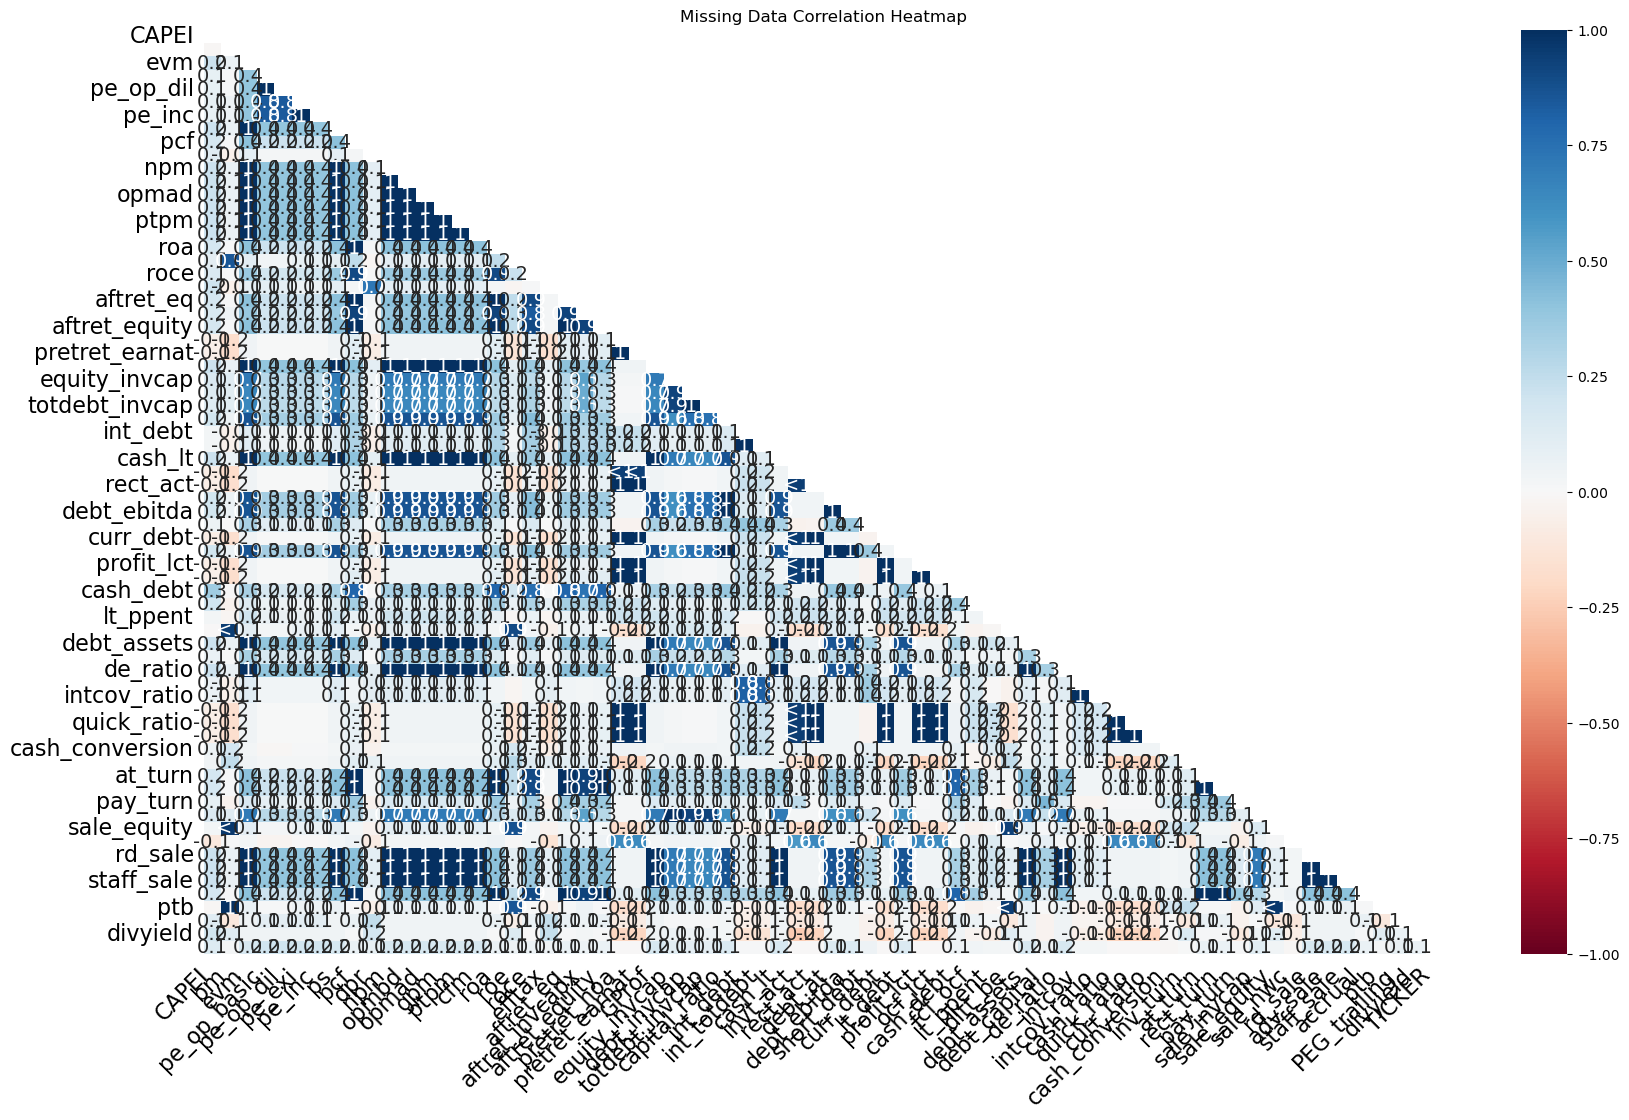

In [10]:
# Check the missing in the data
# 检查数据中的缺失情况
missing_values = fin_data.isnull().sum()
print(missing_values[missing_values > 0])

# 计算每个变量的缺失值比例
missing_ratios = fin_data.isnull().mean().sort_values(ascending=False)
print("缺失值比例：")
print(missing_ratios[missing_ratios > 0])  # 只显示有缺失值的变量

# 可视化缺失数据的相关性
plt.figure(figsize=(6, 5))
msno.heatmap(fin_data)
plt.title('Missing Data Correlation Heatmap')
plt.show()


In [11]:
# fin_data = fin_data.fillna(method = 'ffill', limit = 20).fillna(method = 'bfill', limit = 20)

# fin_data.iloc[0] = fin_data.iloc[0].fillna(fin_data.iloc[0:5].mean(numeric_only=True))
# fin_data.iloc[-1] = fin_data.iloc[-1].fillna(fin_data.iloc[-5:].mean(numeric_only=True))

# #update every quater
# fin_data['bm'] = fin_data.groupby(fin_data.index.to_period('Q'))['bm'].fillna(method='ffill')

# #对于波动较大的指标，可以考虑使用滚动平均填充
# fin_data['PEG_trailing'] = fin_data['PEG_trailing'].fillna(fin_data['PEG_trailing'].rolling(window=30, min_periods=1).mean())

# #股息收益率缺失可能意味着公司不派息。
# fin_data['divyield'] = fin_data['divyield'].fillna(0)

# #对于某些连续的财务指标，可以尝试插值
# fin_data['CAPEI'] = fin_data['CAPEI'].interpolate(method='time')

# #对于复杂的缺失模式，可以考虑使用多重插补方法，如MICE（Multiple Imputation by Chained Equations）
# imputer = IterativeImputer(max_iter=10, random_state=0)
# fin_data_imputed = pd.DataFrame(imputer.fit_transform(fin_data), columns=fin_data.columns)

In [12]:
import numpy as np

# 确保数据按日期排序
fin_data = fin_data.sort_index()

# 1. 高缺失率组处理
high_missing_cols = ['cash_conversion', 'sale_nwc']
for col in high_missing_cols:
    # 创建dummy variable
    fin_data[f'{col}_imputed'] = fin_data[col].isnull().astype(int)
    
    # 使用时间窗口的中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].rolling(window=30, min_periods=1, center=True).median())
    # 对于开始和结束的缺失值，使用全局中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].median())

# divyield 假设缺失值为0（公司不派息）
fin_data['divyield_imputed'] = fin_data['divyield'].isnull().astype(int)
fin_data['divyield'] = fin_data['divyield'].fillna(0)

# 2. 中等缺失率组处理
med_missing_cols = ['invt_act', 'inv_turn', 'curr_ratio', 'quick_ratio', 'cash_ratio', 
                    'ocf_lct', 'profit_lct', 'curr_debt', 'pretret_earnat', 'pretret_noa', 'rect_act',
                    'PEG_trailing']
for col in med_missing_cols:
    # 创建dummy variable
    fin_data[f'{col}_imputed'] = fin_data[col].isnull().astype(int)
    
    # 先进行前向填充
    fin_data[col] = fin_data[col].fillna(method='ffill', limit=5)
    # 然后使用时间窗口的中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].rolling(window=30, min_periods=1, center=True).median())
    # 对于仍然存在的缺失值，使用全局中位数填充
    fin_data[col] = fin_data[col].fillna(fin_data[col].median())

# 3. 低缺失率组处理
low_missing_cols = ['sale_equity', 'int_totdebt', 'int_debt', 'intcov_ratio', 'ptb', 'bm']
for col in low_missing_cols:
    # 创建dummy variable
    fin_data[f'{col}_imputed'] = fin_data[col].isnull().astype(int)
    
    # 使用前向填充，然后后向填充
    fin_data[col] = fin_data[col].fillna(method='ffill').fillna(method='bfill')

# 4. 极低缺失率组处理
very_low_missing_cols = ['debt_ebitda', 'pe_inc', 'pe_op_dil', 'pe_op_basic', 'pe_exi']
for col in very_low_missing_cols:
    # 创建dummy variable
    fin_data[f'{col}_imputed'] = fin_data[col].isnull().astype(int)
    
    # 使用简单的线性插值
    fin_data[col] = fin_data[col].interpolate()

print("Data preparation completed.")

Data preparation completed.


In [13]:
# 5. 对剩余的数值型变量使用 MICE 方法
numeric_columns = fin_data.select_dtypes(include=[np.number]).columns.tolist()

mice_imputer = IterativeImputer(max_iter=20, random_state=0)
fin_data_mice = pd.DataFrame(mice_imputer.fit_transform(fin_data[numeric_columns]), 
                             columns=numeric_columns, index=fin_data.index)
fin_data.update(fin_data_mice)

# 6. 处理任何剩余的缺失值
non_numeric_columns = fin_data.select_dtypes(exclude=[np.number]).columns.tolist()
mode_imputer = SimpleImputer(strategy='most_frequent')
fin_data[non_numeric_columns] = mode_imputer.fit_transform(fin_data[non_numeric_columns])

# 7. 检查是否还有剩余的缺失值
remaining_missing = fin_data.isnull().sum()
print("Remaining missing values:\n", remaining_missing[remaining_missing > 0])

print("Data preparation completed.")

Remaining missing values:
 Series([], dtype: int64)
Data preparation completed.


In [540]:
fin_data.to_csv('fin_data_after_handle_missing_values.csv')

In [539]:
fin_columns = fin_data.columns
print(fin_columns)

Index(['public_date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'TICKER'],
      dtype='object')


## Stock Data

In [14]:
# Load the CSV file to examine its content
sto_data = pd.read_csv('2014-2024 Buffet Portfolio - stock.csv')
sto_data.head()
sto_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 63 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PERMNO    89589 non-null  int64  
 1   date      89589 non-null  object 
 2   NAMEENDT  127 non-null    object 
 3   SHRCD     89589 non-null  int64  
 4   EXCHCD    89589 non-null  int64  
 5   SICCD     89589 non-null  object 
 6   NCUSIP    89589 non-null  object 
 7   TICKER    89589 non-null  object 
 8   COMNAM    89589 non-null  object 
 9   SHRCLS    24210 non-null  object 
 10  TSYMBOL   89589 non-null  object 
 11  NAICS     89563 non-null  float64
 12  PRIMEXCH  89589 non-null  object 
 13  TRDSTAT   89589 non-null  object 
 14  SECSTAT   89589 non-null  object 
 15  PERMCO    89589 non-null  int64  
 16  ISSUNO    89589 non-null  int64  
 17  HEXCD     89589 non-null  int64  
 18  HSICCD    89589 non-null  int64  
 19  CUSIP     89589 non-null  object 
 20  DCLRDT    931 non-null    ob

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/2704999772.py:2: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  sto_data = pd.read_csv('2014-2024 Buffet Portfolio - stock.csv')


In [15]:
sto_data_selected = sto_data.copy()

In [16]:
# Converting 'public_date' into datetime type
sto_data_selected['date'] = pd.to_datetime(sto_data_selected['date'])

In [17]:
# 步骤1: 处理因变量(投资回报率)
def clean_ret(ret):
    if isinstance(ret, str):
        # 处理特殊情况，如'C'或'B'
        if ret in ['C', 'B']:
            return np.nan
        # 移除百分号并转换为浮点数
        return float(ret.strip('%')) / 100
    return ret

# 将'RET'列转换为数值类型
sto_data_selected['RET'] = sto_data_selected['RET'].apply(clean_ret)

In [18]:
# 步骤3: 选择相关特征
relevant_features = ['date', 'TICKER', 'COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 
                     'PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 
                     'vwretd', 'ewretd', 'sprtrn']
sto_data_selected = sto_data_selected[relevant_features]

In [19]:
sto_data_selected.describe()

SHRCD        EXCHCD           PRC           VOL           RET  \
count  89589.000000  89589.000000  89583.000000  8.958300e+04  89570.000000   
mean      15.129893      1.757973    227.601511  1.079223e+07      0.000257   
std       14.497378      1.053536    635.967039  2.389194e+07      0.012422   
min       11.000000      1.000000      3.065000  4.099000e+03     -0.283530   
25%       11.000000      1.000000     37.470000  9.286940e+05     -0.000243   
50%       11.000000      1.000000     76.680000  2.602606e+06      0.000011   
75%       11.000000      3.000000    163.575005  7.792302e+06      0.000370   
max       73.000000      4.000000   7024.819820  5.072443e+08      0.422587   

             SHROUT         BIDLO         ASKHI       OPENPRC        vwretd  \
count  8.958300e+04  89583.000000  89583.000000  89583.000000  89589.000000   
mean   1.314680e+06    224.950986    230.144809    227.541278      0.000449   
std    2.443694e+06    627.836061    643.910272    635.758014      0.011025   
min    3.179000e+03      2.980000      3.110000      3.050000     -0.118168   
25%    1.845000e+05     36.990000     37.950000     37.475000     -0.003923   
50%    4.387400e+05     75.880300     77.420000     76.660000      0.000668   
75%    1.045085e+06    161.955000    165.174995    163.519995      0.005631   
max    1.710254e+07   6997.910160   7075.000000   7028.500000      0.091556   

             ewretd        sprtrn  
count  89589.000000  89589.000000  
mean       0.000343      0.000439  
std        0.010709      0.011170  
min       -0.107631     -0.119841  
25%       -0.004576     -0.003812  
50%        0.000709      0.000597  
75%        0.005748      0.005690  
max        0.082175      0.093828

In [20]:
sto_data_selected.columns

Index(['date', 'TICKER', 'COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL',
       'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd',
       'sprtrn'],
      dtype='object')

In [21]:
sto_data_selected.isnull().sum() 

date        0
TICKER      0
COMNAM      0
SHRCD       0
EXCHCD      0
SICCD       0
PRC         6
VOL         6
RET        19
SHROUT      6
BIDLO       6
ASKHI       6
OPENPRC     6
vwretd      0
ewretd      0
sprtrn      0
dtype: int64

In [22]:
sto_data_selected.head()

date TICKER        COMNAM  SHRCD  EXCHCD SICCD    PRC         VOL  \
0 2014-01-02     KO  COCA COLA CO     11       1  2086  40.66  12720200.0   
1 2014-01-03     KO  COCA COLA CO     11       1  2086  40.46  10403800.0   
2 2014-01-06     KO  COCA COLA CO     11       1  2086  40.27  11041200.0   
3 2014-01-07     KO  COCA COLA CO     11       1  2086  40.39  11879600.0   
4 2014-01-08     KO  COCA COLA CO     11       1  2086  39.94  15357500.0   

        RET     SHROUT  BIDLO    ASKHI  OPENPRC    vwretd    ewretd    sprtrn  
0 -0.000157  4415923.0  40.51  41.2250    41.12 -0.008757 -0.004051 -0.008862  
1 -0.000049  4415923.0  40.35  40.7300    40.68  0.000491  0.004096 -0.000333  
2 -0.000047  4415923.0  40.16  40.5926    40.48 -0.003340 -0.001676 -0.002512  
3  0.000030  4415923.0  40.29  40.7208    40.48  0.006090  0.006892  0.006082  
4 -0.000111  4415923.0  39.83  40.4400    40.44  0.000155  0.000835 -0.000212

In [23]:
# 3. TICKER (object) - 保持为字符串，可能需要进行标签编码
sto_data_selected['TICKER'] = sto_data_selected['TICKER'].astype('category')

# 5. SHRCD (int64) - 转换为类别型
sto_data_selected['SHRCD'] = sto_data_selected['SHRCD'].astype('category')

# 6. EXCHCD (int64) - 转换为类别型
sto_data_selected['EXCHCD'] = sto_data_selected['EXCHCD'].astype('category')

# 7. SICCD (object) - 转换为类别型
sto_data_selected['SICCD'] = sto_data_selected['SICCD'].astype('category')

In [24]:
# 定义一个函数来安全地应用LabelEncoder
def safe_label_encode(series):
    # 将所有值转换为字符串
    series = series.astype(str)
    le = LabelEncoder()
    return pd.Series(le.fit_transform(series), index=series.index)

# 对于可能需要进行机器学习的类别型变量，我们使用安全的编码方法
for col in ['TICKER', 'SHRCD', 'EXCHCD', 'SICCD']:
    # 首先，检查列中是否存在缺失值
    if sto_data_selected[col].isnull().any():
        # 如果存在缺失值，先填充它们
        sto_data_selected[col] = sto_data_selected[col].fillna('Unknown')
    
    # 然后应用安全的标签编码
    sto_data_selected[col + '_encoded'] = safe_label_encode(sto_data_selected[col])
    
    # 将原始列转换为类别类型
    sto_data_selected[col] = sto_data_selected[col].astype('category')

# 显示处理后的数据类型
print(sto_data_selected.dtypes)

date              datetime64[ns]
TICKER                  category
COMNAM                    object
SHRCD                   category
EXCHCD                  category
SICCD                   category
PRC                      float64
VOL                      float64
RET                      float64
SHROUT                   float64
BIDLO                    float64
ASKHI                    float64
OPENPRC                  float64
vwretd                   float64
ewretd                   float64
sprtrn                   float64
TICKER_encoded             int64
SHRCD_encoded              int64
EXCHCD_encoded             int64
SICCD_encoded              int64
dtype: object


In [25]:
# # Identify columns that may contain percentage signs or non-numeric values
# for col in fin_data.columns:
#     if fin_data[col].dtype == 'object':
#         # Check if there's a percentage sign and convert
#         try:
#             fin_data[col] = fin_data[col].str.replace('%', '').astype(float) / 100
#         except Exception as e:
#             print(f"Issue with column {col}: {e}")

In [26]:
sto_data_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89589 entries, 0 to 89588
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            89589 non-null  datetime64[ns]
 1   TICKER          89589 non-null  category      
 2   COMNAM          89589 non-null  object        
 3   SHRCD           89589 non-null  category      
 4   EXCHCD          89589 non-null  category      
 5   SICCD           89589 non-null  category      
 6   PRC             89583 non-null  float64       
 7   VOL             89583 non-null  float64       
 8   RET             89570 non-null  float64       
 9   SHROUT          89583 non-null  float64       
 10  BIDLO           89583 non-null  float64       
 11  ASKHI           89583 non-null  float64       
 12  OPENPRC         89583 non-null  float64       
 13  vwretd          89589 non-null  float64       
 14  ewretd          89589 non-null  float64       
 15  sp

## Missing Data

PRC         6
VOL         6
RET        19
SHROUT      6
BIDLO       6
ASKHI       6
OPENPRC     6
dtype: int64
缺失值比例：
RET        0.000212
BIDLO      0.000067
PRC        0.000067
VOL        0.000067
SHROUT     0.000067
ASKHI      0.000067
OPENPRC    0.000067
dtype: float64


<Figure size 600x500 with 0 Axes>

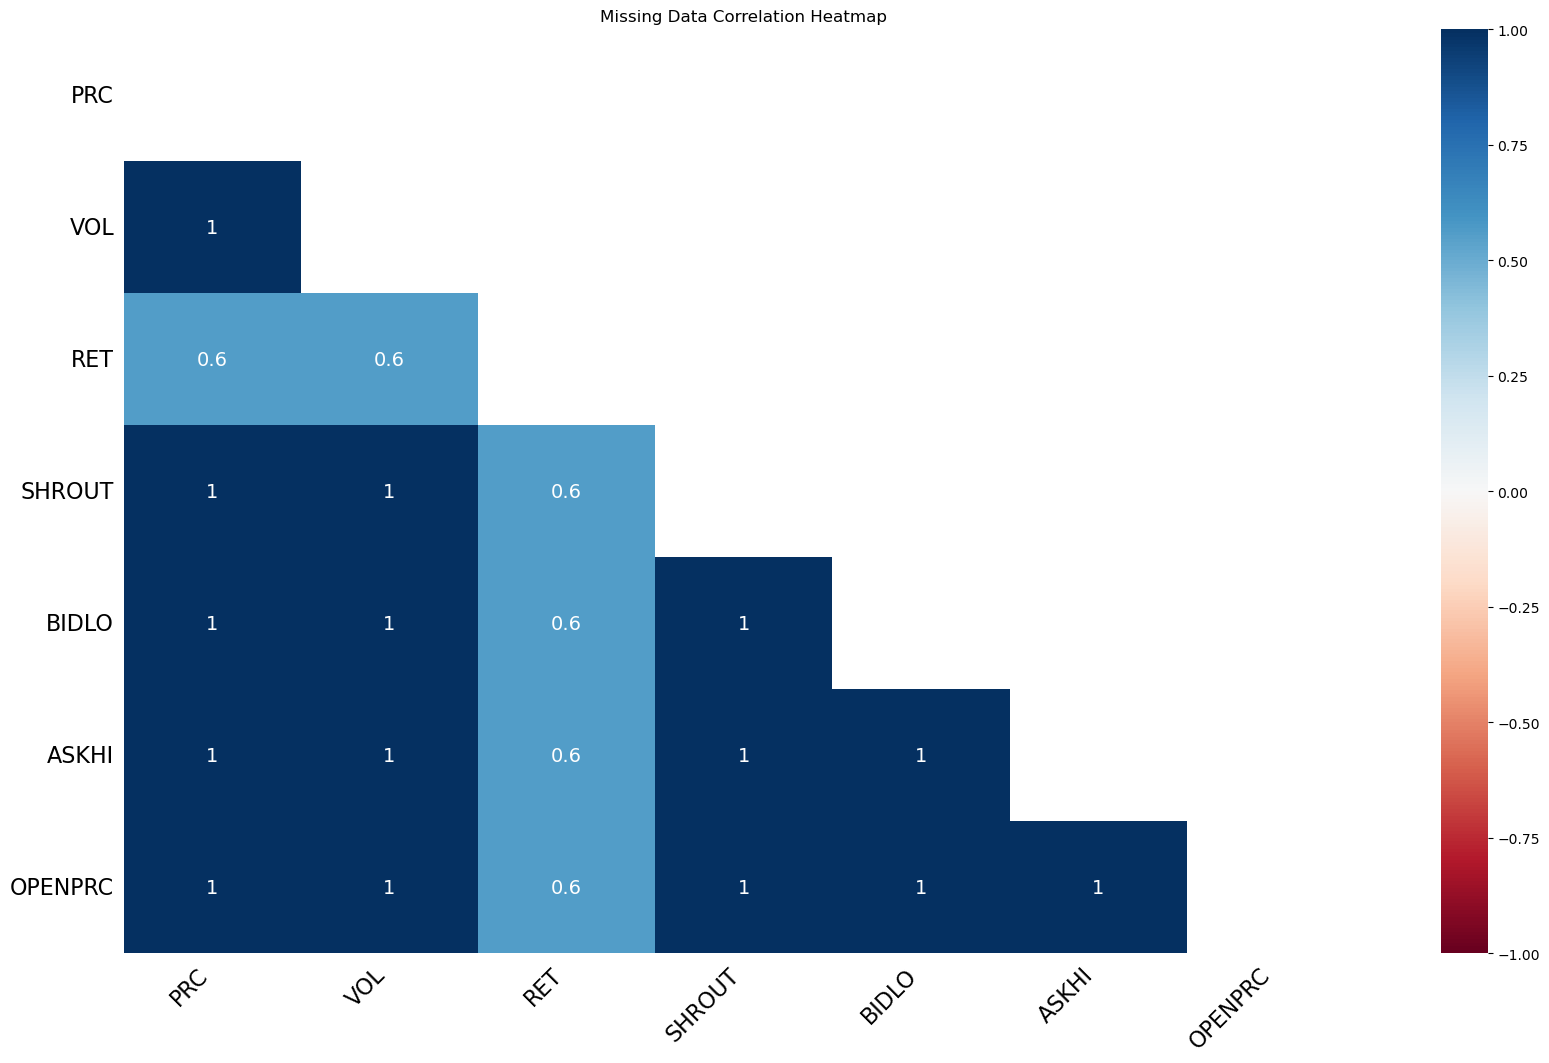

In [27]:
# Check the missing in the data
# 检查数据中的缺失情况
missing_values = sto_data_selected.isnull().sum()
print(missing_values[missing_values > 0])

# 计算每个变量的缺失值比例
missing_ratios = sto_data_selected.isnull().mean().sort_values(ascending=False)
print("缺失值比例：")
print(missing_ratios[missing_ratios > 0])  # 只显示有缺失值的变量

# 可视化缺失数据的相关性
plt.figure(figsize=(6, 5))
msno.heatmap(sto_data_selected)
plt.title('Missing Data Correlation Heatmap')
plt.show()


In [28]:
# 确保数据按日期排序
sto_data_selected = sto_data_selected.sort_values('date')

# 对价格类数据使用前向填充
price_columns = ['PRC', 'BIDLO', 'ASKHI', 'OPENPRC']
sto_data_selected[price_columns] = sto_data_selected.groupby('TICKER')[price_columns].fillna(method='ffill')

# 对交易量和流通股数使用前向填充
sto_data_selected[['VOL', 'SHROUT']] = sto_data_selected.groupby('TICKER')[['VOL', 'SHROUT']].fillna(method='ffill')



# 重新计算市值
sto_data_selected['market_cap'] = sto_data_selected['PRC'].abs() * sto_data_selected['SHROUT']

# 检查剩余的缺失值
missing_after = sto_data_selected[['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']].isnull().sum()
print("处理后的缺失值：")
print(missing_after)


处理后的缺失值：
PRC            0
VOL            0
RET           19
SHROUT         0
BIDLO          0
ASKHI          0
OPENPRC        0
market_cap     0
dtype: int64


In [29]:
sto_data_selected['RET'] = sto_data['RET'] 


In [30]:
# 处理回报率 (RET)
# 方法1：如果可能，基于价格重新计算
sto_data_selected['RET_calc'] = sto_data_selected.groupby('TICKER',group_keys=False)['PRC'].pct_change()

# 方法2：对原始 RET 使用线性插值
sto_data_selected['RET_interp'] = sto_data_selected.groupby('TICKER',group_keys=False)['RET'].apply(lambda x: x.interpolate(method='linear'))

# 合并两种方法的结果
sto_data_selected['RET'] = sto_data_selected['RET'].fillna(sto_data_selected['RET_calc'])
sto_data_selected['RET'] = sto_data_selected['RET'].fillna(sto_data_selected['RET_interp'])


In [31]:
missing_after = sto_data_selected[['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']].isnull().sum()
print("处理后的缺失值：")
print(missing_after)

处理后的缺失值：
PRC           0
VOL           0
RET           0
SHROUT        0
BIDLO         0
ASKHI         0
OPENPRC       0
market_cap    0
dtype: int64


In [32]:
# # 如果仍有缺失值，可能是因为某些股票在数据集开始时就有缺失值，我们可以使用后向填充来处理这种情况
# if missing_after.sum() > 0:
#     columns_to_fill = ['PRC', 'VOL', 'RET', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap']
#     sto_data_selected[columns_to_fill] = sto_data_selected.groupby('PERMNO')[columns_to_fill].fillna(method='bfill')

#     # 再次检查缺失值
#     missing_final = sto_data_selected[columns_to_fill].isnull().sum()
#     print("\n最终处理后的缺失值：")
#     print(missing_final)

# # 如果仍有缺失值，可能需要考虑删除这些行或使用更复杂的填充方法
# if missing_final.sum() > 0:
#     print("\n警告：仍有缺失值存在。可能需要进一步处理或考虑删除这些行。")

In [541]:
sto_data.to_csv('sto_data_after_handle_missing_values.csv')

In [548]:
sto_columns = sto_data.columns
print(sto_columns)

Index(['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP',
       'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT',
       'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT',
       'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG',
       'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM',
       'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD',
       'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET',
       'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'OPENPRC', 'NUMTRD',
       'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn'],
      dtype='object')


In [1233]:
sto_data_selected.to_csv('real_sto_data_after_handle_missing_values.csv')

In [1234]:
sto_featured_data = sto_data_selected.copy()

In [1295]:
def calculate_variables(df):
    # 重置索引，确保 'date' 列是 datetime 类型，并设置 'date' 列为索引
    df_reset = df.reset_index()
    df_reset['date'] = pd.to_datetime(df_reset['date'])
    df_reset.set_index('date', inplace=True)
    df_reset.sort_index(inplace=True)

    # 计算市值
    df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    
    # LME (Lagged Market Equity) 上个月月末的总市值
    df['LME'] = df.groupby('TICKER')['market_cap'].shift(21)
    
    # LTurnover 上月总交易量与上月月末总市值的比率
    df['LTurnover'] = df.groupby('TICKER').apply(lambda x: x['VOL'].rolling(window=21).sum() / x['LME']).reset_index(level=0, drop=True)
    
    # 上月美元交易量
    df['DollarVolume'] = df['PRC'].abs() * df['VOL']

    # Spread 上月日均买卖价差
    df['spread'] = (df['ASKHI'] - df['BIDLO']) / ((df['ASKHI'] + df['BIDLO']) / 2)
    df['spread'] = df.groupby('TICKER')['spread'].shift(21)

    # 确保 'RET' 列是数字类型
    df['RET'] = pd.to_numeric(df['RET'], errors='coerce')
    
    # 计算20天滚动标准差
    df['Volatility'] = df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
    df['Volatility'] = df['Volatility'].fillna(0)

    # 重置索引
    df_reset = df.reset_index()

    # Beta (simplified version) 用滚动计算
    def calculate_beta(stock_returns, market_returns, window=252):
        return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]), raw=True)
    
    df_reset['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))

    # 计算Beta平方
    df_reset['BetaSquared'] = df_reset['Beta'] ** 2

    df['Beta'] = df_reset['Beta']
    df['BetaSquared'] = df_reset['BetaSquared']

    # 计算特质波动性
    df_reset['expected_ret'] = df_reset['Beta'] * df_reset['sprtrn']
    df_reset['residuals'] = df_reset['RET'] - df_reset['expected_ret']
    df_reset['idio_vol'] = df_reset.groupby('TICKER')['residuals'].transform(lambda x: x.rolling(window=252, min_periods=1).std())
    df['idio_vol'] = df_reset['idio_vol']

    # 历史回报指标
    df['r2_1'] = df.groupby('TICKER')['RET'].shift(1)

    # 计算 r12_2, r12_7, r36_13
    df_reset['r12_2'] = df_reset.groupby('TICKER')['RET'].rolling(window=11).sum().shift(1).reset_index(0, drop=True)
    df_reset['r12_7'] = df_reset.groupby('TICKER')['RET'].rolling(window=6).sum().shift(6).reset_index(0, drop=True)
    df_reset['r36_13'] = df_reset.groupby('TICKER')['RET'].rolling(window=24).sum().shift(12).reset_index(0, drop=True)

    # 设置回原来的索引
    df_reset.set_index('index', inplace=True)
    
    # 将结果赋值给原始 DataFrame
    df['r12_2'] = df_reset['r12_2']
    df['r12_7'] = df_reset['r12_7']
    df['r36_13'] = df_reset['r36_13']

    df['RET_lag_1_mon'] = df.groupby('TICKER')['RET'].shift(1)

    # Rel to high 接近52周最高价的程度
    df_reset['52_week_high'] = df_reset.groupby('TICKER')['PRC'].rolling(window=252).max().reset_index(0, drop=True)
    
    # 计算 Rel_to_high
    df_reset['Rel_to_high'] = df_reset['PRC'] / df_reset['52_week_high']
    
    # 将结果赋值给原始 DataFrame
    df['52_week_high'] = df_reset['52_week_high']
    df['Rel_to_high'] = df_reset['Rel_to_high']
    
    # SUV (Standardized Unexplained Volume)
    def calculate_suv(volume, window=20):
        log_volume = np.log(volume)
        mean_log_volume = log_volume.rolling(window=window).mean()
        std_log_volume = log_volume.rolling(window=window).std()
        return (log_volume - mean_log_volume) / std_log_volume
    
    df['SUV'] = df.groupby('TICKER')['VOL'].apply(calculate_suv)
    
    return df

# Apply the function to your dataframe
sto_featured_data = calculate_variables(sto_featured_data)


/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/3566529225.py:38: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_reset['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))
/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/3566529225.py:87: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence 

In [1296]:
sto_featured_data.head()

date TICKER                      COMNAM SHRCD EXCHCD SICCD     PRC  \
0 2014-01-02     KO                COCA COLA CO    11      1  2086   40.66   
1 2014-01-02    SPY  SPDR S & P 500 E T F TRUST    73      4  6726  182.92   
2 2014-01-02      C               CITIGROUP INC    11      1  6021   52.27   
3 2014-01-02    AXP         AMERICAN EXPRESS CO    11      1  6141   89.45   
4 2014-01-02   SIRI     SIRIUS X M HOLDINGS INC    11      3  4832    3.50   

           VOL       RET     SHROUT   BIDLO      ASKHI  OPENPRC    vwretd  \
0   12720200.0 -0.015735  4415923.0   40.51   41.22500    41.12 -0.008757   
1  119636800.0 -0.009584   945832.0  182.48  184.07001   183.98 -0.008757   
2   16489800.0  0.003070  3033001.0   51.81   52.40000    52.03 -0.008757   
3    5120000.0 -0.014108  1071271.0   89.38   91.08000    90.90 -0.008757   
4   34370976.0  0.002865  6096221.0    3.45    3.52000     3.46 -0.008757   

     ewretd    sprtrn  TICKER_encoded  SHRCD_encoded  EXCHCD_encoded  \
0 -0.004051 -0.008862              22              0               0   
1 -0.004051 -0.008862              40              3               2   
2 -0.004051 -0.008862               8              0               0   
3 -0.004051 -0.008862               5              0               0   
4 -0.004051 -0.008862              38              0               1   

   SICCD_encoded    market_cap  RET_calc RET_interp  LME  LTurnover  \
0              5  1.795514e+08       NaN  -0.015735  NaN        NaN   
1             34  1.730116e+08       NaN  -0.009584  NaN        NaN   
2             22  1.585350e+08       NaN    0.00307  NaN        NaN   
3             26  9.582519e+07       NaN  -0.014108  NaN        NaN   
4             12  2.133677e+07       NaN   0.002865  NaN        NaN   

   DollarVolume  spread  Volatility  Beta  BetaSquared  r2_1     r12_2  \
0  5.172033e+08     NaN         0.0   NaN          NaN   NaN -0.017647   
1  2.188396e+10     NaN         0.0   NaN          NaN   NaN  0.013304   
2  8.619218e+08     NaN         0.0   NaN          NaN   NaN  0.043347   
3  4.579840e+08     NaN         0.0   NaN          NaN   NaN -0.137733   
4  1.202984e+08     NaN         0.0   NaN          NaN   NaN -0.053943   

      r12_7    r36_13  RET_lag_1_mon  52_week_high  Rel_to_high  SUV  idio_vol  
0 -0.045725  0.139231            NaN           NaN          NaN  NaN       NaN  
1  0.001870  0.220353            NaN           NaN          NaN  NaN       NaN  
2  0.035376 -0.018585            NaN           NaN          NaN  NaN       NaN  
3 -0.147623  0.024673            NaN           NaN          NaN  NaN       NaN  
4 -0.035546  0.306782            NaN           NaN          NaN  NaN       NaN

## Macroeconomic Index

In [33]:
dfy = pd.read_csv('DFY (Default Yield Spread)- 2014 - 2024.csv')
tbl = pd.read_csv('TBL (Treasury Bill Rate) - 2014 - 2024.csv')
tms = pd.read_csv('TMS (Term Spread) - 2014 - 2024.csv')

In [34]:
dfy.info()
tbl.info()
tms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    2740 non-null   object
 1   BAA10Y  2740 non-null   object
dtypes: object(2)
memory usage: 42.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    126 non-null    object 
 1   TB3MS   126 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742 entries, 0 to 2741
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    2742 non-null   object
 1   T10Y2Y  2742 non-null   object
dtypes: object(2)
memory usage: 43.0+ KB


In [35]:
# 检查每个 DataFrame 的基本信息
print("tbl shape:", tbl.shape)
print("tms shape:", tms.shape)
print("dfy shape:", dfy.shape)

print("\ntbl head:")
print(tbl.head())
print("\ntms head:")
print(tms.head())
print("\ndfy head:")
print(dfy.head())

# 检查日期范围
print("\nDate ranges:")
print("tbl:", tbl.index.min(), "to", tbl.index.max())
print("tms:", tms.index.min(), "to", tms.index.max())
print("dfy:", dfy.index.min(), "to", dfy.index.max())



tbl shape: (126, 2)
tms shape: (2742, 2)
dfy shape: (2740, 2)

tbl head:
         DATE  TB3MS
0  2014-01-01   0.04
1  2014-02-01   0.05
2  2014-03-01   0.05
3  2014-04-01   0.03
4  2014-05-01   0.03

tms head:
         DATE T10Y2Y
0  2014-01-02   2.61
1  2014-01-03   2.60
2  2014-01-06   2.58
3  2014-01-07   2.56
4  2014-01-08   2.58

dfy head:
         DATE BAA10Y
0  2014-01-02   2.34
1  2014-01-03   2.34
2  2014-01-06   2.32
3  2014-01-07   2.32
4  2014-01-08   2.31

Date ranges:
tbl: 0 to 125
tms: 0 to 2741
dfy: 0 to 2739


In [36]:
tbl.index = pd.to_datetime(tbl.DATE)
tbl.drop(columns='DATE', inplace=True)  # 移除原始的 DATE 列

tms.index = pd.to_datetime(tms.DATE)
tms.drop(columns='DATE', inplace=True)  # 移除原始的 DATE 列

dfy.index = pd.to_datetime(dfy.DATE)
dfy.drop(columns='DATE', inplace=True)  # 移除原始的 DATE 列


In [37]:
print("\ntbl head:")
print(tbl.head())
print("\ntms head:")
print(tms.head())
print("\ndfy head:")
print(dfy.head())

# 检查日期范围
print("\nDate ranges:")
print("tbl:", tbl.index.min(), "to", tbl.index.max())
print("tms:", tms.index.min(), "to", tms.index.max())
print("dfy:", dfy.index.min(), "to", dfy.index.max())


tbl head:
            TB3MS
DATE             
2014-01-01   0.04
2014-02-01   0.05
2014-03-01   0.05
2014-04-01   0.03
2014-05-01   0.03

tms head:
           T10Y2Y
DATE             
2014-01-02   2.61
2014-01-03   2.60
2014-01-06   2.58
2014-01-07   2.56
2014-01-08   2.58

dfy head:
           BAA10Y
DATE             
2014-01-02   2.34
2014-01-03   2.34
2014-01-06   2.32
2014-01-07   2.32
2014-01-08   2.31

Date ranges:
tbl: 2014-01-01 00:00:00 to 2024-06-01 00:00:00
tms: 2014-01-02 00:00:00 to 2024-07-05 00:00:00
dfy: 2014-01-02 00:00:00 to 2024-07-03 00:00:00


In [38]:
# 定义一个函数来安全地转换为浮点数
def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# 将所有列转换为float类型，同时处理无效值
tbl['TB3MS'] = tbl['TB3MS'].apply(safe_float)
tms['T10Y2Y'] = tms['T10Y2Y'].apply(safe_float)
dfy['BAA10Y'] = dfy['BAA10Y'].apply(safe_float)

# 检查转换后的数据
print("tbl head after conversion:")
print(tbl.head())
print("\ntms head after conversion:")
print(tms.head())
print("\ndfy head after conversion:")
print(dfy.head())

tbl head after conversion:
            TB3MS
DATE             
2014-01-01   0.04
2014-02-01   0.05
2014-03-01   0.05
2014-04-01   0.03
2014-05-01   0.03

tms head after conversion:
            T10Y2Y
DATE              
2014-01-02    2.61
2014-01-03    2.60
2014-01-06    2.58
2014-01-07    2.56
2014-01-08    2.58

dfy head after conversion:
            BAA10Y
DATE              
2014-01-02    2.34
2014-01-03    2.34
2014-01-06    2.32
2014-01-07    2.32
2014-01-08    2.31


In [39]:
# 对所有数据进行月度重采样
tbl_monthly = tbl.resample('M').last()  # 使用月末数据
tms_monthly = tms.resample('M').mean()  # 月平均
dfy_monthly = dfy.resample('M').mean()  # 月平均

# 合并数据
macro_data = tbl_monthly.join(tms_monthly, how='outer').join(dfy_monthly, how='outer')

# 用前向填充方法处理缺失值
macro_data = macro_data.ffill()

print("Merged and resampled data info:")
print(macro_data.info())

print("\nMerged and resampled data head:")
print(macro_data.head())

# 检查是否还有缺失值
print("\nMissing values:")
print(macro_data.isnull().sum())

Merged and resampled data info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2014-01-31 to 2024-07-31
Freq: M
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TB3MS   127 non-null    float64
 1   T10Y2Y  127 non-null    float64
 2   BAA10Y  127 non-null    float64
dtypes: float64(3)
memory usage: 8.0 KB
None

Merged and resampled data head:
            TB3MS    T10Y2Y    BAA10Y
DATE                                 
2014-01-31   0.04  2.464286  2.334762
2014-02-28   0.05  2.382632  2.390000
2014-03-31   0.05  2.324286  2.340952
2014-04-30   0.03  2.288095  2.199048
2014-05-31   0.03  2.170000  2.203810

Missing values:
TB3MS     0
T10Y2Y    0
BAA10Y    0
dtype: int64


In [544]:
macro_columns = macro_data.columns
print(macro_columns)

Index(['TB3MS', 'T10Y2Y', 'BAA10Y'], dtype='object')


In [543]:
macro_data.to_csv('macro_data_after_handle_missing_data.csv')

## Merge dataset

In [40]:
# fin_data = fin_data_temp

In [1297]:
# 1. 设置日期索引
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])
fin_data.set_index('public_date', inplace=True)

sto_featured_data['date'] = pd.to_datetime(sto_featured_data['date'])
sto_featured_data.set_index('date', inplace=True)

# 确保 econ 的索引是 DatetimeIndex
macro_data.index = pd.to_datetime(macro_data.index)

#已经是dataframe且为index了

In [1298]:
# 检查每个 DataFrame 的基本信息
print("financial data shape:", fin_data.shape)
print("stock data shape:", sto_featured_data.shape)
print("macroeconomic data shape:", macro_data.shape)

print("\nfin head:")
print(fin_data.head())
print("\nstk head:")
print(sto_featured_data.head())
print("\necon head:")
print(macro_data.head())

# 检查日期范围
print("\nDate ranges:")
print("fin:", fin_data.index.min(), "to", fin_data.index.max())
print("stk:", sto_featured_data.index.min(), "to", sto_featured_data.index.max())
print("econ:", macro_data.index.min(), "to", macro_data.index.max())


financial data shape: (3602, 70)
stock data shape: (89589, 38)
macroeconomic data shape: (127, 3)

fin head:
              CAPEI     bm     evm  pe_op_basic  pe_op_dil  pe_exi  pe_inc  \
public_date                                                                  
2014-01-31   19.421  0.224  15.807       18.183     18.539  19.596  19.596   
2014-02-28   18.781  0.216  16.794       18.454     18.818  20.105  20.105   
2014-03-31   19.007  0.216  16.794       18.676     19.044  20.347  20.347   
2014-04-30   20.005  0.216  16.794       19.705     20.094  21.468  21.468   
2014-05-31   20.253  0.229  16.135       19.763     20.252  21.877  21.877   

                ps     pcf    dpr    npm  opmbd  opmad    gpm   ptpm    cfm  \
public_date                                                                   
2014-01-31   3.533  15.880  0.547  0.185  0.277  0.235  0.645  0.246  0.228   
2014-02-28   3.592  15.965  0.579  0.183  0.278  0.238  0.648  0.245  0.226   
2014-03-31   3.635  16.157  

In [1299]:
# 检查日期范围
print("\nDate ranges:")
print("fin:", fin_data.index.min(), "to", fin_data.index.max())
print("stk:", sto_featured_data.index.min(), "to", sto_featured_data.index.max())
print("econ:", macro_data.index.min(), "to", macro_data.index.max())


Date ranges:
fin: 2014-01-31 00:00:00 to 2023-11-30 00:00:00
stk: 2014-01-02 00:00:00 to 2023-12-29 00:00:00
econ: 2014-01-31 00:00:00 to 2024-07-31 00:00:00


In [1242]:
# 统一日期范围
# start_date = '2014-01-31'
# end_date = '2023-12-31'

# 截断数据到指定的日期范围
# fin_monthly = fin_data[start_date:end_date].resample('M').mean()
# stk_monthly = sto_data_selected[start_date:end_date].resample('M').last()
# macro_monthly = macro_data[start_date:end_date].resample('M').last()

# # 确保索引对齐（主要对宏观数据可能存在的问题）
# fin_monthly.index = fin_monthly.index.to_period('M').to_timestamp('M')
# stk_monthly.index = stk_monthly.index.to_period('M').to_timestamp('M')
# macro_monthly.index = macro_monthly.index.to_period('M').to_timestamp('M')

In [1300]:
# 重置索引
fin_data = fin_data.reset_index()
sto_featured_data = sto_featured_data.reset_index()

# 确保日期列是datetime类型
fin_data['public_date'] = pd.to_datetime(fin_data['public_date'])
sto_featured_data['date'] = pd.to_datetime(sto_featured_data['date'])

# 设置日期范围
start_date = pd.Timestamp('2014-01-31')
end_date = pd.Timestamp('2023-12-31')

# 筛选日期范围并进行分组
fin_monthly = (fin_data[(fin_data['public_date'] >= start_date) & (fin_data['public_date'] <= end_date)]
               .groupby(['TICKER', pd.Grouper(key='public_date', freq='M')])
               .last()
               .reset_index())

stk_monthly = (sto_featured_data[(sto_featured_data['date'] >= start_date) & (sto_featured_data['date'] <= end_date)]
               .groupby(['TICKER', pd.Grouper(key='date', freq='M')])
               .last()
               .reset_index())

# 重命名日期列，使其一致
fin_monthly = fin_monthly.rename(columns={'public_date': 'date'})

In [1301]:
# 对宏观经济数据进行同样的处理
# macro_data = macro_data.reset_index()
# macro_data['DATE'] = pd.to_datetime(macro_data['DATE'])
econ_monthly = macro_data[(macro_data.index >= start_date) & (macro_data.index <= end_date)]

In [1302]:
fin_tickers = set(fin_monthly['TICKER'])
stk_tickers = set(stk_monthly['TICKER'])
common_tickers = fin_tickers.intersection(stk_tickers)

print(f"Financial data tickers: {len(fin_tickers)}")
print(f"Stock data tickers: {len(stk_tickers)}")
print(f"Common tickers: {len(common_tickers)}")

fin_monthly = fin_monthly[fin_monthly['TICKER'].isin(common_tickers)]
stk_monthly = stk_monthly[stk_monthly['TICKER'].isin(common_tickers)]
macro_monthly = econ_monthly

Financial data tickers: 40
Stock data tickers: 46
Common tickers: 38


In [1303]:
fin_monthly.shape


(3352, 71)

In [1304]:
stk_monthly.shape


(4560, 39)

In [1305]:
macro_monthly.shape

(120, 3)

In [51]:
# # 2. 重采样到月度频率
# fin_monthly = fin_data.resample('M').last()  # 假设使用月末数据
# fin_monthly = fin_data[start_date:end_date].groupby(['TICKER', pd.Grouper(freq='M')]).mean()
# stk_monthly = sto_data[start_date:end_date].groupby(['TICKER', pd.Grouper(freq='M')]).last()  # 对每个 TICKER 分组后取月末数据
# econ_monthly = macro_data  # 已经是月度数据

In [52]:
# # 3. 重置索引并重命名日期列，以便于合并
# fin_monthly = fin_monthly.reset_index().rename(columns={'public_date': 'date'})
# stk_monthly = stk_monthly.reset_index()  # 'date' 列已经存在

In [53]:
# # 转换日期至月末
# fin_monthly['date'] = fin_monthly['date'].dt.to_period('M').dt.to_timestamp('M')
# stk_monthly['date'] = stk_monthly['date'].dt.to_period('M').dt.to_timestamp('M')


In [54]:
# fin_monthly = fin_monthly.sort_values(by=['TICKER', 'date'])
# stk_monthly = stk_monthly.sort_values(by=['TICKER', 'date'])
# econ_monthly = econ_monthly.sort_values(by='DATE')

In [55]:
# merged = pd.merge(fin_monthly.reset_index(), 
#                   stk_monthly.reset_index(), 
#                   on=['TICKER', 'date'], 
#                   how='inner',  # 使用内连接只保留共有的数据
#                   suffixes=('_fin', '_stk'))

In [56]:
# 3. 合并数据
# 首先合并 fin 和 stk
# merged = pd.merge(fin_monthly.reset_index(), 
#                   stk_monthly.reset_index(), 
#                   on=['TICKER','date'], 
#                   how='outer',
#                   suffixes=('_fin', '_stk'))


In [1306]:
merged = pd.merge(fin_monthly, 
                  stk_monthly, 
                  on=['TICKER', 'date'], 
                  how='inner',
                  suffixes=('_fin', '_stk'))



In [1307]:
merged.shape
merged.isnull().sum()

TICKER               0
date                 0
CAPEI                0
bm                   0
evm                  0
pe_op_basic          0
pe_op_dil            0
pe_exi               0
pe_inc               0
ps                   0
pcf                  0
dpr                  0
npm                  0
opmbd                0
opmad                0
gpm                  0
ptpm                 0
cfm                  0
roa                  0
roe                  0
roce                 0
efftax               0
aftret_eq            0
aftret_invcapx       0
aftret_equity        0
pretret_noa          0
pretret_earnat       0
GProf                0
equity_invcap        0
debt_invcap          0
totdebt_invcap       0
capital_ratio        0
int_debt             0
int_totdebt          0
cash_lt              0
invt_act             0
rect_act             0
debt_at              0
debt_ebitda          0
short_debt           0
curr_debt            0
lt_debt              0
profit_lct           0
ocf_lct    

In [1308]:
merged.isnull().groupby('TICKER').sum().sort_values(by='CAPEI', ascending=False)


date  CAPEI  bm  evm  pe_op_basic  pe_op_dil  pe_exi  pe_inc  ps  pcf  \
TICKER                                                                          
False      0      0   0    0            0          0       0       0   0    0   

        dpr  npm  opmbd  opmad  gpm  ptpm  cfm  roa  roe  roce  efftax  \
TICKER                                                                   
False     0    0      0      0    0     0    0    0    0     0       0   

        aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  pretret_earnat  \
TICKER                                                                          
False           0               0              0            0               0   

        GProf  equity_invcap  debt_invcap  totdebt_invcap  capital_ratio  \
TICKER                                                                     
False       0              0            0               0              0   

        int_debt  int_totdebt  cash_lt  invt_act  rect_act  debt_at  \
TICKER                                                                
False          0            0        0         0         0        0   

        debt_ebitda  short_debt  curr_debt  lt_debt  profit_lct  ocf_lct  \
TICKER                                                                     
False             0           0          0        0           0        0   

        cash_debt  fcf_ocf  lt_ppent  dltt_be  debt_assets  debt_capital  \
TICKER                                                                     
False           0        0         0        0            0             0   

        de_ratio  intcov  intcov_ratio  cash_ratio  quick_ratio  curr_ratio  \
TICKER                                                                        
False          0       0             0           0            0           0   

        cash_conversion  inv_turn  at_turn  rect_turn  pay_turn  sale_invcap  \
TICKER                                                                         
False                 0         0        0          0         0            0   

        sale_equity  sale_nwc  rd_sale  adv_sale  staff_sale  accrual  ptb  \
TICKER                                                                       
False             0         0        0         0           0        0    0   

        PEG_trailing  divyield  COMNAM  SHRCD  EXCHCD  SICCD  PRC  VOL  RET  \
TICKER                                                                        
False              0         0       7      7       7      7    7    7    7   

        SHROUT  BIDLO  ASKHI  OPENPRC  vwretd  ewretd  sprtrn  TICKER_encoded  \
TICKER                                                                          
False        7      7      7        7       7       7       7               7   

        SHRCD_encoded  EXCHCD_encoded  SICCD_encoded  market_cap  RET_calc  \
TICKER                                                                       
False               7               7              7           7         7   

        RET_interp  LME  LTurnover  DollarVolume  spread  Volatility  Beta  \
TICKER                                                                       
False            7   33         33             7      33           7   381   

        BetaSquared  r2_1  r12_2  r12_7  r36_13  RET_lag_1_mon  52_week_high  \
TICKER                                                                         
False           381     7      7      7      33              7           371   

        Rel_to_high  SUV  idio_vol  
TICKER                              
False           371    7       397

In [1309]:
# 然后将 econ 数据合并进来
final_data = pd.merge(merged, 
                      econ_monthly.reset_index(), 
                      left_on='date', 
                      right_on='DATE', 
                      how='left')

final_data.drop('DATE', axis=1, inplace=True)

In [1310]:
# 打印合并后的数据信息
print("Final merged data info:")
print(final_data.info())

print("\nFinal merged data head:")
print(final_data.tail())

# 检查缺失值
print("\nMissing values:")
print(final_data.isnull().sum())

# 保存合并后的数据
final_data.to_csv('merged_financial_stock_macro_data_with_better_features.csv')

Final merged data info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3352 entries, 0 to 3351
Columns: 111 entries, TICKER to BAA10Y
dtypes: category(3), datetime64[ns](1), float64(104), object(3)
memory usage: 2.8+ MB
None

Final merged data head:
     TICKER       date   CAPEI     bm     evm  pe_op_basic  pe_op_dil  pe_exi  \
3347   VRSN 2023-07-31  31.738  0.139  21.699       32.354     32.354  32.354   
3348   VRSN 2023-08-31  30.740  0.139  22.749       30.693     30.693  30.693   
3349   VRSN 2023-09-30  29.749  0.139  22.749       29.916     29.916  29.916   
3350   VRSN 2023-10-31  29.241  0.139  22.749       29.492     29.492  29.492   
3351   VRSN 2023-11-30  30.575  0.139  22.929       30.228     30.228  30.228   

      pe_inc      ps     pcf  dpr    npm  opmbd  opmad    gpm   ptpm    cfm  \
3347  32.354  15.083  24.639  0.0  0.482  0.698  0.665  0.894  0.629  0.514   
3348  30.693  14.653  24.259  0.0  0.488  0.696  0.665  0.894  0.637  0.519   
3349  29.916  14.181  2

In [1311]:
# 检查数据类型和唯一值
print(fin_monthly.dtypes)
print(stk_monthly.dtypes)
print(fin_monthly['TICKER'].unique())
print(stk_monthly['TICKER'].unique())
print(fin_monthly['date'].unique())
print(stk_monthly['date'].unique())

# 确保日期和TICKER格式一致
fin_monthly['date'] = pd.to_datetime(fin_monthly['date'])
stk_monthly['date'] = pd.to_datetime(stk_monthly['date'])
fin_monthly['TICKER'] = fin_monthly['TICKER'].str.upper()
stk_monthly['TICKER'] = stk_monthly['TICKER'].str.upper()

final_data.shape

# 如果inner合并后数据行数大大减少，说明可能存在键值不匹配问题

TICKER                     object
date               datetime64[ns]
CAPEI                     float64
bm                        float64
evm                       float64
pe_op_basic               float64
pe_op_dil                 float64
pe_exi                    float64
pe_inc                    float64
ps                        float64
pcf                       float64
dpr                       float64
npm                       float64
opmbd                     float64
opmad                     float64
gpm                       float64
ptpm                      float64
cfm                       float64
roa                       float64
roe                       float64
roce                      float64
efftax                    float64
aftret_eq                 float64
aftret_invcapx            float64
aftret_equity             float64
pretret_noa               float64
pretret_earnat            float64
GProf                     float64
equity_invcap             float64
debt_invcap   

(3352, 111)

## Description Analysis

In [63]:
desc_data = final_data.copy()
desc_data.RET.dtype
desc_data['RET'] = pd.to_numeric(desc_data['RET'], errors='coerce')

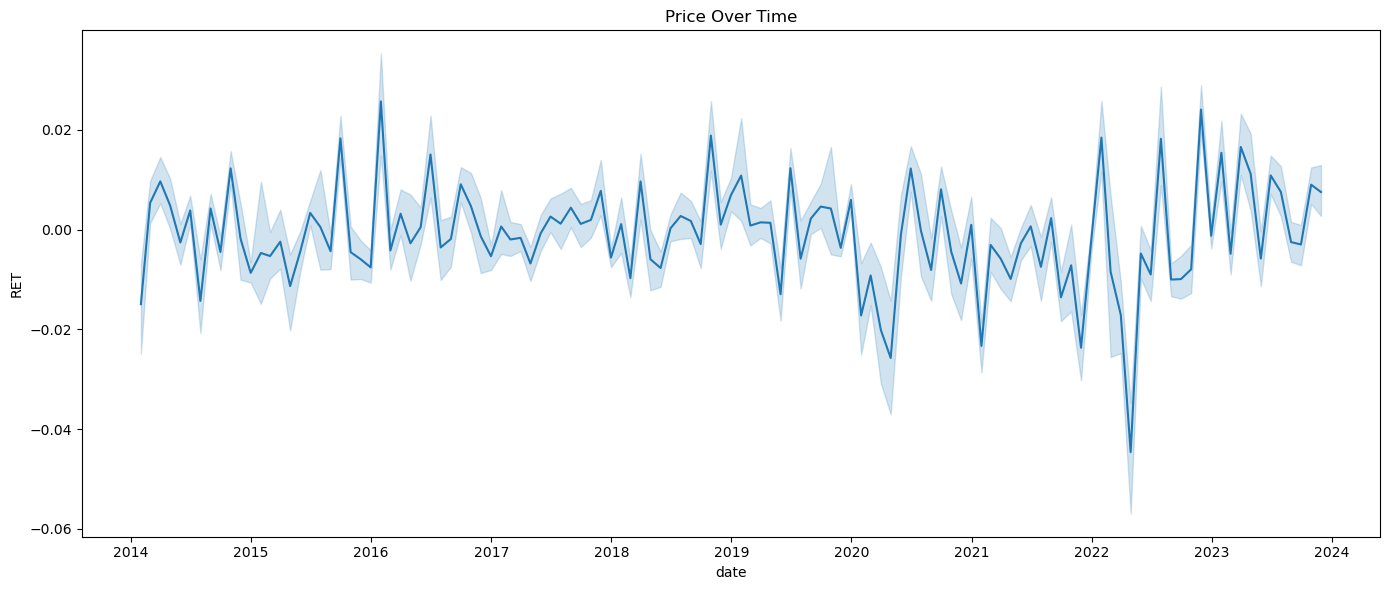

CAPEI           bm          evm  pe_op_basic    pe_op_dil  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean     31.958720     0.542949    12.008982    14.112428    14.163760   
std     157.018292     0.496675   141.142298    56.647485    56.913547   
min   -2615.300000     0.003000 -4544.900000  -714.520000  -714.520000   
25%      12.368750     0.139000     9.977000    10.190750    10.329750   
50%      22.713500     0.393500    13.779000    17.332500    17.647500   
75%      36.728000     0.845250    18.952000    27.948250    28.442250   
max    1447.000000     2.968000   983.733000   478.000000   490.500000   

            pe_exi       pe_inc           ps          pcf          dpr  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean     16.545729    18.336471     4.169608    13.989193     0.397618   
std      65.455845    63.826364     7.829604    37.215023     2.733596   
min    -942.310000  -868.340000    -4.300034  -614.440000   -20.310693   
25%       9.518250     9.433500     1.257750     5.784250     0.000000   
50%      18.135500    18.171000     1.978500    11.146500     0.199000   
75%      29.963000    30.627500     4.205000    21.197000     0.377000   
max     480.000000   516.316000   126.556000   400.801000    66.000000   

               npm        opmbd        opmad          gpm         ptpm  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.127597     0.298683     0.226827     0.441569     0.170659   
std       0.185347     0.199035     0.214434     0.202618     0.219502   
min      -0.911000    -0.902000    -0.919000    -0.366000    -0.997000   
25%       0.049000     0.188000     0.112000     0.285000     0.065000   
50%       0.113000     0.290000     0.219000     0.413000     0.159000   
75%       0.207000     0.391000     0.331250     0.588000     0.255250   
max       0.644000     0.707000     0.677000     0.998000     0.676000   

               cfm          roa          roe         roce       efftax  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.225396     0.142342     0.498322     0.208124     0.243414   
std       0.202277     0.124506     1.989518     0.322075     1.147141   
min      -0.893000    -0.343000    -6.313013    -0.270000   -16.992207   
25%       0.119000     0.055000     0.062000     0.061000     0.181000   
50%       0.202000     0.127493     0.145000     0.113000     0.237500   
75%       0.281000     0.204000     0.336000     0.248000     0.341000   
max       0.934000     0.911000    56.861119     2.498000    11.936882   

         aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
count  3352.000000     3352.000000    3352.000000  3352.000000   
mean      0.129848        0.190231       0.127885    -2.699061   
std       2.146488        0.445211       2.145672   122.882474   
min     -47.644000       -0.922000     -47.644000 -4068.000000   
25%       0.042000        0.049750       0.045000     0.138000   
50%       0.120000        0.093000       0.120000     0.245000   
75%       0.300000        0.182250       0.295000     0.739750   
max      28.033000        6.294000      28.033000   411.240000   

       pretret_earnat        GProf  equity_invcap  debt_invcap  \
count     3352.000000  3352.000000    3352.000000  3352.000000   
mean         0.268930     0.239113       0.245119     0.729474   
std          0.222261     0.205202       1.704557     1.707110   
min         -0.448000    -0.087000     -32.809000    -5.631040   
25%          0.119000     0.066000       0.329000     0.347000   
50%          0.211000     0.199000       0.466000     0.505000   
75%          0.414000     0.357000       0.612000     0.646000   
max          0.915000     0.997000       6.606851    33.809000   

       totdebt_invcap  capital_ratio     int_debt  int_totdebt      cash_lt  \
count     3352.000000    3352.000000  3352.000000  3352.000000  3352.000000 

In [369]:
# Basic statistical description
statistical_description = desc_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting CAPEI
sns.lineplot(x='date', y='RET', data=desc_data).set_title('Price Over Time')

plt.tight_layout()

plt.savefig('Price_over_time.png')

plt.show()

statistical_description


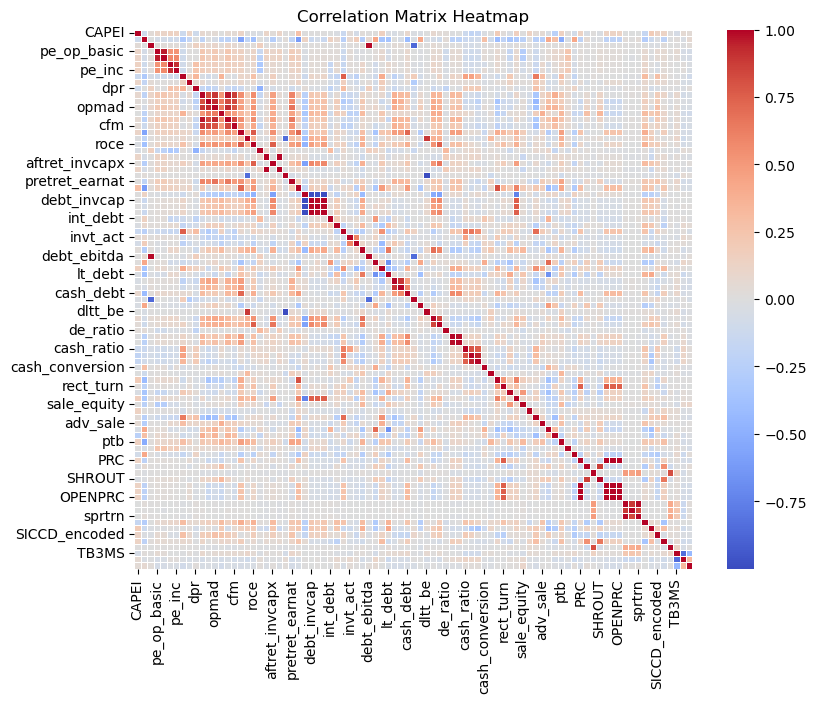

In [371]:
# Recalculate the correlation matrix
correlation_matrix = desc_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.savefig('Correlation_matrix_heatmap.png')

plt.show()


/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/2512573529.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  desc_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);


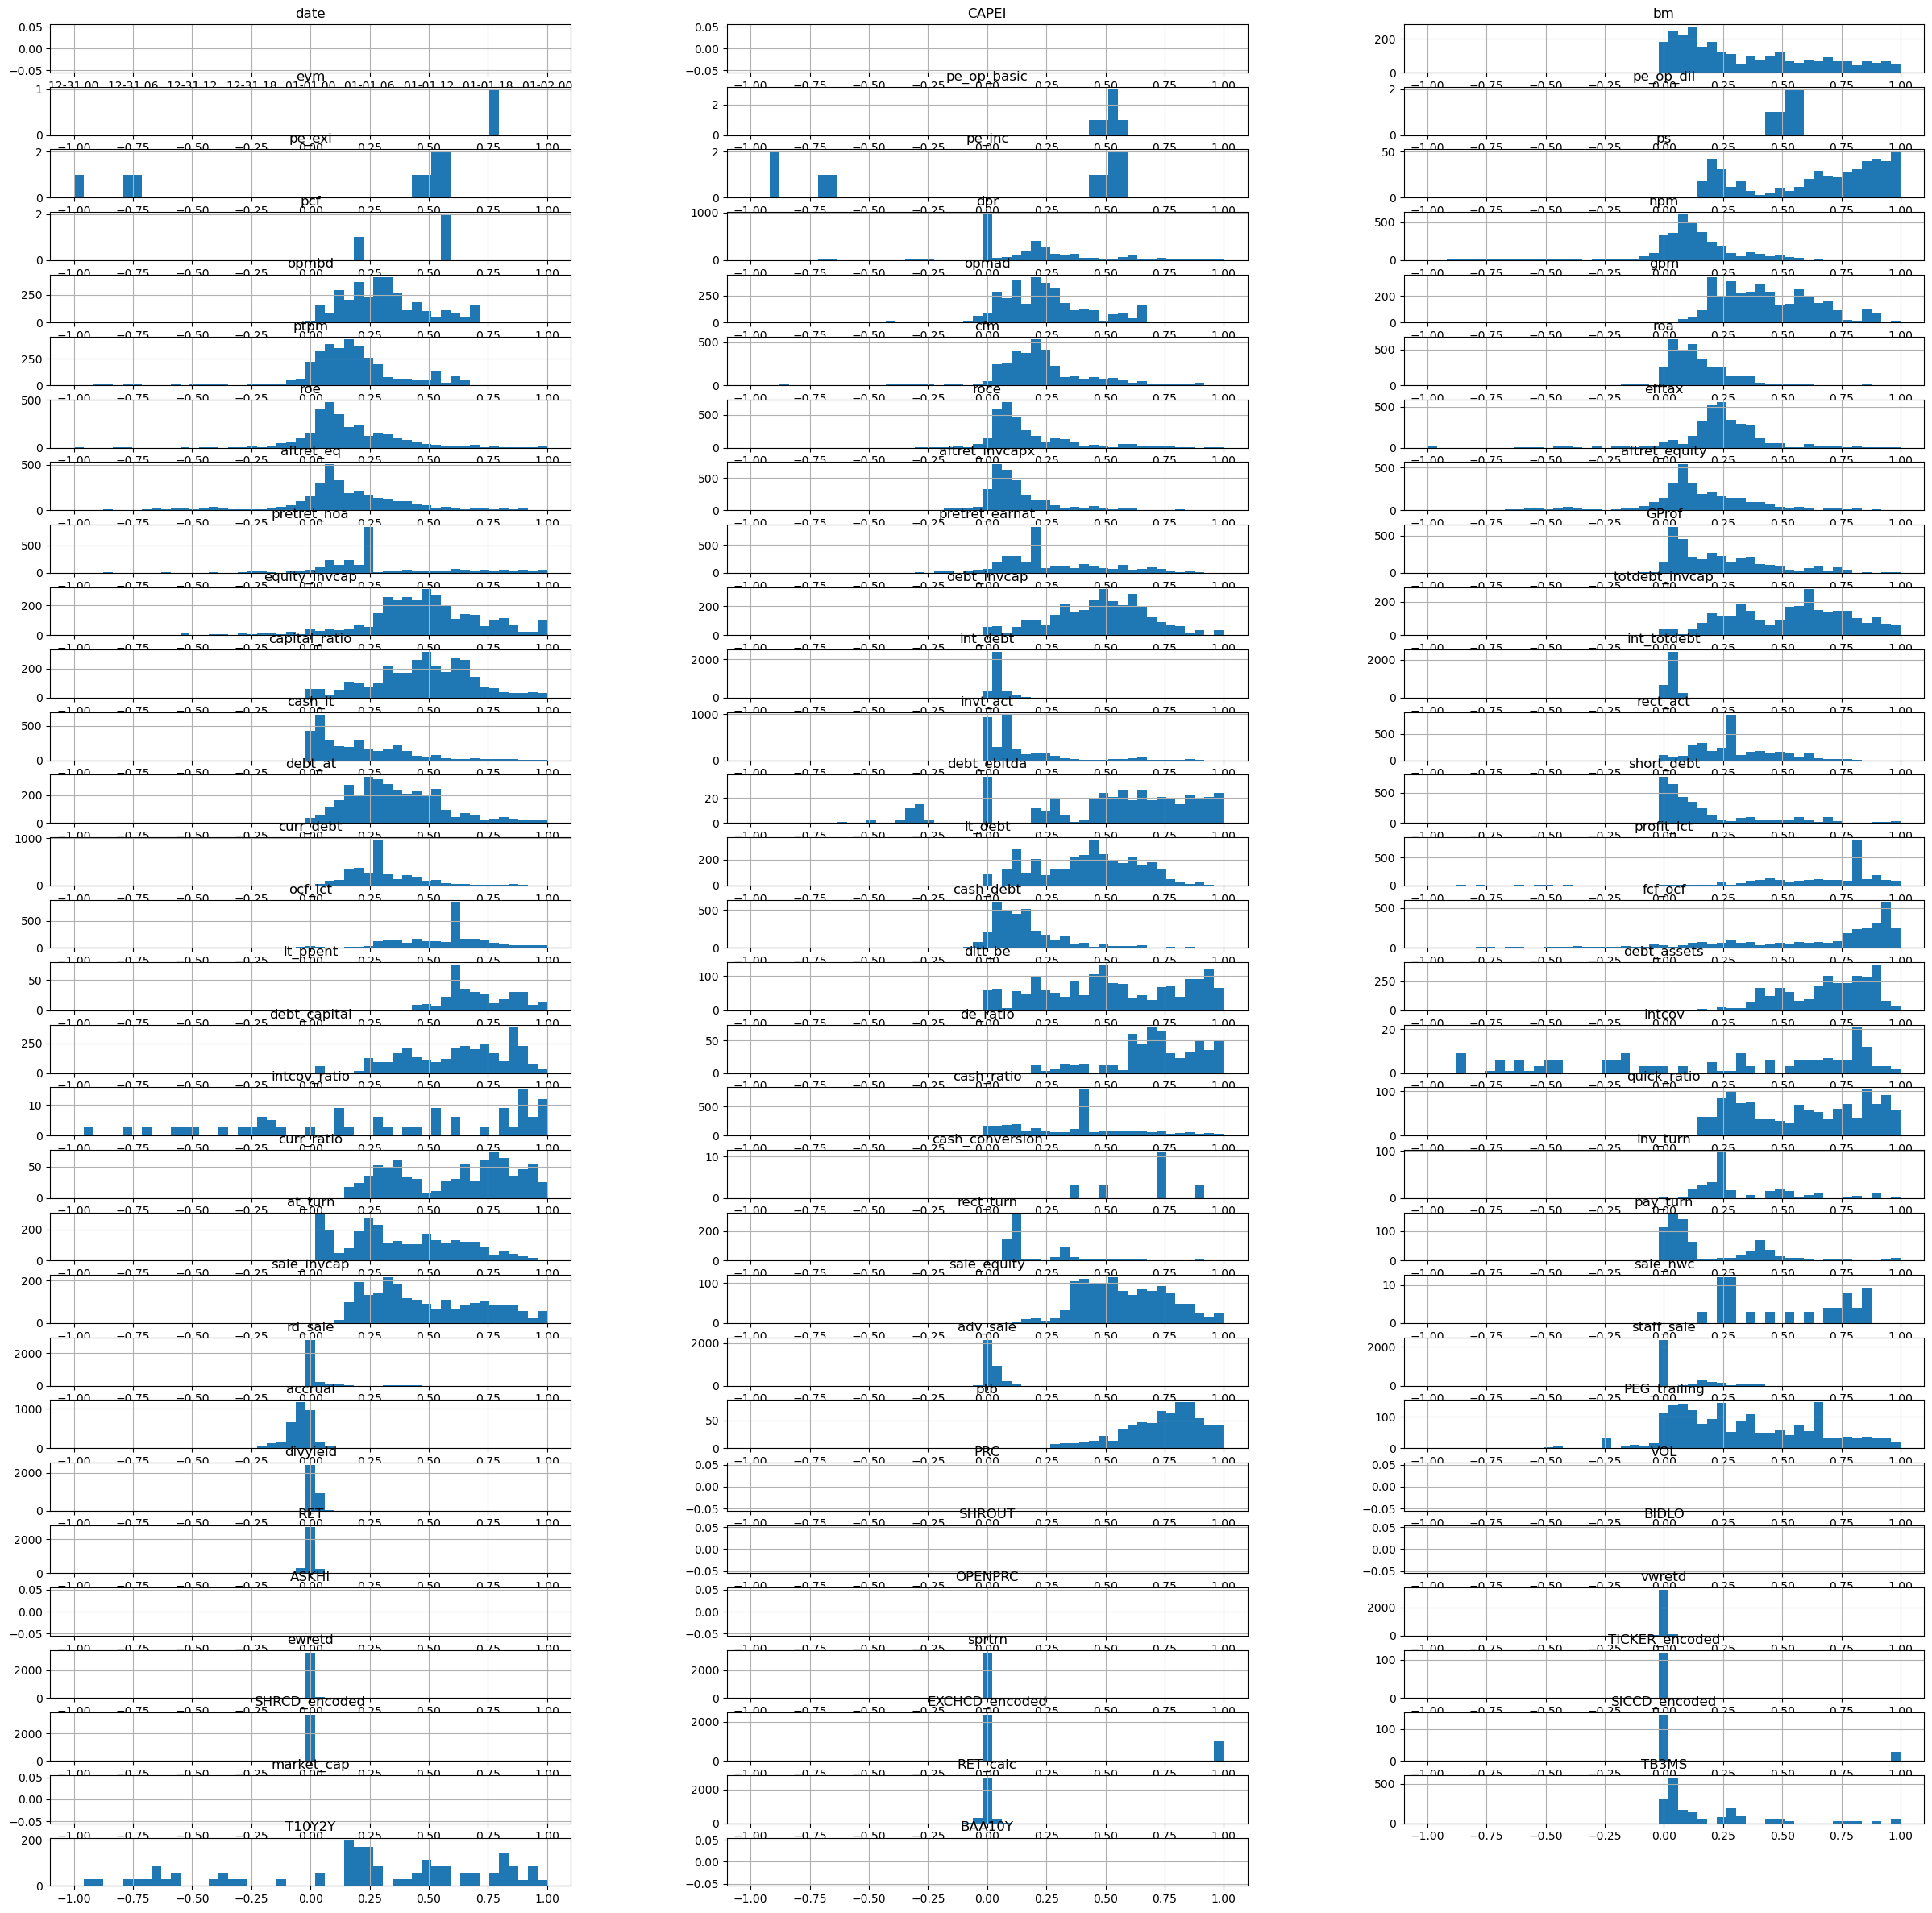

In [366]:
fig, ax = plt.subplots()
fig.set_figheight(30)
fig.set_figwidth(30)
desc_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax);
plt.savefig('numbers_over_time.png')


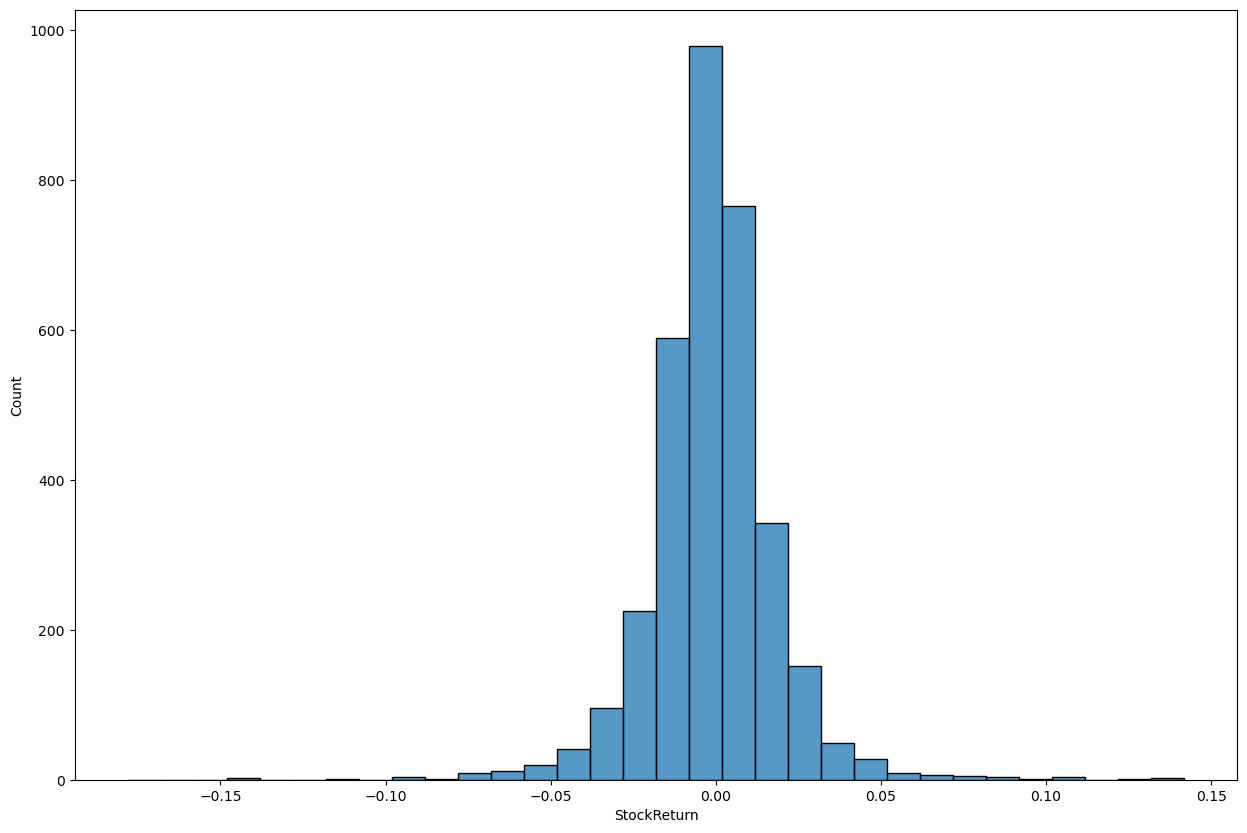

In [367]:
df_3 = desc_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.savefig('stock_return.png')


In [68]:
desc_data.columns

Index(['TICKER', 'date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'COMNAM',
       'SHRCD', 'EXCHCD', 'SICCD', 'PRC', 'VOL', 'RET

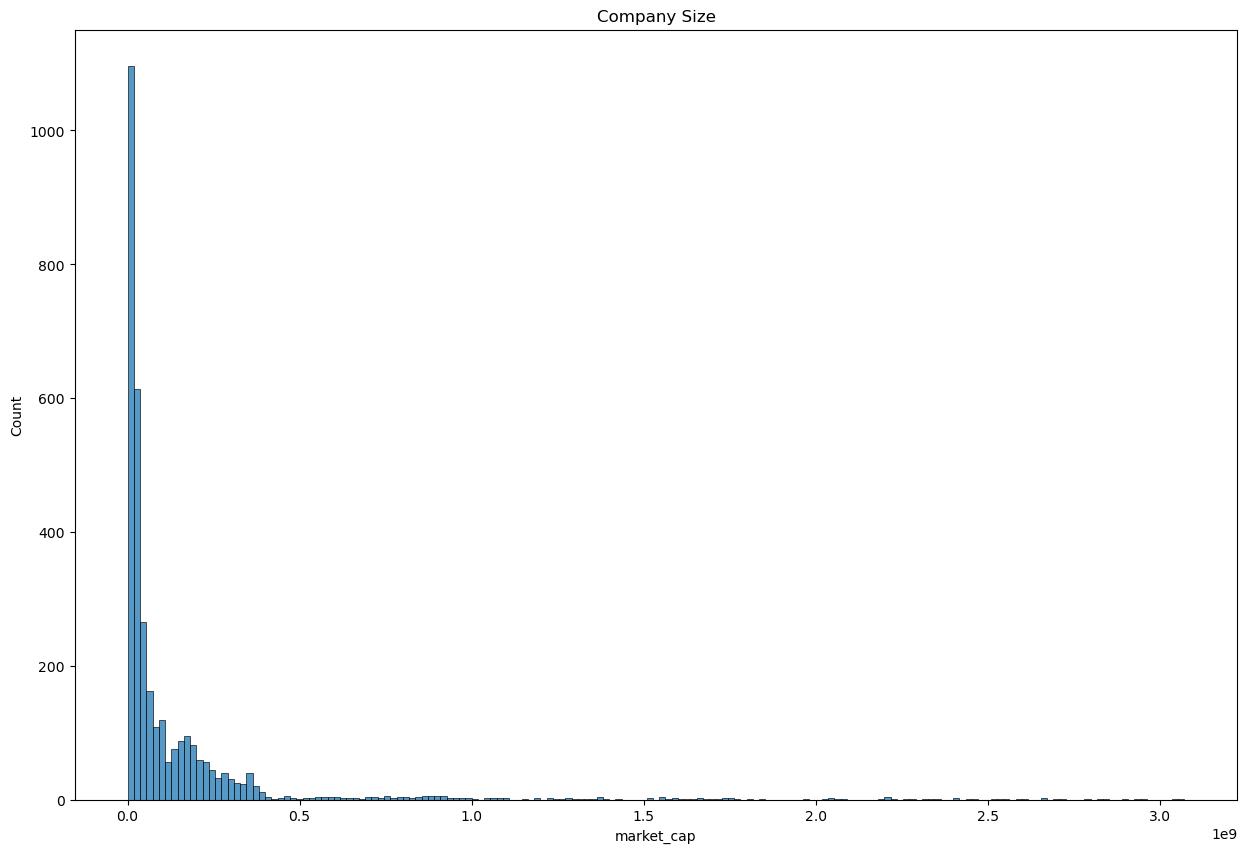

In [370]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图形的全局大小
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

# 计算最大市值
max_size = desc_data['market_cap'].max()

# 绘制直方图
ax = sns.histplot(data=desc_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Company Size')  # 设置标题

# 保存图像到当前文件夹
plt.savefig('size_distribution.png')  # 确保文件名没有拼写错误

plt.savefig('company_size.png')

# 显示图形
plt.show()


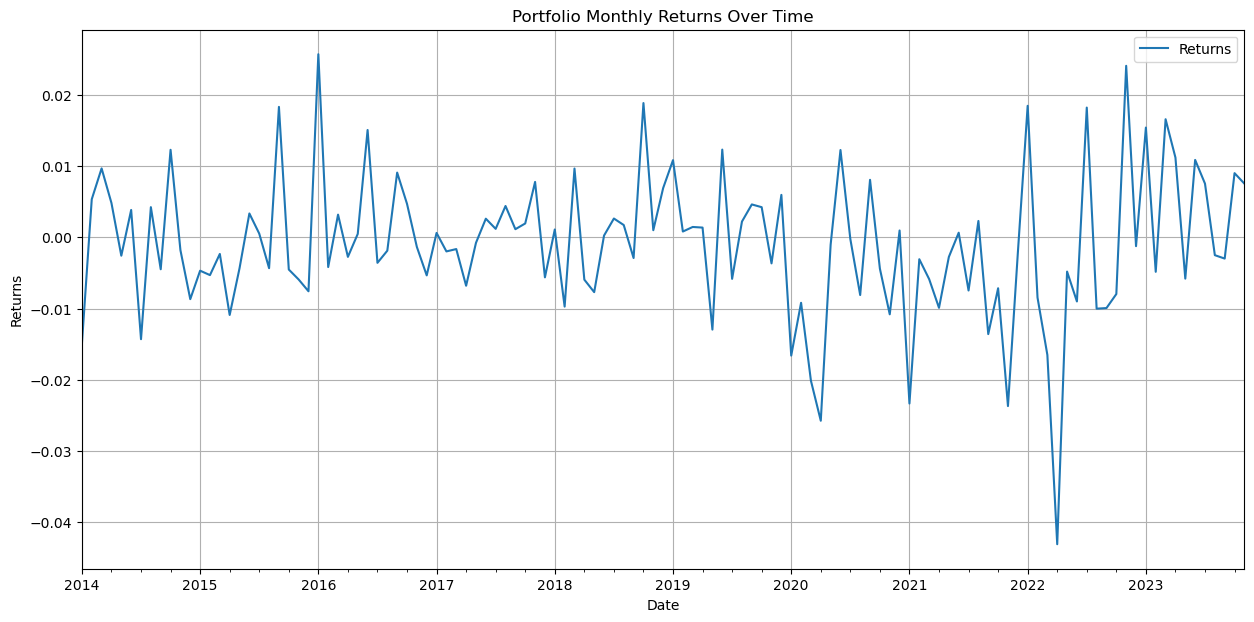

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming final_data is defined
ret_data = desc_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.savefig('portfolio monthly returns over time.png')


In [71]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

number_columns = desc_data.select_dtypes(include=['number'])
c = number_columns.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort").reset_index()
so.columns = ['Variable 1','Variable 2', 'corr']
so = so.sort_values(by = ['corr', 'Variable 1'], ascending = False)
so = so[so['corr']!=1]
so = so.iloc[::2].reset_index(drop=True)
so

Variable 1       Variable 2      corr
0                 PRC            BIDLO  0.999953
1             OPENPRC            ASKHI  0.999949
2             OPENPRC            BIDLO  0.999929
3                 PRC            ASKHI  0.999927
4               BIDLO            ASKHI  0.999926
5         debt_invcap    capital_ratio  0.999901
6                 PRC          OPENPRC  0.999865
7       equity_invcap    capital_ratio  0.999674
8       aftret_equity        aftret_eq  0.999612
9       equity_invcap      debt_invcap  0.999499
10        pretret_noa          dltt_be  0.993847
11             vwretd           sprtrn  0.992104
12                evm      debt_ebitda  0.989464
13     totdebt_invcap      debt_invcap  0.983553
14     totdebt_invcap    capital_ratio  0.983207
15     totdebt_invcap    equity_invcap  0.983149
16       intcov_ratio           intcov  0.981802
17               ptpm              npm  0.967737
18          pe_op_dil      pe_op_basic  0.954669
19        quick_ratio       curr_ratio  0.942277
20               ptpm            opmad  0.928062
21              opmbd            opmad  0.924950
22             pe_inc           pe_exi  0.909373
23         profit_lct          ocf_lct  0.896537
24              opmad              npm  0.895607
25             vwretd           ewretd  0.889216
26                roe          dltt_be  0.883223
27                npm              cfm  0.872927
28                VOL           SHROUT  0.871063
29            fcf_ocf              evm  0.868528
30                roe      pretret_noa  0.848016
31            fcf_ocf      debt_ebitda  0.847246
32              TB3MS           T10Y2Y  0.843568
33       debt_capital      debt_assets  0.842143
34             sprtrn           ewretd  0.835620
35               ptpm              cfm  0.835145
36              opmbd              cfm  0.831848
37               ptpm            opmbd  0.821283
38           RET_calc              RET  0.814597
39              opmbd              npm  0.805908
40            at_turn            GProf  0.805828
41        quick_ratio       cash_ratio  0.792923
42              opmad              cfm  0.787057
43               roce              roa  0.766116
44               roce     debt_capital  0.756892
45                 ps          cash_lt  0.756055
46          rect_turn            ASKHI  0.755859
47          rect_turn              PRC  0.755786
48          rect_turn          OPENPRC  0.755679
49          rect_turn            BIDLO  0.755569
50        sale_invcap      debt_invcap  0.753813
51         curr_ratio       cash_ratio  0.752950
52        sale_invcap    capital_ratio  0.752394
53               roce   aftret_invcapx  0.752151
54     totdebt_invcap      sale_invcap  0.751376
55        sale_invcap    equity_invcap  0.749091
56                roa        cash_debt  0.724617
57                roa            GProf  0.718498
58         staff_sale       short_debt  0.706262
59            rd_sale          cash_lt  0.701718
60            debt_at      debt_assets  0.687813
61         staff_sale          lt_debt  0.670236
62         short_debt          lt_debt  0.669753
63     pretret_earnat            opmad  0.667445
64       debt_capital   aftret_invcapx  0.662760
65        quick_ratio          cash_lt  0.656491
66         market_cap           SHROUT  0.654461
67               ptpm   pretret_earnat  0.642686
68            lt_debt          debt_at  0.640915
69            rd_sale               ps  0.635160
70              opmad              gpm  0.627970
71              opmbd              gpm  0.626490
72         cash_ratio          cash_lt  0.620767
73                 bm            GProf  0.616300
74       debt_capital          debt_at  0.608088
75        sale_invcap          at_turn  0.604945
76           rect_act         invt_act  0.601671
77        sale_invcap            GProf  0.598821
78     pretret_earnat              npm  0.598755
79        debt_invcap   aftret_invcapx  0.583147
80      capital_ratio   aftret_invcapx  0.

## 3.2 Feature Engineering

In [1312]:
df = pd.read_csv('merged_financial_stock_macro_data_with_better_features.csv', index_col=0)

In [1313]:
# df = final_data.copy()

In [1314]:
df['date'] = pd.to_datetime(df['date'])

In [1315]:
# 确保数据按 TICKER 和 date 排序
df = df.sort_values(['TICKER', 'date'])

In [1316]:
# df.reset_index(inplace = True)

# df.set_index(['index'], inplace=True)


In [1317]:
df.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3342, 3343, 3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351],
           dtype='int64', length=3352)

In [1048]:
# existing_vars = [
#     'market_cap',  # ME (Market Equity)
#     'bm',          # Book-to-Market
#     'pe_op_basic', # E2P (inverse)
#     'pe_op_dil',   # Another version of E2P (inverse)
#     'npm',         # Similar to PM (Profit Margin)
#     'gpm',         # Similar to PCM (Price-to-Cost Margin)
#     'roa',         # Return on Assets
#     'roe',         # Return on Equity
#     'ps',          # Price to Sales (inverse of S2P)
#     'debt_assets', # Similar to Lev (Leverage)
#     'at_turn',     # Similar to ATO (Asset Turnover)
#     'accrual',     # Might correspond to OA (Operating Accruals)
#     'divyield',    # Dividend Yield
# ]
# benchmark = ['Size','Momentum','bm']

Green et al. (2017)的94个指标部分
Welch and Goyal (2008) 宏观指标：Treasury-bill rate (tbl), term spread (tms), default spread (dfy)

市场相关指标:


ME (Market Equity): 公司层面的总市值
LME: 上个月月末的总市值
LTurnover: 上月总交易量与上月月末总市值的比率
Spread: 上月日均买卖价差
Beta: 根据Frazzini和Pedersen (2014)的定义计算的贝塔值
Idio vol (Idiosyncratic Volatility): 基于Ang等(2006)方法计算的特异波动率



历史回报指标:


r2−1: 上个月的滞后回报
r12−2: 过去12个月(不包括最后一个月)的回报
r12−7: 中期动量(过去12个月到过去7个月的回报)
r36−13: 长期回报(3年前到去年的回报)


财务报表指标:


BE (Book Equity): 账面权益
BM (Book-to-Market): 账面市值比
AT: 总资产
ATO: 销售额除以净营运资产
C (Cash): 现金和短期投资占总资产比例
CTO: 资本周转率
D2A: 折旧和摊销占总资产比例
DPI2A: 固定资产变动
E2P: 市盈率的倒数
FC2Y: 费用销售比(广告、研发、销售管理费用总和除以销售额)
Free CF: 自由现金流
Investment: 总资产增长率
Lev: 杠杆率(总债务/(总债务+股东权益))
NOA: 净营运资产占滞后总资产比例
OA: 营运应计项目(根据Sloan (1996)定义)
OL: 营运杠杆(销货成本和销售管理费用除以总资产)
PCM: 价格成本利润率((销售额-销货成本)/销售额)
PM: 营业利润率(折旧后营业收入/净销售额)
Prof: 毛利润率(毛利润/权益账面价值)
Q: 托宾Q值
Rel to high: 接近52周最高价的程度
RNA: 净营运资产回报率
ROA: 资产回报率(税前利润/总资产)
ROE: 权益回报率(税前利润/滞后权益账面价值)
S2P: 销售额市值比
SGA2S: 销售管理费用率(销售管理费用/净销售额)
SUV: 标准化非预期交易量

根据Gu 2020年的论文，我们可以将特征分为以下几类：

基准特征（3个）：

规模（Size）
账面市值比（Book-to-Market ratio）
动量（Momentum）


股票水平预测器（主要分为三类）：
a. 价格趋势变量：

股票动量
行业动量
短期反转
b. 流动性变量：
市值
美元交易量
买卖价差
c. 波动性相关：
回报波动率
特质波动率
市场beta
beta平方


宏观经济预测器（8个）：

股息-价格比（Dividend-Price Ratio, dp）
收益-价格比（Earnings-Price Ratio, ep）
账面市值比（Book-to-Market Ratio, bm）
净股票发行（Net Equity Expansion, ntis）
国库券利率（Treasury-bill Rate, tbl）
期限利差（Term Spread, tms）
违约利差（Default Spread, dfy）
股票方差（Stock Variance, svar）


94个预测特征（基于Green et al. (2017)）

处理步骤：

基准特征和主要股票水平预测器：
这些特征大多可以从CRSP数据中直接计算或提取。
宏观经济预测器：
这些需要额外的宏观经济数据源，可能需要从Federal Reserve Economic Data (FRED)或其他经济数据库获取。
94个预测特征：
这些特征基于Green et al. (2017)，需要使用财务报表数据（如Compustat）结合市场数据来计算。
数据对齐：

月度特征：使用t月末的数据预测t+1月的回报
季度特征：使用至少4个月前的数据
年度特征：使用至少6个月前的数据


处理缺失值：
对于缺失的特征，使用每个月每只股票的横截面中位数进行填充

根据您提供的信息，我将帮您整理需要的变量、已有的变量和缺失的变量。

1. 需要的变量（基于您的要求）：

a. 基准特征：
   - Size (已有)
   - Book-to-Market ratio (已有，对应 'bm')
   - Momentum (已有)

b. 股票水平预测器：
   - 股票动量 (已有，对应 'Momentum')
   - 行业动量 (缺失)
   - 短期反转 (已有，对应 'ShortTermReversal')
   - 市值 (已有，对应 'ME' 或 'market_cap')
   - 美元交易量 (已有，对应 'DollarVolume')
   - 买卖价差 (已有，对应 'spread')
   - 回报波动率 (可以从 'RET' 计算)
   - 特质波动率 (已有，对应 'Idio_vol')
   - 市场beta (已有，对应 'Beta')
   - beta平方 (已有，对应 'BetaSquared')

c. 宏观经济预测器：
   - 股息-价格比 (dp) (已有，对应 'divyield')
   - 收益-价格比 (ep) (可以从 'pe_op_basic' 或 'pe_op_dil' 的倒数得到)
   - 账面市值比 (bm) (已有)
   - 净股票发行 (ntis) (缺失)
   - 国库券利率 (tbl) (可能对应 'TB3MS'，需确认)
   - 期限利差 (tms) (可能对应 'T10Y2Y'，需确认)
   - 违约利差 (dfy) (可能对应 'BAA10Y'，需确认)
   - 股票方差 (svar) (可以从 'RET' 计算)

2. 已有的重要变量（除上述外）：
   - 'roa', 'roe', 'roce' (盈利能力指标)
   - 'debt_assets', 'debt_capital', 'de_ratio' (杠杆指标)
   - 'cash_ratio', 'quick_ratio', 'curr_ratio' (流动性指标)
   - 'at_turn', 'inv_turn' (效率指标)
   - 'accrual' (质量指标)
   - 'PRC', 'VOL', 'SHROUT' (价格、交易量、股数)
   - 'vwretd', 'ewretd', 'sprtrn' (市场回报指标)

3. 缺失的重要变量：
   - 行业动量
   - 净股票发行 (ntis)

4. 可能不需要的变量（这取决于您的具体研究目的，但这些变量可能与其他变量重复或不太常用）：
   - 'CAPEI' (如果有 'pe_op_basic' 或 'pe_op_dil')
   - 'evm' (如果已有 'bm')
   - 'pe_exi', 'pe_inc' (如果已有 'pe_op_basic' 或 'pe_op_dil')
   - 'ptpm' (如果已有 'npm')
   - 'pcf' (如果已有 'ps' 和 'cfm')
   - 'aftret_eq', 'aftret_invcapx', 'aftret_equity' (如果已有 'roe' 和 'roce')
   - 'pretret_noa', 'pretret_earnat' (如果已有其他盈利能力指标)
   - 'equity_invcap', 'debt_invcap', 'totdebt_invcap' (如果已有 'debt_capital' 和 'de_ratio')
   - 'intcov', 'intcov_ratio' (可能重复)
   - 'sale_invcap', 'sale_equity', 'sale_nwc' (如果已有 'ps' 和其他效率指标)
   - 'int_debt', 'int_totdebt' (如果已有其他债务指标)
   - 'invt_act', 'rect_act' (如果已有 'curr_ratio' 和 'quick_ratio')
   - 'short_debt', 'curr_debt', 'lt_debt' (如果已有 'debt_assets' 和 'debt_capital')
   - 'ptb' (如果已有 'bm')
   - 'PEG_trailing' (如果已有 'pe_op_basic' 或 'pe_op_dil' 和增长率指标)

对于缺失的变量和需要计算的变量，您可能需要获取额外的数据或使用现有数据进行计算。例如，行业动量可能需要行业分类数据，而回报波动率和股票方差可以使用现有的回报数据计算。

In [1318]:
def calculate_variables(df):
    # 0 benchmark
    df['BM'] = df['bm']
    
    # ME (Market Equity)
    df['ME'] = df['market_cap']
    # Size (natural log of ME)
    df['Size'] = np.log(df['ME'])
    
    # Momentum (11-month return, 1 month ago)
    def calculate_momentum(group):
        return group.rolling(window=11).apply(lambda x: (1 + x).prod() - 1).shift(1)

    df['Momentum'] = df.groupby('TICKER')['RET'].transform(calculate_momentum)

    # 1 市场相关指标
    # 短期反转（过去1个月的回报）
    df['ShortTermReversal'] = df.groupby('TICKER')['RET'].shift(1)
    
    # # 计算市值
    # df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    
    # # LME (Lagged Market Equity) 上个月月末的总市值
    # df['LME'] = df.groupby('TICKER')['market_cap'].shift(1)
    
    # # LTurnover 上月总交易量与上月月末总市值的比率
    # df['LTurnover'] = df['VOL'] / df['LME']
    
    # # 美元交易量
    # df['DollarVolume'] = df['PRC'].abs() * df['VOL']

    # # Spread 上月日均买卖价差
    # df['spread'] = (df['ASKHI'] - df['BIDLO']) / ((df['ASKHI'] + df['BIDLO']) / 2)
    
    # # 计算20天滚动标准差
    # df['Volatility'] = df.groupby('TICKER')['RET'].transform(lambda x: x.rolling(window=20, min_periods=1).std())
    # # 处理可能的 NaN 值
    # df['Volatility'] = df['Volatility'].fillna(0)

    # 重置索引
    # df_reset = df.reset_index()
    
    # # Beta (simplified version) 用滚动算
    # def calculate_beta(stock_returns, market_returns, window=52):
    #     return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]))
    
    # df_reset['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))

    # # 计算Beta平方
    # df_reset['BetaSquared'] = df_reset['Beta'] ** 2

    # df['Beta'] = df_reset['Beta']
    # df['BetaSquared'] = df_reset['BetaSquared']


    # 2 历史回报指标
    # # Historical returns
    # df['r2_1'] = df.groupby('TICKER')['RET'].shift(1)

    # # 计算 r12_2
    # df_reset['r12_2'] = df_reset.groupby('TICKER')['RET'].rolling(window=11).sum().shift(1).reset_index(0, drop=True)
    # df_reset['r12_7'] = df_reset.groupby('TICKER')['RET'].rolling(window=6).sum().shift(6).reset_index(0, drop=True)
    # df_reset['r36_13'] = df_reset.groupby('TICKER')['RET'].rolling(window=24).sum().shift(12).reset_index(0, drop=True)

    # # 设置回原来的索引
    # df_reset.set_index('index', inplace=True)
    
    # # 将结果赋值给原始 DataFrame
    # df['r12_2'] = df_reset['r12_2']
    # df['r12_7'] = df_reset['r12_7']
    # df['r36_13'] = df_reset['r36_13']

    # df['RET_lag_1_mon'] = df.groupby('TICKER')['RET'].shift(1)

    # 3 财务报表指标
    
    # # 重置索引
    # df_reset = df.reset_index()
    
    # # 确保 'DATE' 列是 datetime 类型
    # df_reset['date'] = pd.to_datetime(df_reset['date'])
    
    # # 设置 'DATE' 列为索引
    # df_reset.set_index('date', inplace=True)
    
    # # 确保索引是升序排列的
    # df_reset.sort_index(inplace=True)

    # # Rel to high 接近52周最高价的程度
    # df_reset['52_week_high'] = df_reset.groupby('TICKER')['PRC'].rolling(window=52).max().reset_index(0, drop=True)
    
    # # 计算 Rel_to_high
    # df_reset['Rel_to_high'] = df_reset['PRC'] / df_reset['52_week_high']
    
    # 设置回原来的索引
    # df_reset.set_index('index', inplace=True)
    # print(df_reset['52_week_high'].isnull().sum())
    
    # # 将结果赋值给原始 DataFrame
    # df['52_week_high'] = df_reset['52_week_high']
    # df['Rel_to_high'] = df_reset['Rel_to_high']
    
    # SUV (Standardized Unexplained Volume)
    # def calculate_suv(volume, window=20):
    #     log_volume = np.log(volume)
    #     mean_log_volume = log_volume.rolling(window=window).mean()
    #     std_log_volume = log_volume.rolling(window=window).std()
    #     return (log_volume - mean_log_volume) / std_log_volume
    
    # df['SUV'] = df.groupby('TICKER')['VOL'].apply(calculate_suv)
    
    return df

# Apply the function to your dataframe
df = calculate_variables(df)

In [1319]:
# 计算缺失值统计，转换为 DataFrame
null_summary = pd.DataFrame(df.isnull().sum(), columns=['MissingValueCount'])

# 使用 option_context 临时改变显示设置并直接显示 DataFrame
with pd.option_context('display.max_columns', None,  'display.max_colwidth', 20):
    display(null_summary)

null_summary.to_csv("missing_value_summary.csv")


MissingValueCount
TICKER                             0
date                               0
CAPEI                              0
bm                                 0
evm                                0
pe_op_basic                        0
pe_op_dil                          0
pe_exi                             0
pe_inc                             0
ps                                 0
pcf                                0
dpr                                0
npm                                0
opmbd                              0
opmad                              0
gpm                                0
ptpm                               0
cfm                                0
roa                                0
roe                                0
roce                               0
efftax                             0
aftret_eq                          0
aftret_invcapx                     0
aftret_equity                      0
pretret_noa                        0
pretret_earnat                     0
GProf                              0
equity_invcap                      0
debt_invcap                        0
totdebt_invcap                     0
capital_ratio                      0
int_debt                           0
int_totdebt                        0
cash_lt                            0
invt_act                           0
rect_act                           0
debt_at                            0
debt_ebitda                        0
short_debt                         0
curr_debt                          0
lt_debt                            0
profit_lct                         0
ocf_lct                            0
cash_debt                          0
fcf_ocf                            0
lt_ppent                           0
dltt_be                            0
debt_assets                        0
debt_capital                       0
de_ratio                           0
intcov                             0
intcov_ratio                       0
cash_ratio                         0
quick_ratio                        0
curr_ratio                         0
cash_conversion                    0
inv_turn                           0
at_turn                            0
rect_turn                          0
pay_turn                           0
sale_invcap                        0
sale_equity                        0
sale_nwc                           0
rd_sale                            0
adv_sale                           0
staff_sale                         0
accrual                            0
ptb                                0
PEG_trailing                       0
divyield                           0
COMNAM                             7
SHRCD                              7
EXCHCD                             7
SICCD                              7
PRC                                7
VOL                                7
RET                                7
SHROUT                             7
BIDLO                              7
ASKHI                              7
OPENPRC                            7
vwretd                             7
ewretd                             7
sprtrn                             7
TICKER_encoded                     7
SHRCD_encoded                      7
EXCHCD_encoded                     7
SICCD_encoded                      7
market_cap                         7
RET_calc                           7
RET_interp                         7
LME                               33
LTurnover                         33
DollarVolume                       7
spread                            33
Volatility                         7
Beta                             381
BetaSquared                      381
r2_1                               7
r12_2                              7
r12_7                              7
r36_13                            33
RET_lag_1_mon                      7
52_week_high                     371
Rel_to_high                      371
SUV                                7
idio_vol               

In [1320]:
# 处理无穷大和NaN值
df = df.replace([np.inf, -np.inf], np.nan)

In [1321]:
def clean_and_fill_numeric(df, var):
    # 尝试将数据转换为数值型
    df[var] = pd.to_numeric(df[var], errors='coerce')    
    return df
    
# 对每个需要处理的变量应用此函数
variables_to_clean = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'sprtrn', 'RET', 'RET_lag_1_mon']  # 添加所有需要处理的变量
for var in variables_to_clean:
    df = clean_and_fill_numeric(df, var)

In [1322]:
def handle_missing_values(df):
    # 对历史回报指标使用前向填充
    historical_returns = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'ShortTermReversal', 'LME', 'LTurnover', 'r2_1', 'RET_lag_1_mon']
    df[historical_returns] = df.groupby('TICKER')[historical_returns].fillna(method='ffill')
    df[historical_returns] = df.groupby('TICKER')[historical_returns].fillna(method='bfill')
    df[historical_returns] = df[historical_returns].fillna(df[historical_returns].median())

    
    # 对交易相关指标使用中位数填充
    trading_indicators = ['DollarVolume', 'spread']
    df[trading_indicators] = df[trading_indicators].fillna(df[trading_indicators].median())
    
    # 对SUV使用0填充
    df['SUV'] = df['SUV'].fillna(0)
    
    return df

# 应用函数
df = handle_missing_values(df)

In [1323]:
df.dtypes

TICKER                       object
date                 datetime64[ns]
CAPEI                       float64
bm                          float64
evm                         float64
pe_op_basic                 float64
pe_op_dil                   float64
pe_exi                      float64
pe_inc                      float64
ps                          float64
pcf                         float64
dpr                         float64
npm                         float64
opmbd                       float64
opmad                       float64
gpm                         float64
ptpm                        float64
cfm                         float64
roa                         float64
roe                         float64
roce                        float64
efftax                      float64
aftret_eq                   float64
aftret_invcapx              float64
aftret_equity               float64
pretret_noa                 float64
pretret_earnat              float64
GProf                       

In [1324]:
print(df.head())  # 检查前几行数据
print(df.isnull().sum())  # 计算NaN的数量


  TICKER       date   CAPEI     bm    evm  pe_op_basic  pe_op_dil  pe_exi  \
0   AAPL 2014-01-31  17.588  0.327  7.993       12.506     12.594  12.594   
1   AAPL 2014-02-28  18.776  0.296  7.764        0.463      0.466   0.466   
2   AAPL 2014-03-31  18.501  0.296  7.764        0.472      0.475   0.475   
3   AAPL 2014-04-30  20.332  0.296  7.764        0.519      0.523   0.523   
4   AAPL 2014-05-31  20.513  0.302  7.873        0.537      0.540   0.540   

   pe_inc     ps     pcf    dpr    npm  opmbd  opmad    gpm   ptpm    cfm  \
0  12.594  2.613   8.321  0.288  0.217  0.326  0.287  0.416  0.293  0.256   
1   0.466  2.698   8.872  0.293  0.213  0.325  0.283  0.416  0.288  0.255   
2   0.475  2.658   8.742  0.293  0.213  0.325  0.283  0.416  0.288  0.255   
3   0.523  2.921   9.607  0.293  0.213  0.325  0.283  0.416  0.288  0.255   
4   0.540  3.097  10.108  0.292  0.214  0.328  0.286  0.421  0.290  0.257   

     roa    roe   roce  efftax  aftret_eq  aftret_invcapx  aftret_equity  

In [1325]:
df.sort_values(['date']).head()

TICKER       date      CAPEI     bm        evm  pe_op_basic  pe_op_dil  \
0      AAPL 2014-01-31   17.58800  0.327   7.993000       12.506    12.5940   
2968   TMUS 2014-01-31   60.99635  0.905  -1.547168       89.833    89.8765   
2774   SIRI 2014-01-31 -515.97000  0.119  17.984000       44.750    44.7500   
231    AMZN 2014-01-31  263.76400  0.063  35.043000       61.843    64.0520   
2636    OXY 2014-01-31   14.16400  0.661   5.379000       15.444    15.4440   

        pe_exi    pe_inc        ps        pcf       dpr       npm     opmbd  \
0      12.5940   12.5940  2.613000   8.321000  0.288000  0.217000  0.326000   
2968  229.5395  233.0395  5.032148  14.877818  3.512014  0.166957  0.344989   
2774   51.1430   51.1430  5.913000  21.040000  0.795000  0.127000  0.345000   
231    64.0520   64.0520  2.349000  33.092000  0.000000  0.002000  0.053000   
2636   15.2300   15.3630  2.850000   5.533000  0.413000  0.190000  0.575000   

         opmad       gpm      ptpm       cfm       roa       roe      roce  \
0     0.287000  0.416000  0.293000  0.256000  0.291000  0.272000  0.379000   
2968  0.368113  0.570434  0.274577  0.243738  0.174937  0.281647  0.301722   
2774  0.274000  0.641000  0.190000  0.197000  0.142000  0.123000  0.158000   
231   0.011000  0.308000  0.004000  0.044000  0.131000  0.016000  0.057000   
2636  0.295000  0.575000  0.314000  0.405000  0.214000  0.099000  0.149000   

        efftax  aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
0     0.262000   0.306000        0.281000       0.306000        1.213   
2968 -0.205681   0.117296        0.200664       0.126593        3.059   
2774 -6.319000   0.123000        0.109000       0.123000        0.922   
231   1.100000   0.016000        0.024000       0.016000        0.085   
2636  0.402000   0.114000        0.088000       0.114000        0.131   

      pretret_earnat     GProf  equity_invcap  debt_invcap  totdebt_invcap  \
0              0.601  0.343000       0.879000     0.121000         0.12100   
2968           0.757  0.292945       0.216195     0.701095         0.95253   
2774           0.301  0.266000       0.552000     0.448000         0.47000   
231            0.031  0.705000       0.727000     0.273000         0.41900   
2636           0.114  0.211000       0.853000     0.145000         0.15700   

      capital_ratio  int_debt  int_totdebt   cash_lt  invt_act  rect_act  \
0          0.121000     0.016        0.016  0.486000     0.024     0.282   
2968       0.737393     0.038        0.036  0.359203     0.000     0.302   
2774       0.448000     0.081        0.077  0.097000     0.010     0.112   
231        0.273000     0.040        0.026  0.392000     0.322     0.146   
2636       0.145000     0.018        0.017  0.105000     0.125     0.490   

       debt_at  debt_ebitda  short_debt  curr_debt   lt_debt  profit_lct  \
0     0.082000        0.304    0.000000      0.523  0.203000       1.277   
2968  0.257075        2.890    0.187498      0.430  0.315996       1.042   
2774  0.331000        2.316    0.047000      0.435  0.518000       0.539   
231   0.162000        1.340    0.228000      0.730  0.147000       0.231   
2636  0.114000        0.541    0.079000      0.318  0.277000       1.749   

      ocf_lct  cash_debt   fcf_ocf   lt_ppent   dltt_be  debt_assets  \
0       1.229   0.643000  0.848000   5.028000  0.121000     0.403000   
2968    0.769   0.232149  1.433833  63.748344 -1.525986     0.680564   
2774    0.440   0.161000  0.863000   3.511000  0.811000     0.610000   
231     0.310   0.172000  0.078000   2.625000  0.376000     0.719000   
2636    1.567   0.468000  0.281000   0.472000  0.146000     0.379000   

      debt_capital  de_ratio      intcov  intcov_ratio  cash_ratio  \
0         0.241000  0.675000  273.331000       360.287       0.929   
2968      0.749107  0.037883   17.556947        25.390       0.537   
2774      0.502000  1.567000    3.055000         4.442       0.222   
231       0.616000  2.554000    2.023000         5.

In [1408]:
# def clean_and_fill_numeric(df, var):
#     # 尝试将数据转换为数值型
#     df[var] = pd.to_numeric(df[var], errors='coerce')    
#     return df
    
# # 对每个需要处理的变量应用此函数
# variables_to_clean = ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'sprtrn', 'RET', 'RET_lag_1_mon']  # 添加所有需要处理的变量
# for var in variables_to_clean:
#     df = clean_and_fill_numeric(df, var)
    
def handle_remaining_missing_values(df):
    # 处理 Momentum 和长期回报指标
    long_term_vars = ['Momentum', 'r12_2', 'r12_7', 'r36_13']
    for var in long_term_vars:
        df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
        df[var] = df[var].fillna(df[var].median())

    # 获取仍然缺失 Momentum 的公司
    missing_momentum_companies = df[df['Momentum'].isna()]['TICKER'].unique()
    # 使用行业平均值填充
    df['Momentum'] = df.groupby('SICCD')['Momentum'].transform(lambda x: x.fillna(x.mean()))
    # 用总体平均值填充
    df['Momentum'] = df['Momentum'].fillna(df['Momentum'].median())

    # 处理短期指标
    short_term_vars = ['ShortTermReversal', 'LME', 'LTurnover', 'r2_1']
    df[short_term_vars] = df.groupby('TICKER')[short_term_vars].fillna(method='ffill')
    df[short_term_vars] = df.groupby('TICKER')[short_term_vars].fillna(method='bfill')
    df[short_term_vars] = df[short_term_vars].fillna(df[short_term_vars].median())

    for var in short_term_vars:
        df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
    
    # 重新计算 Beta 和相关指标
    def calculate_beta(stock_returns, market_returns, window=52):
        return stock_returns.rolling(window=window).apply(lambda x: np.cov(x, market_returns[-window:])[0,1] / np.var(market_returns[-window:]))

    df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))
    df['BetaSquared'] = df['Beta'] ** 2
    
    # 对Beta相关指标使用行业平均值填充
    beta_indicators = ['Beta', 'BetaSquared','idio_vol']
    for indicator in beta_indicators:
        df[indicator] = df.groupby('SICCD')[indicator].transform(lambda x: x.fillna(x.median()))
    
    # 如果仍有缺失值（例如，某些公司可能全部为NaN），使用整体中位数填充
    for indicator in beta_indicators:
        df[indicator] = df[indicator].fillna(df[indicator].median())
    
    # 用行业中位数
    # df[indicator] = df.groupby('SICCD')[indicator].transform(lambda x: x.fillna(x.mean()))
    # # 如果仍有缺失值，使用整体中位数填充
    # df[indicator] = df[indicator].fillna(df[indicator].median())

    df_temp = pd.DataFrame()    
    
    # 对52周高点相关指标使用3个月高点替代
    df_temp['3_month_high'] = df.groupby('TICKER')['PRC'].rolling(window=63).max().reset_index(0, drop=True)
    df_temp['Rel_to_3month_high'] = df['PRC'] / df_temp['3_month_high']
    
    # 使用 1 个月高点
    df_temp['1_month_high'] = df.groupby('TICKER')['PRC'].rolling(window=21).max().reset_index(0, drop=True)
    df_temp['Rel_to_1month_high'] = df['PRC'] / df_temp['1_month_high']
    
    # 处理可能的缺失值
    df['52_week_high'] = df.groupby('TICKER')['52_week_high'].fillna(method='ffill',limit = 3)
    df['Rel_to_high'] = df.groupby('TICKER')['Rel_to_high'].fillna(method='ffill',limit = 3)

    # 如果还有缺失值，使用3个月高点填充52周高点
    df['52_week_high'] = df['52_week_high'].fillna(df_temp['3_month_high'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(df_temp['Rel_to_3month_high'])

    # 如果还有缺失值，使用1个月高点填充52周高点
    df['52_week_high'] = df['52_week_high'].fillna(df_temp['1_month_high'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(df_temp['Rel_to_1month_high'])

    # 如果还有缺失值，使用当前价格填充52周高点，Rel_to_high填充为1
    df['52_week_high'] = df['52_week_high'].fillna(df['PRC'])
    df['Rel_to_high'] = df['Rel_to_high'].fillna(1)
    
    return df

# 应用函数
df = handle_remaining_missing_values(df)

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/1536590106.py:38: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df['Beta'] = df.groupby('TICKER')['RET'].apply(lambda x: calculate_beta(x, df['sprtrn']))


In [1409]:
pd.DataFrame(df.columns).to_csv('dfcolumns.csv')

In [1410]:
df.columns

Index(['index', 'TICKER', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps',
       ...
       'SUV', 'idio_vol', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'BM', 'ME', 'Size',
       'Momentum', 'ShortTermReversal'],
      dtype='object', length=116)

In [1411]:
df.head() 

index TICKER   CAPEI     bm    evm  pe_op_basic  pe_op_dil  \
date                                                                     
2014-01-31      0   AAPL  17.588  0.327  7.993       12.506     12.594   
2014-02-28      1   AAPL  18.776  0.296  7.764        0.463      0.466   
2014-03-31      2   AAPL  18.501  0.296  7.764        0.472      0.475   
2014-04-30      3   AAPL  20.332  0.296  7.764        0.519      0.523   
2014-05-31      4   AAPL  20.513  0.302  7.873        0.537      0.540   

            pe_exi  pe_inc     ps     pcf    dpr    npm  opmbd  opmad    gpm  \
date                                                                           
2014-01-31  12.594  12.594  2.613   8.321  0.288  0.217  0.326  0.287  0.416   
2014-02-28   0.466   0.466  2.698   8.872  0.293  0.213  0.325  0.283  0.416   
2014-03-31   0.475   0.475  2.658   8.742  0.293  0.213  0.325  0.283  0.416   
2014-04-30   0.523   0.523  2.921   9.607  0.293  0.213  0.325  0.283  0.416   
2014-05-31   0.540   0.540  3.097  10.108  0.292  0.214  0.328  0.286  0.421   

             ptpm    cfm    roa    roe   roce  efftax  aftret_eq  \
date                                                               
2014-01-31  0.293  0.256  0.291  0.272  0.379   0.262      0.306   
2014-02-28  0.288  0.255  0.284  0.258  0.362   0.262      0.291   
2014-03-31  0.288  0.255  0.284  0.258  0.362   0.262      0.291   
2014-04-30  0.288  0.255  0.284  0.258  0.362   0.262      0.291   
2014-05-31  0.290  0.257  0.280  0.260  0.357   0.262      0.295   

            aftret_invcapx  aftret_equity  pretret_noa  pretret_earnat  GProf  \
date                                                                            
2014-01-31           0.281          0.306        1.213           0.601  0.343   
2014-02-28           0.245          0.291        1.106           0.578  0.350   
2014-03-31           0.245          0.291        1.106           0.578  0.350   
2014-04-30           0.245          0.291        1.106           0.578  0.350   
2014-05-31           0.241          0.295        1.121           0.577  0.354   

            equity_invcap  debt_invcap  totdebt_invcap  capital_ratio  \
date                                                                    
2014-01-31          0.879        0.121           0.121          0.121   
2014-02-28          0.910        0.090           0.090          0.090   
2014-03-31          0.910        0.090           0.090          0.090   
2014-04-30          0.910        0.090           0.090          0.090   
2014-05-31          0.880        0.120           0.120          0.120   

            int_debt  int_totdebt  cash_lt  invt_act  rect_act  debt_at  \
date                                                                      
2014-01-31     0.016        0.016    0.486     0.024     0.282    0.082   
2014-02-28     0.017        0.017    0.518     0.024     0.255    0.062   
2014-03-31     0.017        0.017    0.518     0.024     0.255    0.062   
2014-04-30     0.017        0.017    0.518     0.024     0.255    0.062   
2014-05-31     0.018        0.018    0.484     0.025     0.257    0.081   

            debt_ebitda  short_debt  curr_debt  lt_debt  profit_lct  ocf_lct  \
date                                                                           
2014-01-31        0.304         0.0      0.523    0.203       1.277    1.229   
2014-02-28        0.225         0.0      0.538    0.162       1.337    1.250   
2014-03-31        0.225         0.0      0.538    0.162       1.337    1.250   
2014-04-30        0.225         0.0      0.538    0.162       1.337    1.250   
2014-05-31        0.293         0.0      0.519    0.199       1.306    1.219   

            cash_debt  fcf_ocf  lt_ppent  dltt_be  debt_assets  debt_capital  \
date                                                                           
2014-01-31      0.643    0.848     5.028    0.121        0.403         0.241   
2014-02-28      0.643    0.852     4.961    0.08

In [1412]:
result.columns

Index(['Beta', 'Idio_vol', 'date'], dtype='object')

In [1331]:
# df.reset_index(inplace = True)

# df.set_index(['date','TICKER'], inplace=True)

In [1332]:
df['date'].head()

0   2014-01-31
1   2014-02-28
2   2014-03-31
3   2014-04-30
4   2014-05-31
Name: date, dtype: datetime64[ns]

In [1274]:
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm

# def calculate_rolling_beta_and_idio_vol(df, window=60):
#     # 确保 df 是按日期和股票代码排序的
#     df = df.sort_values(['date', 'TICKER'])
    
#     # 计算市场收益率
#     df['market_returns'] = df.groupby('date')['sprtrn'].transform('mean')
    
#     # 计算每支股票的收益率
#     df['stock_returns'] = df.groupby('TICKER')['RET'].pct_change()
    
#     def rolling_regression(group):
#         X = sm.add_constant(group['market_returns'])
#         y = group['stock_returns']
        
#         beta = pd.Series(index=group.index, dtype=float)
#         idio_vol = pd.Series(index=group.index, dtype=float)
        
#         for i in range(window, len(group) + 1):
#             model = sm.OLS(y[i-window:i], X[i-window:i]).fit()
#             beta.iloc[i-1] = model.params['market_returns']
#             idio_vol.iloc[i-1] = np.std(model.resid)
        
#         return pd.DataFrame({'Beta': beta, 'Idio_vol': idio_vol})
    
#     result = df.groupby('TICKER').apply(rolling_regression)
#     result = result.reset_index()
#     result = result.rename(columns={'level_1': 'date'})
    
#     # 合并结果回原始数据框
#     df = pd.merge(df, result, on=['date', 'TICKER'], how='left')
    
#     # 填充缺失值
#     for indicator in ['Beta', 'Idio_vol']:
#         df[indicator] = df.groupby('TICKER')[indicator].transform(lambda x: x.fillna(x.median()))
#         df[indicator] = df[indicator].fillna(df[indicator].median())
    
#     # 处理极端值 (可选)
#     for indicator in ['Beta', 'Idio_vol']:
#         low = df[indicator].quantile(0.01)
#         high = df[indicator].quantile(0.99)
#         df[indicator] = df[indicator].clip(low, high)
    
#     # 计算 BetaSquared
#     df['BetaSquared'] = df['Beta'] ** 2
    
#     return df

# # 使用函数
# df = calculate_rolling_beta_and_idio_vol(df)

In [1413]:
def handle_missing_values_small_missing(df):
    # 处理分类变量
    category_vars = ['COMNAM', 'SHRCD', 'EXCHCD', 'SICCD', 'TICKER_encoded', 'SHRCD_encoded', 'EXCHCD_encoded', 'SICCD_encoded']
    df[category_vars] = df.groupby('TICKER')[category_vars].fillna(method='ffill')

    # 处理数值变量
    numeric_vars = ['PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd', 'ewretd', 'sprtrn', 'RET_calc', 'RET_interp']
    df[numeric_vars] = df.groupby('TICKER')[numeric_vars].transform(lambda x: x.interpolate(method='linear'))

    # 特殊处理 RET
    df['RET'] = df.groupby('TICKER')['RET'].fillna(0)  

    small_missing = ['ShortTermReversal', 'LME', 'r2_1', '52_week_high', 'LTurnover', 'Volatility']
    df[small_missing] = df.groupby('TICKER')[small_missing].fillna(method='ffill')


    # 重新计算 market_cap, ME, 和 Size
    df['market_cap'] = df['PRC'].abs() * df['SHROUT']
    df['ME'] = df['market_cap']
    df['Size'] = np.log(df['ME'])

    return df

# 应用函数
df = handle_missing_values_small_missing(df)

In [1414]:
# 计算缺失值统计，转换为 DataFrame
null_summary = pd.DataFrame(df.isnull().sum(), columns=['MissingValueCount'])

# 使用 option_context 临时改变显示设置并直接显示 DataFrame
with pd.option_context('display.max_columns', None,  'display.max_colwidth', 20):
    display(null_summary)

null_summary.to_csv("missing_value_summary.csv")


MissingValueCount
index                              0
TICKER                             0
CAPEI                              0
bm                                 0
evm                                0
pe_op_basic                        0
pe_op_dil                          0
pe_exi                             0
pe_inc                             0
ps                                 0
pcf                                0
dpr                                0
npm                                0
opmbd                              0
opmad                              0
gpm                                0
ptpm                               0
cfm                                0
roa                                0
roe                                0
roce                               0
efftax                             0
aftret_eq                          0
aftret_invcapx                     0
aftret_equity                      0
pretret_noa                        0
pretret_earnat                     0
GProf                              0
equity_invcap                      0
debt_invcap                        0
totdebt_invcap                     0
capital_ratio                      0
int_debt                           0
int_totdebt                        0
cash_lt                            0
invt_act                           0
rect_act                           0
debt_at                            0
debt_ebitda                        0
short_debt                         0
curr_debt                          0
lt_debt                            0
profit_lct                         0
ocf_lct                            0
cash_debt                          0
fcf_ocf                            0
lt_ppent                           0
dltt_be                            0
debt_assets                        0
debt_capital                       0
de_ratio                           0
intcov                             0
intcov_ratio                       0
cash_ratio                         0
quick_ratio                        0
curr_ratio                         0
cash_conversion                    0
inv_turn                           0
at_turn                            0
rect_turn                          0
pay_turn                           0
sale_invcap                        0
sale_equity                        0
sale_nwc                           0
rd_sale                            0
adv_sale                           0
staff_sale                         0
accrual                            0
ptb                                0
PEG_trailing                       0
divyield                           0
COMNAM                             0
SHRCD                              0
EXCHCD                             0
SICCD                              0
PRC                                0
VOL                                0
RET                                0
SHROUT                             0
BIDLO                              0
ASKHI                              0
OPENPRC                            0
vwretd                             0
ewretd                             0
sprtrn                             0
TICKER_encoded                     0
SHRCD_encoded                      0
EXCHCD_encoded                     0
SICCD_encoded                      0
market_cap                         0
RET_calc                           0
RET_interp                         0
LME                                0
LTurnover                          0
DollarVolume                       0
spread                             0
Volatility                         0
Beta                               0
BetaSquared                        0
r2_1                               0
r12_2                              0
r12_7                              0
r36_13                             0
RET_lag_1_mon                      0
52_week_high                       0
Rel_to_high                        0
SUV                                0
idio_vol               

In [1415]:
df.reset_index(inplace = True)
df.set_index('date',inplace = True)

In [1416]:
df.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31',
               ...
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', name='date', length=3352, freq=None)

In [1417]:
df.to_csv("final_data_after_missing_value_handle_with_better_features.csv")

In [1282]:
# try:
#     data = data.drop(['level_0_stk','index_stk','3_month_high', 'Rel_to_3month_high', '1_month_high', 'Rel_to_1month_high', 'RET_calc', 'RET_interp'], axis=1)
# except KeyError as e:
#     print(f"Columns not found: {e}")
# df.to_csv("merged_data_with_features.csv")

In [677]:
# df = pd.read_csv("merged_data_with_features_lag_1_month.csv")

In [1283]:
# df_columns = pd.DataFrame(df.columns)
# df_columns.to_csv('final_data_columns.csv')
# print('output df columns')

In [106]:
# feature_eng_df = pd.DataFrame()
# feature_eng_df['TICKER'] = df['TICKER']
# feature_eng_df['date'] = df['date']
# feature_eng_df[existing_vars] = df[existing_vars]


In [107]:
# # 对于月度特征，使用当前月的数据
# # 对于季度特征，使用4个月前的数据
# sto_data_selected['QuarterlyFeature_Lagged'] = sto_data_selected.groupby('PERMNO')['QuarterlyFeature'].shift(4)

# # 对于年度特征，使用6个月前的数据
# sto_data_selected['AnnualFeature_Lagged'] = sto_data_selected.groupby('PERMNO')['AnnualFeature'].shift(6)

### (Paused) Further Feature Engineering with Kronecker Product (Macro x others)

In [549]:
print(fin_columns, sto_columns, macro_columns)

Index(['public_date', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm',
       'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq',
       'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat',
       'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap',
       'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act',
       'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt',
       'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov',
       'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio',
       'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn',
       'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale',
       'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'TICKER'],
      dtype='object') Index(['PERMNO', 'date', 'NAMEEND

In [ ]:
# for macro_var in macro_data_scaled.columns:
#     for fin_var in fin_data.columns:
#         fin_data[f'{fin_var}_{macro_var}'] = fin_data[fin_var] * macro_data_scaled[macro_var]


### More Lags and Hyper-parameter Opitimization

In [ ]:
# # 创建滞后特征
# def create_lag_features(df, lags, target):
#     for lag in lags:
#         df[f'{target}_lag{lag}'] = df[target].shift(lag)
#     return df

# # 假设我们选择滞后1到3
# lags = [1, 2, 3, 4]
# model_data = create_lag_features(model_data, lags, 'RET')

### Lag All Features

## 3.3 Model Training

## Normalization(FR)

In [1418]:
data = pd.read_csv('final_data_after_missing_value_handle_with_better_features.csv')

In [1419]:
# 如果日期已经是索引，先重置索引
data.reset_index(drop=True, inplace=True)

data['date'] = pd.to_datetime(data['date'])

# 设置多级索引
data.set_index(['date'], inplace=True)

In [1425]:
data = data.drop(columns = 'index')

In [1426]:
# try:
#     data = data.drop(['level_0_stk','index_stk','3_month_high', 'Rel_to_3month_high', '1_month_high', 'Rel_to_1month_high', 'RET_calc', 'RET_interp'], axis=1)
# except KeyError as e:
#     print(f"Columns not found: {e}")


In [1427]:
data.columns

Index(['TICKER', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi',
       'pe_inc', 'ps', 'pcf',
       ...
       'SUV', 'idio_vol', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'BM', 'ME', 'Size',
       'Momentum', 'ShortTermReversal'],
      dtype='object', length=115)

In [1428]:
data.index

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31',
               ...
               '2023-02-28', '2023-03-31', '2023-04-30', '2023-05-31',
               '2023-06-30', '2023-07-31', '2023-08-31', '2023-09-30',
               '2023-10-31', '2023-11-30'],
              dtype='datetime64[ns]', name='date', length=3352, freq=None)

In [1429]:
pd.DataFrame(data.dtypes).to_csv('check_data_info().csv')

In [1430]:
data.describe()

CAPEI           bm          evm  pe_op_basic    pe_op_dil  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean     31.958720     0.542949    12.008982    14.112428    14.163760   
std     157.018292     0.496675   141.142298    56.647485    56.913547   
min   -2615.300000     0.003000 -4544.900000  -714.520000  -714.520000   
25%      12.368750     0.139000     9.977000    10.190750    10.329750   
50%      22.713500     0.393500    13.779000    17.332500    17.647500   
75%      36.728000     0.845250    18.952000    27.948250    28.442250   
max    1447.000000     2.968000   983.733000   478.000000   490.500000   

            pe_exi       pe_inc           ps          pcf          dpr  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean     16.545729    18.336471     4.169608    13.989193     0.397618   
std      65.455845    63.826364     7.829604    37.215023     2.733596   
min    -942.310000  -868.340000    -4.300034  -614.440000   -20.310693   
25%       9.518250     9.433500     1.257750     5.784250     0.000000   
50%      18.135500    18.171000     1.978500    11.146500     0.199000   
75%      29.963000    30.627500     4.205000    21.197000     0.377000   
max     480.000000   516.316000   126.556000   400.801000    66.000000   

               npm        opmbd        opmad          gpm         ptpm  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.127597     0.298683     0.226827     0.441569     0.170659   
std       0.185347     0.199035     0.214434     0.202618     0.219502   
min      -0.911000    -0.902000    -0.919000    -0.366000    -0.997000   
25%       0.049000     0.188000     0.112000     0.285000     0.065000   
50%       0.113000     0.290000     0.219000     0.413000     0.159000   
75%       0.207000     0.391000     0.331250     0.588000     0.255250   
max       0.644000     0.707000     0.677000     0.998000     0.676000   

               cfm          roa          roe         roce       efftax  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.225396     0.142342     0.498322     0.208124     0.243414   
std       0.202277     0.124506     1.989518     0.322075     1.147141   
min      -0.893000    -0.343000    -6.313013    -0.270000   -16.992207   
25%       0.119000     0.055000     0.062000     0.061000     0.181000   
50%       0.202000     0.127493     0.145000     0.113000     0.237500   
75%       0.281000     0.204000     0.336000     0.248000     0.341000   
max       0.934000     0.911000    56.861119     2.498000    11.936882   

         aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
count  3352.000000     3352.000000    3352.000000  3352.000000   
mean      0.129848        0.190231       0.127885    -2.699061   
std       2.146488        0.445211       2.145672   122.882474   
min     -47.644000       -0.922000     -47.644000 -4068.000000   
25%       0.042000        0.049750       0.045000     0.138000   
50%       0.120000        0.093000       0.120000     0.245000   
75%       0.300000        0.182250       0.295000     0.739750   
max      28.033000        6.294000      28.033000   411.240000   

       pretret_earnat        GProf  equity_invcap  debt_invcap  \
count     3352.000000  3352.000000    3352.000000  3352.000000   
mean         0.268930     0.239113       0.245119     0.729474   
std          0.222261     0.205202       1.704557     1.707110   
min         -0.448000    -0.087000     -32.809000    -5.631040   
25%          0.119000     0.066000       0.329000     0.347000   
50%          0.211000     0.199000       0.466000     0.505000   
75%          0.414000     0.357000       0.612000     0.646000   
max          0.915000     0.997000       6.606851    33.809000   

       totdebt_invcap  capital_ratio     int_debt  int_totdebt      cash_lt  \
count     3352.000000    3352.000000  3352.000000  3352.000000  3352.000000 

In [ ]:
# description = data.describe()
# description.to_csv('data_description.csv')


In [1431]:
# handle fin related data
# 处理无穷大和NaN值
data = data.replace([np.inf, -np.inf], np.nan)

# 创建一个新的DataFrame来存储归一化后的数据
normalized_data = pd.DataFrame(index=data.index)


# 1. MinMaxScaler用于大多数财务比率
minmax_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'dpr', 'npm', 
               'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax']
minmax_scaler = MinMaxScaler()
for date in normalized_data.index.unique():
    normalized_data[minmax_cols] = minmax_scaler.fit_transform(data[minmax_cols].fillna(data[minmax_cols].mean()))

# 2. 对数转换后StandardScaler用于严重偏斜的正值数据
log_standard_cols = ['ps', 'pcf', 'debt_ebitda', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio']
log_standard_scaler = StandardScaler()
for col in log_standard_cols:
    for date in normalized_data.index.unique():
        # 将负值设为很小的正数
        temp_data = data[col].clip(lower=1e-8)
        normalized_data[col] = log_standard_scaler.fit_transform(np.log1p(temp_data).values.reshape(-1, 1))

# 3. Yeo-Johnson变换用于可能包含负值的财务指标
yeojohnson_cols = ['aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf']
pt_yeo = PowerTransformer(method='yeo-johnson')
for date in normalized_data.index.unique():
    normalized_data[yeojohnson_cols] = pt_yeo.fit_transform(data[yeojohnson_cols].fillna(data[yeojohnson_cols].mean()))

# 4. 对于0-1之间的比率数据，使用缩放而不是logit转换
ratio_cols = ['equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio']
ratio_scaler = MinMaxScaler(feature_range=(0.001, 0.999))  # 避免0和1
for date in normalized_data.index.unique():
    normalized_data[ratio_cols] = ratio_scaler.fit_transform(data[ratio_cols].fillna(data[ratio_cols].mean()))

# 5. 对于周转率和转换天数，使用Yeo-Johnson而不是Box-Cox
turn_cols = ['inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'cash_conversion']
pt_yeo_turn = PowerTransformer(method='yeo-johnson')
for date in normalized_data.index.unique():
    normalized_data[turn_cols] = pt_yeo_turn.fit_transform(data[turn_cols].fillna(data[turn_cols].mean()))

# 6. QuantileTransformer用于可能存在极端值的指标
quantile_cols = ['intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc']
qt = QuantileTransformer(output_distribution='normal')
for date in normalized_data.index.unique():
    normalized_data[quantile_cols] = qt.fit_transform(data[quantile_cols].fillna(data[quantile_cols].mean()))

# 7. RobustScaler用于其他可能包含异常值的列
robust_cols = ['int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 
               'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield']
robust_scaler = RobustScaler()
for date in normalized_data.index.unique():
    normalized_data[robust_cols] = robust_scaler.fit_transform(data[robust_cols].fillna(data[robust_cols].mean()))

# 检查是否所有列都已处理
unprocessed_cols = set(numeric_columns) - set(normalized_data.columns)
if unprocessed_cols:
    print(f"Warning: The following columns were not processed: {unprocessed_cols}")
    # 对于未处理的列，可以选择直接复制原始值或应用默认的StandardScaler
    for col in unprocessed_cols:
        for date in normalized_data.index.unique():
            normalized_data[col] = StandardScaler().fit_transform(data[[col]].fillna(data[col].mean()))



/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/1711717415.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  normalized_data[col] = StandardScaler().fit_transform(data[[col]].fillna(data[col].mean()))
/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/1711717415.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  normalized_data[col] = StandardScaler().fit_transform(data[[col]].fillna(data[col].mean()))
/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_42118/1711717415.py:63: Performan

In [1433]:
# normalized_data.index

In [ ]:
# normalized_data.columns

In [1434]:
print(normalized_data.head())


               CAPEI        bm       evm  pe_op_basic  pe_op_dil    pe_exi  \
date                                                                         
2014-01-31  0.648127  0.109275  0.823512     0.609655   0.603404  0.671375   
2014-02-28  0.648420  0.098820  0.823470     0.599556   0.593340  0.662848   
2014-03-31  0.648352  0.098820  0.823470     0.599564   0.593347  0.662855   
2014-04-30  0.648803  0.098820  0.823470     0.599603   0.593387  0.662889   
2014-05-31  0.648847  0.100843  0.823490     0.599618   0.593401  0.662900   

              pe_inc       dpr       npm     opmbd     opmad       gpm  \
date                                                                     
2014-01-31  0.636211  0.238657  0.725402  0.763207  0.755639  0.573314   
2014-02-28  0.627453  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-03-31  0.627459  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-04-30  0.627494  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-05-3

In [1435]:
# handle stock and econ related data

# 创建归一化器
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# 选择需要进行 Min-Max 归一化的特征
min_max_features = [
    'vwretd', 'ewretd', 'sprtrn',
    'Beta', 'BetaSquared', 'idio_vol', 'spread', 'BM', 'ME', 'Size',
    'Momentum', 'ShortTermReversal', 'LME', 'LTurnover'
]

# 选择需要进行 Z-score 标准化的特征
z_score_features = [
    'PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC',
    'market_cap', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'DollarVolume'
]

# 进行 Min-Max 归一化
for date in normalized_data.index.unique():
    normalized_data[min_max_features] = min_max_scaler.fit_transform(data[min_max_features])

# 进行 Z-score 标准化
for date in normalized_data.index.unique():
    normalized_data[z_score_features] = standard_scaler.fit_transform(data[z_score_features])

# 显示归一化后的数据
print(normalized_data.head())


               CAPEI        bm       evm  pe_op_basic  pe_op_dil    pe_exi  \
date                                                                         
2014-01-31  0.648127  0.109275  0.823512     0.609655   0.603404  0.671375   
2014-02-28  0.648420  0.098820  0.823470     0.599556   0.593340  0.662848   
2014-03-31  0.648352  0.098820  0.823470     0.599564   0.593347  0.662855   
2014-04-30  0.648803  0.098820  0.823470     0.599603   0.593387  0.662889   
2014-05-31  0.648847  0.100843  0.823490     0.599618   0.593401  0.662900   

              pe_inc       dpr       npm     opmbd     opmad       gpm  \
date                                                                     
2014-01-31  0.636211  0.238657  0.725402  0.763207  0.755639  0.573314   
2014-02-28  0.627453  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-03-31  0.627459  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-04-30  0.627494  0.238715  0.722830  0.762585  0.753133  0.573314   
2014-05-3

Rank standardization in inreval [-1,1]
A rank standardization procedure following Kelly, Pruitt, and Su (2019) and Freyberger, Neuhierl, and Weber (2020) is employed. The stock characteristics are ranked month-by-month cross-sectionally and the ranks are mapped into the [-1,1] interval, thereby transforming features into a uniform distribution and increasing the insensitivity to outliers

In [1436]:
temp_nor_data = normalized_data.copy()

In [1437]:
all_features = (minmax_cols + log_standard_cols + yeojohnson_cols +
                ratio_cols + turn_cols + quantile_cols + robust_cols +
                min_max_features + z_score_features)

# 对每个月（由 'eom' 列指示的月份）进行分组，然后对这些特征进行百分比排名
temp_nor_data[all_features] = temp_nor_data[all_features].rank(pct=True)

# 将排名转换为 [-1, 1] 区间
temp_nor_data[all_features] = 2 * temp_nor_data[all_features] - 1

# 检查转换结果
print(temp_nor_data[all_features].head())


               CAPEI        bm       evm  pe_op_basic  pe_op_dil    pe_exi  \
date                                                                         
2014-01-31 -0.215692 -0.090394 -0.720764    -0.315632  -0.322792 -0.306683   
2014-02-28 -0.167661 -0.112768 -0.760143    -0.813842  -0.812053 -0.774463   
2014-03-31 -0.181384 -0.112768 -0.760143    -0.813246  -0.811456 -0.773866   
2014-04-30 -0.106802 -0.112768 -0.760143    -0.812649  -0.810859 -0.773270   
2014-05-31 -0.099344 -0.109189 -0.739857    -0.812053  -0.810263 -0.772673   

              pe_inc       dpr       npm     opmbd     opmad       gpm  \
date                                                                     
2014-01-31 -0.289379  0.361277  0.549523  0.194212  0.365752  0.003878   
2014-02-28 -0.781623  0.374105  0.524165  0.188544  0.338604  0.003878   
2014-03-31 -0.781026  0.374105  0.524165  0.188544  0.338604  0.003878   
2014-04-30 -0.780430  0.374105  0.524165  0.188544  0.338604  0.003878   
2014-05-3

In [1438]:
temp_nor_data['TICKER'] = data['TICKER']
temp_nor_data['RET'] = data['RET']

In [1581]:
# 保存归一化后的数据
temp_nor_data.to_csv('temp_nor_data.csv', index=True)

print("Normalization completed. Data saved to 'normalized_data.csv'")

Normalization completed. Data saved to 'normalized_data.csv'


In [1582]:
temp_nor_data.columns

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'dpr', 'npm', 'opmbd',
       ...
       'ewretd', 'SHRCD_encoded', 'ME', 'RET_interp', 'PRC', 'T10Y2Y',
       'Rel_to_high', 'VOL', 'LTurnover', 'TICKER'],
      dtype='object', length=114)

In [1737]:
temp_nor_data.describe()

CAPEI           bm          evm  pe_op_basic    pe_op_dil  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.000298     0.000298     0.000298     0.000298     0.000298   
std       0.577436     0.577418     0.577436     0.577436     0.577436   
min      -0.999403    -0.987172    -0.998807    -0.999403    -0.999403   
25%      -0.499329    -0.484487    -0.499403    -0.499553    -0.499553   
50%       0.000298    -0.000149     0.000597     0.000447     0.000298   
75%       0.500149     0.499851     0.500000     0.499925     0.500149   
max       1.000000     0.999403     0.999403     1.000000     1.000000   

            pe_exi       pe_inc          dpr          npm        opmbd  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.000298     0.000298     0.000298     0.000298     0.000298   
std       0.577436     0.577436     0.571493     0.577432     0.577433   
min      -0.999403    -0.999403    -0.999403    -0.997912    -0.998807   
25%      -0.499553    -0.499553    -0.622912    -0.503878    -0.499403   
50%       0.000298     0.000298     0.003580    -0.003282    -0.002088   
75%       0.500149     0.500149     0.499702     0.499403     0.497912   
max       1.000000     1.000000     0.999403     0.999403     0.999403   

             opmad          gpm         ptpm          cfm          roa  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.000298     0.000298     0.000298     0.000298     0.000298   
std       0.577433     0.577434     0.577433     0.577432     0.577426   
min      -0.997912    -0.998807    -0.998807    -0.998807    -0.998807   
25%      -0.502088    -0.497613    -0.504177    -0.501193    -0.506563   
50%      -0.001492    -0.003580    -0.001790     0.001492    -0.001790   
75%       0.497837     0.498508     0.498508     0.500895     0.501790   
max       0.999403     0.999403     0.999403     1.000000     0.999403   

               roe         roce       efftax           ps          pcf  \
count  3352.000000  3352.000000  3352.000000  3352.000000  3352.000000   
mean      0.000298     0.000298     0.000298     0.000298     0.000298   
std       0.577433     0.577429     0.577426     0.577436     0.577400   
min      -0.999403    -0.998807    -0.999403    -0.999105    -0.949582   
25%      -0.498210    -0.495525    -0.494332    -0.499627    -0.499553   
50%      -0.000298     0.004177    -0.004773     0.000149     0.000298   
75%       0.500597     0.500895     0.502685     0.500298     0.500149   
max       1.000000     0.997315     1.000000     1.000000     1.000000   

       debt_ebitda     lt_ppent      dltt_be  debt_assets  debt_capital  \
count  3352.000000  3352.000000  3352.000000  3352.000000   3352.000000   
mean      0.000298     0.000298     0.000298     0.000298      0.000298   
std       0.577432     0.577436     0.577427     0.577434      0.577434   
min      -0.975835    -0.998807    -0.968675    -0.998807     -0.998807   
25%      -0.499254    -0.499254    -0.502983    -0.499403     -0.498508   
50%       0.002387     0.000000     0.000746     0.000298      0.000298   
75%       0.500597     0.500597     0.499851     0.500895      0.499851   
max       0.999403     0.999403     1.000000     1.000000      1.000000   

          de_ratio    aftret_eq  aftret_invcapx  aftret_equity  pretret_noa  \
count  3352.000000  3352.000000     3352.000000    3352.000000  3352.000000   
mean      0.000298     0.000298        0.000298       0.000298     0.000298   
std       0.577295     0.577434        0.577390       0.577434     0.574603   
min      -0.920943    -0.998807       -0.998807      -0.998807    -0.998807   
25%      -0.499254    -0.498210       -0.490752      -0.497613    -0.495823   
50%       0.000597     0.001492       -0.002088       0.000000     0.012530   
75%       0.500597     0.500597        0.499851       0.502088     0.499851   
max       0.999403     0.999403      

# Model Training

In [1876]:
#先用正常的经过二次feature过的data（final_data_after_missing_value_handle_with_better_features）试试
# model_data = pd.read_csv('final_data_after_missing_value_handle_with_better_features.csv')

#再用归一化的data（temp_nor_data）试一试
model_data = pd.read_csv('temp_nor_data.csv')


In [1877]:
# 如果日期已经是索引，先重置索引
model_data.reset_index(drop=False, inplace=True)

model_data['date'] = pd.to_datetime(model_data['date'])

# 设置多级索引
model_data.set_index(['date'], inplace=True)

try:
    model_data = model_data.drop(columns = 'index')
except KeyError as e:
    print(f"error: {e}")

In [1878]:
# 分割数据集为训练集和最后一个月的预测集
last_month = model_data.index.max()
model_data_for_training = model_data[model_data.index < last_month]
model_data_using_model_predicting = model_data[model_data.index == last_month]


In [1879]:
# 可能需要删除的变量
variables_to_drop = [
    'CAPEI', 'evm', 'pe_exi', 'pe_inc', 'ptpm', 'pcf',
    'aftret_eq', 'aftret_invcapx', 'aftret_equity',
    'pretret_noa', 'pretret_earnat',
    'equity_invcap', 'debt_invcap', 'totdebt_invcap',
    'intcov', 'intcov_ratio',
    'sale_invcap', 'sale_equity', 'sale_nwc',
    'int_debt', 'int_totdebt',
    'invt_act', 'rect_act',
    'short_debt', 'curr_debt', 'lt_debt',
    'ptb', 'PEG_trailing'
]

# existing_vars = [
    # 'market_cap',  # ME (Market Equity)
    # 'bm',          # Book-to-Market
    # 'pe_op_basic', # E2P (inverse)
    # 'pe_op_dil',   # Another version of E2P (inverse)
    # 'npm',         # Similar to PM (Profit Margin)
    # 'gpm',         # Similar to PCM (Price-to-Cost Margin)
    # 'roa',         # Return on Assets
    # 'roe',         # Return on Equity
    # 'ps',          # Price to Sales (inverse of S2P)
    # 'debt_assets', # Similar to Lev (Leverage)
    # 'at_turn',     # Similar to ATO (Asset Turnover)
    # 'accrual',     # Might correspond to OA (Operating Accruals)
    # 'divyield',    # Dividend Yield
# ]

# 需要保留的变量
variables_to_keep = [
    # 基准特征
    'Size', 'bm', 'Momentum',

    # Time-lag
    'r2_1', 'r12_2', 'r12_7', 
    # 'r36_13',  
    
    # 股票水平预测器
    'ShortTermReversal', 'market_cap', 'DollarVolume', 'spread',
    'RET', 'idio_vol', 'Beta', 'BetaSquared', 
    # 'ME',

    'pe_op_basic', 'pe_op_dil',
    
    # 波动性
    'Volatility', 'SUV',

    # 技术指标
    '52_week_high', 'Rel_to_high',
    
    # 宏观经济预测器 
    'TB3MS', 'T10Y2Y', 'BAA10Y', 
    
    # 其他重要财务指标
    'roa', 'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio',
    'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn',
    'accrual',
    
    # 价格和交易相关
    # 'PRC', 'VOL', 
    # 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC',
    
    # 市场回报指标
    'vwretd', 'ewretd', 'sprtrn',
    
    # 其他可能有用的指标
    # 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'cfm', 'efftax', 'ps',
    # 'debt_ebitda', 'lt_ppent', 'dltt_be', 'capital_ratio',
    # 'rect_turn', 'pay_turn', 'cash_conversion',
    # 'cash_lt', 'debt_at', 'profit_lct', 'ocf_lct',
    # 'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale',
    # 'evm',
    # 'divyield',

    # 'aftret_eq', 'intcov', 'short_debt', 
    
    # 其他计算得到的指标
    'LME', 'LTurnover', 
     
    
    # 标识符
    'TICKER'
]

# 使用这些列表来选择或删除变量
model_data = model_data[variables_to_keep]
# 全部保留

# # 或者
# df_dropped = df.drop(columns=variables_to_drop)

# 打印列表长度，以检查
# print(f"Number of variables to drop: {len(variables_to_drop)}")
# print(f"Number of variables to keep: {len(variables_to_keep)}")

# try:
#     rf_data = rf_data.drop([''], axis=1)
# except KeyError as e:
#     print(f"Columns not found: {e}")

#因为结果不好所以不选择变量了

In [1880]:
pd.DataFrame(model_data.columns).to_csv('model_data_columns.csv')

In [1881]:
pd.DataFrame(model_data.dtypes).to_csv('model_data_dtypess.csv')

In [1882]:
# columns_have_nan = ['ShortTermReversal','LME','LTurnover']
# try:
#     model_data[columns_have_nan] = model_data[columns_have_nan].fillna(model_data[columns_have_nan].mean())
# except KeyError as e:
#     print(f"Columns not found: {e}")


### lag过了！！！！！

In [1883]:
# 定义不需要滞后的变量
non_lag_variables = ['TICKER', 'RET']

variables_to_keep = model_data.columns

# 定义需要滞后的变量
lag_variables = [var for var in variables_to_keep if var not in non_lag_variables]

# 假设model_data是一个包含所有数据的DataFrame，并且已经按日期和TICKER排序

# 对需要滞后的变量进行滞后处理
for var in lag_variables:
    model_data[f'{var}_lag'] = model_data.groupby('TICKER')[var].shift(1)

# 删除原始的非滞后变量（除了不需要滞后的变量）
model_data = model_data.drop(columns=lag_variables)

# 重命名滞后变量，去掉"_lag"后缀
model_data = model_data.rename(columns={f'{var}_lag': var for var in lag_variables})

# 删除包含NaN值的行（由于滞后处理产生的第一个时间点）
model_data = model_data.dropna()

# 最终的model_data将包含所有滞后处理后的变量和不需要滞后的变量

In [1884]:
model_data.describe()

RET         Size           bm     Momentum         r2_1  \
count  3314.000000  3314.000000  3314.000000  3314.000000  3314.000000   
mean     -0.000865     0.001427    -0.000810    -0.004902    -0.000298   
std       0.019186     0.577015     0.576924     0.577123     1.003430   
min      -0.178105    -0.999403    -0.987172    -0.999403   -13.800099   
25%      -0.010025    -0.498061    -0.484487    -0.504624    -0.442639   
50%      -0.000896     0.002088    -0.001492    -0.008055    -0.020265   
75%       0.008143     0.501044     0.496718     0.492691     0.427797   
max       0.141906     1.000000     0.999403     1.000000     7.446383   

             r12_2        r12_7  ShortTermReversal   market_cap  DollarVolume  \
count  3314.000000  3314.000000        3314.000000  3314.000000   3314.000000   
mean     -0.007061    -0.007434          -0.004105     0.001427     -0.000742   
std       0.999634     0.999931           0.577536     0.577015      0.577405   
min     -10.865504    -9.758669          -0.999403    -0.999403     -0.999403   
25%      -0.544073    -0.402224          -0.504027    -0.498061     -0.501044   
50%       0.036930     0.081455          -0.008055     0.002088     -0.002685   
75%       0.532178     0.498269           0.495674     0.501044      0.499254   
max       5.844663     9.177323           1.000000     1.000000      1.000000   

            spread     idio_vol         Beta  BetaSquared  pe_op_basic  \
count  3314.000000  3314.000000  3314.000000  3314.000000  3314.000000   
mean      0.000937     0.000582    -0.008198    -0.007937    -0.000274   
std       0.578244     0.577516     0.572702     0.572713     0.577637   
min      -0.999403    -0.999403    -0.999403    -0.999403    -0.999403   
25%      -0.500447    -0.500447    -0.504027    -0.503431    -0.499851   
50%       0.000298     0.000746    -0.020585     0.010442     0.000447   
75%       0.502237     0.504177     0.486874     0.488514     0.497912   
max       1.000000     1.000000     0.989260     0.989260     1.000000   

         pe_op_dil   Volatility          SUV  52_week_high  Rel_to_high  \
count  3314.000000  3314.000000  3314.000000   3314.000000  3314.000000   
mean     -0.000290     0.000835    -0.006975      0.000094     0.000720   
std       0.577628     1.000468     0.998762      0.996788     1.000575   
min      -0.999403    -1.480827    -2.868191     -0.356098    -5.496550   
25%      -0.499851    -0.586684    -0.740455     -0.305770    -0.373171   
50%       0.000298    -0.211781    -0.092113     -0.262219     0.299433   
75%       0.497986     0.278539     0.636263     -0.173239     0.734682   
max       1.000000    11.868185     3.093117      7.610321     0.860022   

             TB3MS       T10Y2Y       BAA10Y          roa          roe  \
count  3314.000000  3314.000000  3314.000000  3314.000000  3314.000000   
mean     -0.008160     0.007342     0.008677     0.000342     0.000310   
std       0.572633     0.575282     0.573341     0.577583     0.577644   
min      -0.909010    -0.991050    -0.991348    -0.998807    -0.999403   
25%      -0.538484    -0.493437    -0.491647    -0.506563    -0.498210   
50%      -0.013425     0.015513     0.015811    -0.004177     0.003282   
75%       0.492243     0.501492     0.500597     0.501790     0.500149   
max       0.991647     0.992542     0.992243     0.999403     1.000000   

              roce  debt_assets  debt_capital     de_ratio   cash_ratio  \
count  3314.000000  3314.000000   3314.000000  3314.000000  3314.000000   
mean     -0.000154     0.000736      0.000625     0.000170     0.002117   
std       0.578186     0.577201      0.577317     0.577100     0.574314   
min      -0.998807    -0.998807     -0.998807    -0.920943    -0.997912   
25%      -0.495525    -0.501193     -0.501865    -0.500597    -0.494630   
50%       0.004177     0.000298      0.000298     0.001492    -0.020883   
75%       0.500895     0.500895      0.497613     0.500597     0.501939   
max     

In [1885]:
# model_data['RET'] = df.loc[df.index.get_level_values('date') == model_data.index, 'RET'].iloc[0]
model_data['RET'].head()

date
2014-02-28   -0.002710
2014-03-31   -0.000224
2014-04-30   -0.003782
2014-05-31   -0.003746
2014-06-30    0.010328
Name: RET, dtype: float64

In [1886]:
# model_data = model_data.drop(columns = 'index')

In [1887]:
# 如果日期已经是索引，先重置索引
model_data.reset_index(inplace=True)

# 设置多级索引
# model_data.set_index(['date', 'TICKER'], inplace=True)
model_data.set_index(['date'], inplace=True)


# 对MultiIndex进行排序
model_data.sort_index(inplace=True)

## OLS_3

In [1692]:
ols_data = model_data.copy()

In [1594]:
# 如果日期已经是索引，先重置索引
ols_data.reset_index(inplace=True)

# 设置多级索引
ols_data.set_index(['date'], inplace=True)


# 对MultiIndex进行排序
ols_data.sort_index(inplace=True)

In [1595]:
# 分割数据集为训练集和最后一个月的预测集
last_month = ols_data.index.max()
ols_data_for_training = ols_data[ols_data.index < last_month]
ols_data_using_model_predicting = ols_data[ols_data.index == last_month]


In [1596]:
ols_features = benchmark.copy()
ols_features.append('RET')

In [1597]:
ols_data_for_training = ols_data_for_training[ols_features]
ols_data_using_model_predicting = ols_data_using_model_predicting[ols_features]
ols_data_for_training.columns

Index(['Size', 'Momentum', 'bm', 'RET'], dtype='object')

In [1598]:
ols_data_for_training.index

Index(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
       '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
       ...
       '2023-09-30', '2023-09-30', '2023-09-30', '2023-09-30', '2023-09-30',
       '2023-09-30', '2023-09-30', '2023-09-30', '2023-09-30', '2023-09-30'],
      dtype='object', name='date', length=3285)

In [1599]:
ols_data_for_training[ols_features].columns

Index(['Size', 'Momentum', 'bm', 'RET'], dtype='object')

### Use randomization to split train/test set

In [1600]:
# 分离特征和目标变量
X = ols_data_for_training[ols_features]
y = ols_data_for_training['RET']

# 添加常数列到特征（这是 statsmodels 进行OLS回归所需要的）
X = sm.add_constant(X.drop(columns='RET', errors='ignore'))


# 将数据集拆分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 训练模型
ols_model = sm.OLS(y_train, X_train).fit()

# 打印模型摘要
print(ols_model.summary())

# 测试模型
y_pred = ols_model.predict(X_test)

# 计算


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     8.251
Date:                Tue, 16 Jul 2024   Prob (F-statistic):           1.83e-05
Time:                        00:49:22   Log-Likelihood:                 6635.9
No. Observations:                2628   AIC:                        -1.326e+04
Df Residuals:                    2624   BIC:                        -1.324e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.000     -2.662      0.0

In [1601]:
print(X_train.shape,
X_test.shape,
y_train.shape,
y_test.shape,)

(2628, 4) (657, 4) (2628,) (657,)


### Use timestamp to split train/test set

In [1602]:
# 分离特征和目标变量
X = ols_data_for_training[ols_features]
y = ols_data_for_training['RET']

# 添加常数列到特征（这是 statsmodels 进行OLS回归所需要的）
X = sm.add_constant(X.drop(columns='RET', errors='ignore'))

# 按时间顺序分割数据集，前80%用于训练，后20%用于测试
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 训练模型
ols_model = sm.OLS(y_train, X_train).fit()

# 打印模型摘要
print(ols_model.summary())

# 测试模型
y_pred = ols_model.predict(X_test)

# 计算


                            OLS Regression Results                            
Dep. Variable:                    RET   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     9.799
Date:                Tue, 16 Jul 2024   Prob (F-statistic):           2.00e-06
Time:                        00:49:26   Log-Likelihood:                 6841.6
No. Observations:                2628   AIC:                        -1.368e+04
Df Residuals:                    2624   BIC:                        -1.365e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.000     -3.825      0.0

In [1603]:
# 在训练集上进行预测
y_train_pred = ols_model.predict(X_train)

# 在测试集上进行预测
y_test_pred = ols_model.predict(X_test)

# 计算评估指标
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f'Train R²: {r2_train:.4f}')
print(f'Test R²: {r2_test:.4f}')
print(f'Train MSE: {mse_train:.4f}')
print(f'Test MSE: {mse_test:.4f}')
print(f'Train MAPE: {mape_train:.4f}')
print(f'Test MAPE: {mape_test:.4f}')

Train R²: 0.0111
Test R²: -0.0100
Train MSE: 0.0003
Test MSE: 0.0005
Train MAPE: 57634794743.6026
Test MAPE: 86121437683.9083


In [1604]:
X_predict = ols_data_using_model_predicting[ols_features]
y_actual = ols_data_using_model_predicting['RET']

# 在最后一个月的预测集上进行预测
y_predict = ols_model.predict(X_predict)

r2_predict = r2_score(y_actual, y_predict)
mse_predict = mean_squared_error(y_actual, y_predict)
mape_predict = mean_absolute_percentage_error(y_actual, y_predict)

print(f'Prediction R²: {r2_predict:.4f}')
print(f'Prediction MSE: {mse_predict:.4f}')
print(f'Prediction MAPE: {mape_predict:.4f}')

Prediction R²: -0.3501
Prediction MSE: 0.0003
Prediction MAPE: 1.0403


In [1384]:
# print(
# y_actual,
# y_predict)

### No big difference

### rolling window

In [489]:
ols_data_for_training.columns

Index(['Size', 'Momentum', 'BM', 'RET'], dtype='object')

In [491]:
def train_and_test(ols_data, start_year):
    # 初始化结果
    results = []

    # 将数据按年份分组
    grouped = ols_data.groupby(ols_data.index.year)

    # 遍历每个年份
    for year in range(start_year, ols_data.index.year.max()):
        # 定义训练集和测试集
        train_start = datetime(year-1, 1, 1)
        train_end = datetime(year, 9, 30)
        test_start = datetime(year, 10, 1)
        test_end = datetime(year, 12, 31)

        train_data = ols_data[(ols_data.index >= train_start) & (ols_data.index <= train_end)]
        test_data = ols_data[(ols_data.index >= test_start) & (ols_data.index <= test_end)]

        # 检查是否有足够的数据
        if len(train_data) == 0 or len(test_data) == 0:
            continue

        # 提取特征和目标变量（假设目标变量是 'target' 列）
        X_train = train_data.drop(columns = 'RET')
        y_train = train_data['RET']
        X_test = test_data.drop(columns = 'RET')
        y_test = test_data['RET']

        # 训练模型
        model = sm.OLS(y_train, X_train).fit()
        
        # 预测
        y_pred = model.predict(X_test)

        # 计算误差
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        
        r2 = r2_score(y_test, y_pred)


        # 存储结果
        results.append({
            'train_start': train_start,
            'train_end': train_end,
            'test_start': test_start,
            'test_end': test_end,
            'mse': mse,
            'mape': mape,
            'R2':r2
        })

        # 更新训练集，加入本年的数据
        next_train_data = ols_data[(ols_data.index > train_end) & (ols_data.index <= test_end)]
        train_data = pd.concat([train_data, next_train_data])

    return pd.DataFrame(results)

# 调用函数，假设从第一个完整年份开始
results = train_and_test(ols_data_for_training, start_year=ols_data_for_training.index.year.min() + 1)

# 查看结果
print(results)

  train_start  train_end test_start   test_end       mse          mape  \
0  2014-01-01 2015-09-30 2015-10-01 2015-12-31  0.000173  2.491152e+11   
1  2015-01-01 2016-09-30 2016-10-01 2016-12-31  0.000283  1.027358e+00   
2  2016-01-01 2017-09-30 2017-10-01 2017-12-31  0.000159  2.632429e+10   
3  2017-01-01 2018-09-30 2018-10-01 2018-12-31  0.000346  1.022455e+00   
4  2018-01-01 2019-09-30 2019-10-01 2019-12-31  0.000334  1.206128e+00   
5  2019-01-01 2020-09-30 2020-10-01 2020-12-31  0.000434  1.281892e+11   
6  2020-01-01 2021-09-30 2021-10-01 2021-12-31  0.000499  1.793661e+11   
7  2021-01-01 2022-09-30 2022-10-01 2022-12-31  0.000429  1.817426e+00   

         R2  
0 -0.330724  
1 -0.007644  
2 -0.062383  
3 -0.302898  
4  0.013727  
5 -0.056723  
6 -0.226916  
7 -0.290627  


2.829925e+11 = 282,992,500,000

In [493]:
X_predict = ols_data_using_model_predicting[ols_features]
y_actual = ols_data_using_model_predicting['RET']

# 预测
y_predict = model.predict(X_predict)

# 计算误差
r2_predict = r2_score(y_actual, y_predict)
mse_predict = mean_squared_error(y_actual, y_predict)
mape_predict = mean_absolute_percentage_error(y_actual, y_predict)



print(f'Prediction R²: {r2_predict:.4f}')
print(f'Prediction MSE: {mse_predict:.4f}')
print(f'Prediction MAPE: {mape_predict:.4f}')

Prediction R²: -0.3377
Prediction MSE: 0.0003
Prediction MAPE: 1.0044


## LASSO

In [1791]:
lasso_data = model_data.copy()

In [1642]:
# lasso_data['index']

In [1748]:
# # 如果日期已经是索引，先重置索引
# lasso_data.reset_index(inplace=True)

# # 设置多级索引
# lasso_data.set_index(['date'], inplace=True)


# # 对MultiIndex进行排序
# lasso_data.sort_index(inplace=True)

In [1749]:
# lasso_data = lasso_data.drop(columns = 'index')

In [1792]:
lasso_data.columns

Index(['RET', 'TICKER', 'Size', 'bm', 'Momentum', 'r2_1', 'r12_2', 'r12_7',
       'r36_13', 'ShortTermReversal', 'ME', 'market_cap', 'DollarVolume',
       'spread', 'idio_vol', 'Beta', 'BetaSquared', 'pe_op_basic', 'pe_op_dil',
       'Volatility', 'SUV', '52_week_high', 'Rel_to_high', 'TB3MS', 'T10Y2Y',
       'BAA10Y', 'roa', 'roe', 'roce', 'debt_assets', 'debt_capital',
       'de_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn',
       'inv_turn', 'accrual', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'vwretd',
       'ewretd', 'sprtrn', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'cfm',
       'efftax', 'ps', 'debt_ebitda', 'lt_ppent', 'dltt_be', 'capital_ratio',
       'rect_turn', 'pay_turn', 'cash_conversion', 'cash_lt', 'debt_at',
       'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale',
       'staff_sale', 'evm', 'divyield', 'aftret_eq', 'intcov', 'short_debt',
       'LME', 'LTurnover'],
      dtype='object')

In [1793]:
try:
    lasso_data = lasso_data.drop(columns = ['level_0', 'index'])
except Exception as e:
            print(f"Issue : {e}")

Issue : "['level_0', 'index'] not found in axis"


In [1797]:
# numeric_columns = lasso_data.select_dtypes(include=[np.number]).columns.tolist()
# features = lasso_data.columns[~lasso_data.columns.isin(['TICKER','RET'])].tolist()

# Step 1: Select numeric columns
numeric_columns = lasso_data.select_dtypes(include=[np.number]).columns.tolist()

# Step 2: Exclude columns containing 'TICKER' or 'RET'
excluded_columns = ['TICKER', 'RET']
features = [col for col in variables_to_keep if col not in excluded_columns]


In [1798]:
features

['Size',
 'bm',
 'Momentum',
 'r2_1',
 'r12_2',
 'r12_7',
 'r36_13',
 'ShortTermReversal',
 'ME',
 'market_cap',
 'DollarVolume',
 'spread',
 'idio_vol',
 'Beta',
 'BetaSquared',
 'pe_op_basic',
 'pe_op_dil',
 'Volatility',
 'SUV',
 '52_week_high',
 'Rel_to_high',
 'TB3MS',
 'T10Y2Y',
 'BAA10Y',
 'roa',
 'roe',
 'roce',
 'debt_assets',
 'debt_capital',
 'de_ratio',
 'cash_ratio',
 'quick_ratio',
 'curr_ratio',
 'at_turn',
 'inv_turn',
 'accrual',
 'SHROUT',
 'BIDLO',
 'ASKHI',
 'OPENPRC',
 'vwretd',
 'ewretd',
 'sprtrn',
 'dpr',
 'npm',
 'opmbd',
 'opmad',
 'gpm',
 'cfm',
 'efftax',
 'ps',
 'debt_ebitda',
 'lt_ppent',
 'dltt_be',
 'capital_ratio',
 'rect_turn',
 'pay_turn',
 'cash_conversion',
 'cash_lt',
 'debt_at',
 'profit_lct',
 'ocf_lct',
 'cash_debt',
 'fcf_ocf',
 'rd_sale',
 'adv_sale',
 'staff_sale',
 'evm',
 'divyield',
 'aftret_eq',
 'intcov',
 'short_debt',
 'LME',
 'LTurnover']

In [1795]:
# 分割数据集为训练集和最后一个月的预测集
last_month = lasso_data.index.max()
lasso_data_for_training = lasso_data[lasso_data.index < last_month]
lasso_data_using_model_predicting = lasso_data[lasso_data.index == last_month]


In [1799]:
#Define the idependent variables (X) and the dependent variable (y)
X = lasso_data_for_training[features]
y = lasso_data_for_training['RET']

In [1800]:
X.head()

Size        bm  Momentum      r2_1     r12_2     r12_7  \
date                                                                     
2014-02-28  0.882458 -0.090394  0.035501 -0.218955 -1.529479  0.352778   
2014-02-28 -0.150358  0.541766  0.828461 -0.641733 -1.234817 -0.138769   
2014-02-28 -0.228520 -0.556086  0.689439 -0.051015 -0.435684  0.255272   
2014-02-28  0.551313 -0.739260 -0.805788  2.350733  0.178732  0.101032   
2014-02-28  0.266706  0.302804 -0.750895  0.154643 -0.834625 -0.669408   

              r36_13  ShortTermReversal        ME  market_cap  DollarVolume  \
date                                                                          
2014-02-28 -0.072045           0.175716  0.882458    0.882458      0.949284   
2014-02-28 -1.023385          -0.258652 -0.150358   -0.150358      0.044153   
2014-02-28 -0.937876          -0.195406 -0.228520   -0.228520     -0.386635   
2014-02-28 -1.032373          -0.997912  0.551313    0.551313      0.915274   
2014-02-28 -0.551422          -0.397673  0.266706    0.266706      0.311456   

              spread  idio_vol      Beta  BetaSquared  pe_op_basic  pe_op_dil  \
date                                                                            
2014-02-28  0.000298  0.029833  0.372912     0.155131    -0.315632  -0.322792   
2014-02-28  0.000298 -0.225537  0.173628    -0.186754     0.957041   0.957637   
2014-02-28  0.000298 -0.334726  0.213007    -0.532816     0.853222   0.849045   
2014-02-28  0.000298  0.541169 -0.460024     0.717780     0.918854   0.923628   
2014-02-28  0.000298  0.199582  0.142900     0.196002    -0.107995  -0.127088   

            Volatility       SUV  52_week_high  Rel_to_high    TB3MS  \
date                                                                   
2014-02-28    0.388846  0.222842      0.252952     0.860022 -0.63037   
2014-02-28    0.114242  0.966568     -0.322572     0.860022 -0.63037   
2014-02-28    0.263103 -1.428734     -0.355620     0.860022 -0.63037   
2014-02-28    1.158648  2.360661      0.079192     0.860022 -0.63037   
2014-02-28   -0.558193  1.255580     -0.252779     0.860022 -0.63037   

              T10Y2Y    BAA10Y       roa       roe      roce  debt_assets  \
date                                                                        
2014-02-28  0.992542  0.336814  0.767601  0.349940  0.738663    -0.874702   
2014-02-28  0.992542  0.336814  0.384845  0.365752  0.600835    -0.229714   
2014-02-28  0.992542  0.336814  0.189141 -0.096360  0.288783    -0.423031   
2014-02-28  0.992542  0.336814  0.055191 -0.763126 -0.554893    -0.067721   
2014-02-28  0.992542  0.336814  0.535203 -0.231802  0.245227    -0.925418   

            debt_capital  de_ratio  cash_ratio  quick_ratio  curr_ratio  \
date                                                                      
2014-02-28     -0.914081 -0.723449    0.637828     0.704952    0.683771   
2014-02-28      0.221957 -0.841885    0.293854     0.341289   -0.322494   
2014-02-28     -0.432578 -0.275656   -0.459129    -0.482995   -0.661695   
2014-02-28     -0.221659  0.046241    0.293854    -0.507160   -0.385143   
2014-02-28     -0.928103 -0.770286   -0.349045     0.326969    0.304893   

             at_turn  inv_turn   accrual    SHROUT     BIDLO     ASKHI  \
date                                                                     
2014-02-28  0.659606  0.880072 -0.687649  0.280728  0.862172  0.860979   
2014-02-28  0.374105  0.604714  0.108592  0.193317 -0.602327 -0.603222   
2014-02-28 -0.033115  0.836516 -0.424224  0.894093 -0.994630 -0.994332   
2014-02-28  0.921838  0.227327 -0.943914 -0.079356  0.826969  0.832936   
2014-02-28 -0.127088  0.189141 -0.842780  0.181683  0.220764  0.220167   

             OPENPRC    vwretd    ewretd    sprtrn       dpr       npm  \
date                                                                     
2014-02-28  0.861575 -0.475239 -0.608294 -0.524761  0.361277  0.549523   
2014-02-28 -0.600835 -0.475239 -0.608294 -0.524761  0.950477  0

In [1801]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of the train and test sets
X_train.shape, X_test.shape 


((2628, 74), (657, 74))

In [1802]:
X_train.fillna(0, inplace=True)  # 使用0填充空值


In [1807]:
# L1正则化
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Initialize the Lasso regression model with an alpha value
lasso_model = Lasso(alpha=0.0003, random_state=42)

# Train the Lasso model
lasso_model.fit(X_train, y_train)

print("Training R2 score:", lasso_model.score(X_train, y_train))
print("Test R2 score:", lasso_model.score(X_test, y_test))


Training R2 score: 0.04613994313592906
Test R2 score: 0.0030616803667060655


In [1808]:
print("Number of features used:", np.sum(lasso_model.coef_ != 0))
print("Selected features:", [features[i] for i, coef in enumerate(lasso_model.coef_) if coef != 0])


Number of features used: 15
Selected features: ['r2_1', 'r12_7', 'spread', 'pe_op_basic', 'Volatility', 'SUV', '52_week_high', 'TB3MS', 'BAA10Y', 'roe', 'accrual', 'npm', 'efftax', 'divyield', 'aftret_eq']


In [1809]:
# Predict on the test set
y_pred_lasso = lasso_model.predict(X_test)

# Calculate the Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)

mse_lasso, mape_lasso

(0.00033901651865737354, 47567266989.58746)

In [1810]:
# 获取系数，并找到非零系数
coefficients = lasso_model.coef_
non_zero_indices = np.where(coefficients != 0)[0]  # 非零系数的索引

# 构建 Lasso 模型表达式
terms = [f"({coefficients[idx]:.3f} * {features[idx]})" for idx in non_zero_indices]
expression = " + ".join(terms)

# 确保 intercept 是标量
intercept = lasso_model.intercept_
if isinstance(intercept, np.ndarray):
    intercept = intercept.item()

if intercept != 0:
    expression += f" + {intercept:.3f}"

print("Lasso模型表达式: Price = ", expression, "\n")
print("包含的特征和系数:", {features[idx]: coefficients[idx] for idx in non_zero_indices})


Lasso模型表达式: Price =  (-0.000 * r2_1) + (0.000 * r12_7) + (0.000 * spread) + (-0.000 * pe_op_basic) + (-0.002 * Volatility) + (-0.000 * SUV) + (-0.000 * 52_week_high) + (0.004 * TB3MS) + (0.001 * BAA10Y) + (-0.000 * roe) + (-0.001 * accrual) + (-0.001 * npm) + (0.001 * efftax) + (-0.001 * divyield) + (-0.000 * aftret_eq) + -0.001 

包含的特征和系数: {'r2_1': -0.00011200999834984167, 'r12_7': 8.143980047376028e-05, 'spread': 0.00029524288522967985, 'pe_op_basic': -0.00012780297246828515, 'Volatility': -0.002133875534073475, 'SUV': -0.0002293675935557844, '52_week_high': -4.161589803604031e-06, 'TB3MS': 0.004010230902769445, 'BAA10Y': 0.0014464110560762236, 'roe': -2.0780706796738694e-05, 'accrual': -0.0010334043002395632, 'npm': -0.0007221037792273063, 'efftax': 0.001106879265326993, 'divyield': -0.0011489974981649788, 'aftret_eq': -0.00040579701099305456}


In [1811]:
X_train.shape, X_test.shape 

((2628, 74), (657, 74))

In [1812]:
X_predict = lasso_data_using_model_predicting[features]
y_actual = lasso_data_using_model_predicting['RET']

# 预测
y_predict = lasso_model.predict(X_predict)

# 计算误差
r2_predict = r2_score(y_actual, y_predict)
mse_predict = mean_squared_error(y_actual, y_predict)
mape_predict = mean_absolute_percentage_error(y_actual, y_predict)



print(f'Prediction R²: {r2_predict:.4f}')
print(f'Prediction MSE: {mse_predict:.4f}')
print(f'Prediction MAPE: {mape_predict:.4f}')

Prediction R²: -0.2035
Prediction MSE: 0.0003
Prediction MAPE: 0.9544


### Rolling Window

In [513]:
rolling_features = features.copy()

In [514]:
rolling_features.append('RET')

In [511]:
# 初始化模型
model = Lasso(alpha=0.0005, random_state=42)

# 定义一个函数来训练和测试模型
def train_and_test(lasso_data, start_year):
    # 初始化结果
    results = []
    feature_used = []

    # 将数据按年份分组
    grouped = lasso_data.groupby(lasso_data.index.year)

    # 遍历每个年份
    for year in range(start_year, lasso_data.index.year.max()):
        # 定义训练集和测试集
        train_start = datetime(year-1, 1, 1)
        train_end = datetime(year, 9, 30)
        test_start = datetime(year, 10, 1)
        test_end = datetime(year, 12, 31)

        train_data = lasso_data[(lasso_data.index >= train_start) & (lasso_data.index <= train_end)]
        test_data = lasso_data[(lasso_data.index >= test_start) & (lasso_data.index <= test_end)]

        # 检查是否有足够的数据
        if len(train_data) == 0 or len(test_data) == 0:
            continue

        # 提取特征和目标变量（假设目标变量是 'RET' 列）
        X_train = train_data.drop(columns='RET')
        y_train = train_data['RET']
        X_test = test_data.drop(columns='RET')
        y_test = test_data['RET']

        # 训练模型
        model.fit(X_train, y_train)
        
        # 预测
        y_pred = model.predict(X_test)

        # 计算误差
        mse = mean_squared_error(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # 获取使用的特征
        feature_list = [X_train.columns[i] for i, coef in enumerate(model.coef_) if coef != 0]
        feature_used_number = len(feature_list)

        # 存储结果
        results.append({
            'train_start': train_start,
            'train_end': train_end,
            'test_start': test_start,
            'test_end': test_end,
            'mse': mse,
            'mape': mape,
            'R2': r2
        })
        feature_used.append({
            'feature_used': feature_used_number,
            'features': feature_list
        })

        # 更新训练集，加入本年的数据
        next_train_data = lasso_data[(lasso_data.index > train_end) & (lasso_data.index <= test_end)]
        train_data = pd.concat([train_data, next_train_data])

    return pd.DataFrame(results), feature_used

# 调用函数，假设从第一个完整年份开始
results, feature_used = train_and_test(lasso_data_for_training[rolling_features], start_year=lasso_data.index.year.min() + 1)

# 查看结果
print(results)
print(feature_used)


  train_start  train_end test_start   test_end       mse          mape  \
0  2014-01-01 2015-09-30 2015-10-01 2015-12-31  0.000172  2.003564e+11   
1  2015-01-01 2016-09-30 2016-10-01 2016-12-31  0.000293  1.341722e+00   
2  2016-01-01 2017-09-30 2017-10-01 2017-12-31  0.000149  7.039051e+10   
3  2017-01-01 2018-09-30 2018-10-01 2018-12-31  0.000349  1.037040e+00   
4  2018-01-01 2019-09-30 2019-10-01 2019-12-31  0.000341  1.450695e+00   
5  2019-01-01 2020-09-30 2020-10-01 2020-12-31  0.000447  3.591091e+10   
6  2020-01-01 2021-09-30 2021-10-01 2021-12-31  0.000433  6.473108e+11   
7  2021-01-01 2022-09-30 2022-10-01 2022-12-31  0.000556  2.863045e+00   

         R2  
0 -0.320130  
1 -0.044119  
2  0.004366  
3 -0.311600  
4 -0.008157  
5 -0.087167  
6 -0.065544  
7 -0.674259  
[{'feature_used': 6, 'features': ['dpr', 'debt_assets', 'intcov', 'profit_lct', 'adv_sale', 'accrual']}, {'feature_used': 12, 'features': ['pe_op_dil', 'aftret_eq', 'aftret_invcapx', 'intcov', 'curr_ratio', 

## Random Forest

In [1888]:
rf_data = model_data.copy()


In [1814]:
# rf_data.reset_index(inplace = True)

# rf_data.set_index(['date', 'TICKER'], inplace=True)


In [1889]:
# 分割数据集为训练集和最后一个月的预测集
last_month = rf_data.index.max()
rf_data_for_training = rf_data[rf_data.index < last_month]
rf_data_using_model_predicting = rf_data[rf_data.index == last_month]


In [1890]:
features = rf_data.columns[~rf_data.columns.isin(['TICKER','RET'])].tolist()


In [1891]:
#Define the idependent variables (X) and the dependent variable (y)
features = rf_data.columns[~rf_data.columns.isin(['TICKER','RET'])].tolist()
X = rf_data_for_training[features]
y = rf_data_for_training['RET']

# 'BAA10Y','TB3MS','T10Y2Y'
# 逆变换整个数据集
# y_and_many_inversed = min_max_scaler.inverse_transform(rf_data[min_max_features])

# 如果你只需要 RET 列的原始值，你应该先确定它在 features 中的位置
# ret_index = min_max_features.index('RET')  # 获取RET在features列表中的位置
# y = y_and_many_inversed[:, ret_index]  # 获取逆变换后的RET列


In [1892]:
X.columns

Index(['Size', 'bm', 'Momentum', 'r2_1', 'r12_2', 'r12_7', 'ShortTermReversal',
       'market_cap', 'DollarVolume', 'spread', 'idio_vol', 'Beta',
       'BetaSquared', 'pe_op_basic', 'pe_op_dil', 'Volatility', 'SUV',
       '52_week_high', 'Rel_to_high', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'roa',
       'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn', 'accrual', 'vwretd',
       'ewretd', 'sprtrn', 'LME', 'LTurnover'],
      dtype='object')

In [1893]:
# 看特征
# 创建随机森林模型
# model = RandomForestRegressor(n_estimators=100, random_state=42)
model = RandomForestRegressor(
    n_estimators=100, 
    min_samples_split=2, 
    min_samples_leaf=4, 
    max_features='auto', 
    max_depth=21, 
    bootstrap=True, 
    random_state=42
)

model.fit(X, y)

# 获取特征重要性并排序
feature_importances = model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# 显示特征重要性
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. feature {indices[f]} ({feature_importances[indices[f]]}) - {features[indices[f]]}")

# 可以基于特征重要性进行特征选择，例如选择重要性最高的N个特征
selected_features = indices[:10]  # 选择重要性排名前3的特征


/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Feature ranking:
1. feature 36 (0.05995361130257569) - sprtrn
2. feature 3 (0.057308400199710674) - r2_1
3. feature 34 (0.055051134019121636) - vwretd
4. feature 35 (0.04919940260306568) - ewretd
5. feature 19 (0.0477939526981179) - TB3MS
6. feature 20 (0.04580045790965401) - T10Y2Y
7. feature 21 (0.04577896148824184) - BAA10Y
8. feature 15 (0.041948891683639494) - Volatility
9. feature 5 (0.03883458761650187) - r12_7
10. feature 9 (0.03798812777608563) - spread
11. feature 16 (0.03586851777633619) - SUV
12. feature 2 (0.0331806235187715) - Momentum
13. feature 18 (0.0312795148384188) - Rel_to_high
14. feature 10 (0.03110593162542747) - idio_vol
15. feature 11 (0.030585119680714663) - Beta
16. feature 4 (0.030400233490773938) - r12_2
17. feature 6 (0.03023029496387274) - ShortTermReversal
18. feature 14 (0.020336624765144303) - pe_op_dil
19. feature 33 (0.0203043933543932) - accrual
20. feature 8 (0.019477604810113756) - DollarVolume
21. feature 13 (0.01895137403811875) - pe_op_basic
2

In [1873]:
print("Selected features:", [features[i] for i in selected_features])


Selected features: ['sprtrn', 'vwretd', 'r2_1', 'TB3MS', 'ewretd', 'T10Y2Y', 'BAA10Y', 'r36_13', 'Volatility', 'r12_7']


sprtrn - S&P Total Return:

这个指标通常代表标准普尔500指数的总回报率。总回报率包括股息再投资的影响，这是评估股市表现的一个重要指标。

vwretd - Volume Weighted Return Difference:

这是一个基于成交量加权的回报率差异指标，用于评估在特定时间内基于交易量加权的平均回报。

ewretd - Equal Weighted Return Difference:

这表示等权重配置的投资组合的回报率差异，每个组成部分的权重相等，用于评估所有股票同等重要的场景下的表现。

BAA10Y - BAA Corporate Bonds relative to 10 Years Treasury:

这个指标显示的是10年期美国国债与BAA评级（较低的投资级别债券）公司债券的收益率差。这通常用来评估信用风险和市场对不同信用级别债券的需求。

TB3MS - 3-Month Treasury Bill Rate:

这是美国三个月期国库券的收益率，经常被用作无风险利率的代表，对于评估其他投资相对于无风险资产的吸引力很有用。

T10Y2Y - 10-Year Treasury Minus 2-Year Treasury:

这是10年期美国国债与2年期美国国债收益率的差值，常用于衡量市场对经济前景的预期（收益率曲线的斜率）。

ShortTermReversal - 短期反转:

这是一个市场动量指标，描述了资产价格短期内的反转趋势，常用于捕捉和利用市场过度反应的情况。

spread - Bid-Ask Spread:

这是买卖价差，即最低售价和最高买价之间的差额，是衡量市场流动性的一个直接指标。

Momentum - 动量:

在金融市场中，动量指的是资产价格继续其当前趋势（上涨或下跌）的能力。动量策略基于假设走势强劲的资产将继续表现良好。

LTurnover - Liquidity Turnover:

流动性周转率通常指交易量与市场规模的比率，用于评估市场的活跃程度和资产的流动性。

In [1894]:
# 设置划分点
split_date = pd.Timestamp('2022-12-31')

# 划分数据集
X_train = X.loc[X.index <= split_date]
y_train = y.loc[y.index <= split_date]
X_test = X.loc[X.index > split_date]
y_test = y.loc[y.index > split_date]

In [1895]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)
X_test = pd.DataFrame(X_test)
y_test = pd.DataFrame(y_test)

In [1896]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2995, 39) (2995, 1) (290, 39) (290, 1)


In [1929]:
# 训练模型

# 模型参数
rf_params = {
    'n_estimators': 100,
    # 'max_depth': 21,
    # 'min_samples_split': 2,
    # 'min_samples_leaf': 4,
    # 'max_features': 'auto',
    'random_state': 42
}

# 2. 模型创建和训练
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# 3. 模型评估
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mape}")

print(f"R-squared Score: {r2}")



Mean Squared Error: 0.0002896514793439245
Mean Absolute Error: 1.4870265704736123
R-squared Score: -0.06319342746375378


In [1930]:
X_predict = rf_data_using_model_predicting[features]
y_actual = rf_data_using_model_predicting['RET']

# 在最后一个月的预测集上进行预测
y_predict = rf_model.predict(X_predict)

r2_predict = r2_score(y_actual, y_predict)
mse_predict = mean_squared_error(y_actual, y_predict)
mape_predict = mean_absolute_percentage_error(y_actual, y_predict)

print(f'Prediction R²: {r2_predict:.4f}')
print(f'Prediction MSE: {mse_predict:.4f}')
print(f'Prediction MAPE: {mape_predict:.4f}')

Prediction R²: -0.2942
Prediction MSE: 0.0003
Prediction MAPE: 1.2964


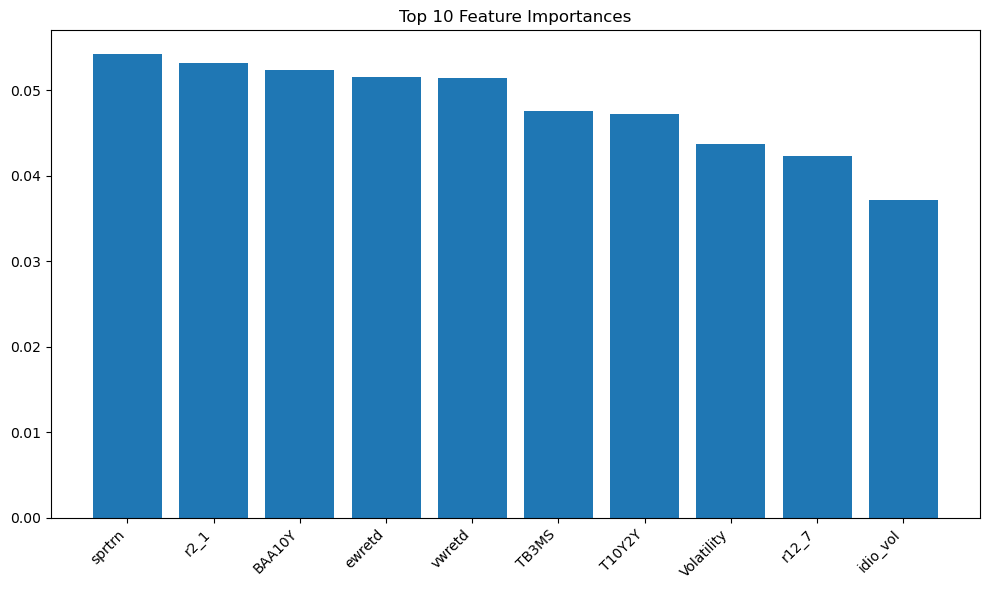

In [1899]:
# 4. 特征重要性
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [1730]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

In [1827]:
# 特征选择
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))
X_selected = selector.fit_transform(X, y)

# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# 时间序列交叉验证
tscv = TimeSeriesSplit(n_splits=5)

# 模型参数
rf_params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': 42
}

# 训练模型
rf_model = RandomForestRegressor(**rf_params)

# 使用时间序列交叉验证
r2_scores = []
mse_scores = []
mape_scores = []
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    r2_scores.append(rf_model.score(X_test, y_test))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mape_scores.append(mean_absolute_percentage_error(y_test, y_pred))

print(f"Average R2 score: {np.mean(r2_scores)}")


Average R2 score: -0.10017691788362644


In [1828]:
print(f"Average Mean Squared Error: {np.mean(mse)}")
print(f"Average Mean Absolute Error: {np.mean(mape)}")

Average Mean Squared Error: 0.00028517544319402356
Average Mean Absolute Error: 1.406069478145253


In [583]:
# y_test.head()

In [537]:
# X_test.index

## 超参数优化

In [288]:
from sklearn.model_selection import RandomizedSearchCV


In [1829]:
y_train_array = y_train['RET']


KeyError: 'RET'

In [1830]:
y_train.shape

(2738,)

In [1831]:
# 设置随机森林的超参数范围
param_distributions = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth': [None] + list(np.arange(5, 26)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 创建随机森林模型
rf = RandomForestRegressor(random_state=42)

# 使用 RandomizedSearchCV 进行超参数搜索
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# 拟合随机搜索模型
random_search.fit(X_train, y_train)

# 输出最佳参数和最佳模型
print("最佳参数：", random_search.best_params_)
best_model = random_search.best_estimator_

# 使用最佳模型在测试集上进行预测
y_pred = best_model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"测试集的 MSE: {mse:.2f}")
print(f"测试集的 R2: {r2:.2f}")

Fitting 3 folds for each of 100 candidates, totalling 300 fits


python(59626) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59627) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59628) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59629) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59632) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(59633) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


KeyboardInterrupt: 

{'n_estimators': 900, 'min_samples_split': 2, 'min_s amples_leaf': 4, 'max_features': 'auto', 'max_depth': 21, 'bootstrap': True}
测试集的 MSE: 0.00
测试集的 R2: -0.03

## Using Rolling Window in the Training 

In [609]:
# # 假设你的数据已经加载到 DataFrame 中

# # 初始化模型
# rolling_model = LinearRegression()

# # 定义一个函数来训练和测试模型
# def train_and_test(fin_data, start_year):
#     # 初始化结果
#     results = []

#     # 将数据按年份分组
#     grouped = fin_data.groupby(fin_data.index.year)

#     # 遍历每个年份
#     for year in range(start_year, fin_data.index.year.max()):
#         # 定义训练集和测试集
#         train_start = datetime(year-1, 1, 1)
#         train_end = datetime(year, 9, 30)
#         test_start = datetime(year, 10, 1)
#         test_end = datetime(year, 12, 31)

#         train_data = fin_data[(fin_data.index >= train_start) & (fin_data.index <= train_end)]
#         test_data = fin_data[(fin_data.index >= test_start) & (fin_data.index <= test_end)]

#         # 检查是否有足够的数据
#         if len(train_data) == 0 or len(test_data) == 0:
#             continue

#         # 提取特征和目标变量（假设目标变量是 'target' 列）
#         X_train = train_data.drop(columns=['target'])
#         y_train = train_data['target']
#         X_test = test_data.drop(columns=['target'])
#         y_test = test_data['target']

#         # 训练模型
#         model.fit(X_train, y_train)

#         # 预测
#         predictions = model.predict(X_test)

#         # 计算误差
#         mse = mean_squared_error(y_test, predictions)

#         # 存储结果
#         results.append({
#             'train_start': train_start,
#             'train_end': train_end,
#             'test_start': test_start,
#             'test_end': test_end,
#             'mse': mse
#         })

#         # 更新训练集，加入本年的数据
#         next_train_data = fin_data[(fin_data.index > train_end) & (fin_data.index <= test_end)]
#         train_data = pd.concat([train_data, next_train_data])

#     return pd.DataFrame(results)

# # 调用函数，假设从第一个完整年份开始
# results = train_and_test(fin_data, start_year=fin_data.index.year.min() + 1)

# # 查看结果
# print(results)


# Optimization

我在用crsp的数据来做机器学习优化投资组合，具体来说，是用财报数据结合宏观基本面和时序特征预测股票回报率并用均值方差的投资组合策略最大化投资收益。我现在有了model，为了测评它最后的收益表现到底如何，我想的是：假设一个人用了我们的模型，那么ta应该能看到历史的所有数据，那么，正确的应该是由第0年的前11个月个数据（feature），预测第12个月的数据（回报率），然后用前12个月数据预测第13个月数据，然后用前13个月预测第14个月数据……以此类推，然后基于每个月每个股票的回报率及预测的方差，都能用解线性优化的方式得到一个所有股票的最优投资权重组合，然后有了这么多个预测的月的回报率，结合当月实际的无风险利率，可以算一个Sharpe ratio，有了所有的Sharpe ratio后可以算一个平均值。你看我的研究思路有问题吗



In [650]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import minimize

In [1900]:
variables_to_keep

Index(['Size', 'bm', 'Momentum', 'r2_1', 'r12_2', 'r12_7', 'ShortTermReversal',
       'market_cap', 'DollarVolume', 'spread', 'RET', 'idio_vol', 'Beta',
       'BetaSquared', 'pe_op_basic', 'pe_op_dil', 'Volatility', 'SUV',
       '52_week_high', 'Rel_to_high', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'roa',
       'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn', 'accrual', 'vwretd',
       'ewretd', 'sprtrn', 'LME', 'LTurnover', 'TICKER'],
      dtype='object')

In [1901]:
opt_data = model_data.copy()
# opt_data = opt_data[variables_to_keep]


In [1902]:
#股票数据中的RET（回报率）可能也是以百分比形式表示的，需要除以100来转换为小数形式。
#您报告的投资组合回报率是 3.0784%，这个数值看起来确实像是一个百分比形式的月度回报率。

# opt_data['RET'] = opt_data['RET'] / 100

previous try:
    Index([
     
     'Size', 'bm', 'Momentum', 'ShortTermReversal', 'ME', 'market_cap',
       'DollarVolume', 'spread', 'RET', 'Idio_vol', 'Beta', 'BetaSquared',
       'divyield', 'pe_op_basic', 'pe_op_dil', 'TB3MS', 'T10Y2Y', 'BAA10Y',
       'roa', 'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio',
       'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn',
       'accrual', 'vwretd', 'ewretd', 'sprtrn', 'LME', 'LTurnover', 'TICKER'],
      dtype='object')

In [1903]:
opt_data.columns

Index(['RET', 'TICKER', 'Size', 'bm', 'Momentum', 'r2_1', 'r12_2', 'r12_7',
       'ShortTermReversal', 'market_cap', 'DollarVolume', 'spread', 'idio_vol',
       'Beta', 'BetaSquared', 'pe_op_basic', 'pe_op_dil', 'Volatility', 'SUV',
       '52_week_high', 'Rel_to_high', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'roa',
       'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn', 'accrual', 'vwretd',
       'ewretd', 'sprtrn', 'LME', 'LTurnover'],
      dtype='object')

In [1904]:
# 如果日期已经是索引，先重置索引
opt_data.reset_index(inplace=True)

# 设置多级索引
opt_data.set_index(['date', 'TICKER'], inplace=True)


# 对MultiIndex进行排序
opt_data.sort_index(inplace=True)

In [1905]:
opt_data.shape

(3314, 40)

In [1906]:
opt_data.index

MultiIndex([('2014-02-28', 'AAPL'),
            ('2014-02-28', 'AMZN'),
            ('2014-02-28',  'AXP'),
            ('2014-02-28',  'BAC'),
            ('2014-02-28',  'BYI'),
            ('2014-02-28',    'C'),
            ('2014-02-28',   'CB'),
            ('2014-02-28',  'CBS'),
            ('2014-02-28', 'CHTR'),
            ('2014-02-28',  'COF'),
            ...
            ('2023-11-30',   'MA'),
            ('2023-11-30',  'MCO'),
            ('2023-11-30',  'NVR'),
            ('2023-11-30',  'OXY'),
            ('2023-11-30', 'PARA'),
            ('2023-11-30', 'SIRI'),
            ('2023-11-30', 'SNOW'),
            ('2023-11-30', 'TMUS'),
            ('2023-11-30',    'V'),
            ('2023-11-30', 'VRSN')],
           names=['date', 'TICKER'], length=3314)

### 为了拿到无风险利率，读一遍归一化前的数据，存到featured_data里

In [1907]:
featured_data = pd.read_csv('final_data_after_missing_value_handle_with_better_features.csv')

In [1908]:
featured_data.set_index(['date', 'TICKER'], inplace=True)

In [1909]:
# 对MultiIndex进行排序
featured_data.sort_index(inplace=True)

In [1910]:
featured_data.shape

(3352, 115)

In [1911]:
featured_data.index

MultiIndex([('2014-01-31', 'AAPL'),
            ('2014-01-31', 'AMZN'),
            ('2014-01-31',  'AXP'),
            ('2014-01-31',  'BAC'),
            ('2014-01-31',  'BYI'),
            ('2014-01-31',    'C'),
            ('2014-01-31',   'CB'),
            ('2014-01-31',  'CBS'),
            ('2014-01-31', 'CHTR'),
            ('2014-01-31',  'COF'),
            ...
            ('2023-11-30',   'MA'),
            ('2023-11-30',  'MCO'),
            ('2023-11-30',  'NVR'),
            ('2023-11-30',  'OXY'),
            ('2023-11-30', 'PARA'),
            ('2023-11-30', 'SIRI'),
            ('2023-11-30', 'SNOW'),
            ('2023-11-30', 'TMUS'),
            ('2023-11-30',    'V'),
            ('2023-11-30', 'VRSN')],
           names=['date', 'TICKER'], length=3352)

In [1912]:

# 确保索引格式一致
opt_data.index = opt_data.index.set_levels([pd.to_datetime(opt_data.index.levels[0]), opt_data.index.levels[1]])
featured_data.index = featured_data.index.set_levels([pd.to_datetime(featured_data.index.levels[0]), featured_data.index.levels[1]])

# 确保索引对齐
common_index = opt_data.index.intersection(featured_data.index)

# 只替换common_index中的值
opt_data.loc[common_index, 'RET'] = featured_data.loc[common_index, 'RET']

In [1913]:
opt_data.index

MultiIndex([('2014-02-28', 'AAPL'),
            ('2014-02-28', 'AMZN'),
            ('2014-02-28',  'AXP'),
            ('2014-02-28',  'BAC'),
            ('2014-02-28',  'BYI'),
            ('2014-02-28',    'C'),
            ('2014-02-28',   'CB'),
            ('2014-02-28',  'CBS'),
            ('2014-02-28', 'CHTR'),
            ('2014-02-28',  'COF'),
            ...
            ('2023-11-30',   'MA'),
            ('2023-11-30',  'MCO'),
            ('2023-11-30',  'NVR'),
            ('2023-11-30',  'OXY'),
            ('2023-11-30', 'PARA'),
            ('2023-11-30', 'SIRI'),
            ('2023-11-30', 'SNOW'),
            ('2023-11-30', 'TMUS'),
            ('2023-11-30',    'V'),
            ('2023-11-30', 'VRSN')],
           names=['date', 'TICKER'], length=3314)

In [1914]:
opt_data.to_csv('opt_data.csv')

In [1915]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# 其他代码


In [1916]:
opt_features = opt_data.columns[~opt_data.columns.isin(['RET','TICKER'])].tolist()
target = ['RET']

In [1917]:
opt_data[target].head()

RET
date       TICKER          
2014-02-28 AAPL   -0.002710
           AMZN    0.005470
           AXP     0.010965
           BAC     0.002426
           BYI    -0.007326

In [1918]:
# opt_features

In [1924]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def get_data_for_date_range(df, start_date, end_date):
    # return df.loc[start_date:end_date]
    if start_date is None:
        data = df.loc[:end_date]
    else:
        data = df.loc[start_date:end_date]
    if data.empty:
        logger.warning(f"No data found between {start_date} and {end_date}")
    return data

def prepare_training_data(df, features, target):
    X = opt_data[opt_features]
    y = opt_data[target]
    # return X, y
    if X.empty or y.empty:
        logger.warning("Training data is empty.")
    return X, y

def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def calculate_portfolio_metrics(weights, returns, cov_matrix):
    portfolio_return = np.sum(returns * weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# 目标函数：最大化夏普比率
def objective(weights, returns, cov_matrix, lambda_risk_aversion):
    portfolio_return, portfolio_volatility = calculate_portfolio_metrics(weights, returns, cov_matrix)
    return -portfolio_return / portfolio_volatility  # 最大化夏普比率

# 分配相等的权重
def equal_weight_portfolio(expected_returns):
    n = len(expected_returns)
    equal_weights = np.ones(n) / n
    return equal_weights

# 优化投资组合权重
# def optimize_portfolio(expected_returns, cov_matrix):
#     n = len(expected_returns)
#     constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#     bounds = tuple((0, 1) for _ in range(n))
    
#     result = minimize(objective, n * [1./n], args=(expected_returns, cov_matrix),
#                       method='SLSQP', bounds=bounds, constraints=constraints)
#     print(result.x)
    
#     if not result.success:
#         logger.warning(f"Optimization failed: {result.message}")
    
#     return result.x

# 目标函数：最大化 w^T μ - λ w^T Σ w
# def objective(weights, returns, cov_matrix, lambda_risk_aversion):
#     portfolio_return = np.dot(weights, returns)
#     portfolio_volatility = np.dot(weights.T, np.dot(cov_matrix, weights))
#     return - (portfolio_return - lambda_risk_aversion * portfolio_volatility)

# 优化投资组合权重
def optimize_portfolio(expected_returns, cov_matrix, lambda_risk_aversion):
    n = len(expected_returns)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 权重之和为1的约束
    bounds = tuple((0, 1) for _ in range(n))  # 权重在0到1之间

    # 最小化目标函数
    result = minimize(objective, n * [1./n], args=(expected_returns, cov_matrix, lambda_risk_aversion),
                      method='SLSQP', bounds=bounds, constraints=constraints)
    
    print(result.x)
    
    if not result.success:
        logger.warning(f"Optimization failed: {result.message}")
    
    return result.x


def predict_returns(df, start_date, end_date, features, target, rf_model):
    try:
        logger.info(f"Predicting returns from {start_date} to {end_date}")
        
        train = get_data_for_date_range(df, None, start_date)
        test = get_data_for_date_range(df, start_date, end_date)
        
        logger.info(f"Train data shape: {train.shape}")
        logger.info(f"Test data shape: {test.shape}")
        
        X_train, y_train = prepare_training_data(train, features, target)
        X_test = test[features]
        
        logger.info(f"X_train shape: {X_train.shape}")
        logger.info(f"y_train shape: {y_train.shape}")
        logger.info(f"X_test shape: {X_test.shape}")
        
        if X_train.shape[0] == 0 or y_train.shape[0] == 0:
            raise ValueError("Training data is empty")
        
        if X_test.shape[0] == 0:
            raise ValueError("Test data is empty")
        
        predictions = fit_and_predict(rf_model, X_train, y_train, X_test)
        # predictions = model.predict(X_test)
        logger.info(f"Predictions shape: {predictions.shape}")
        
        # 修改这里：计算每个预测的方差，而不是整体方差
        predicted_variance = np.var(predictions) * np.ones_like(predictions)
        logger.info(f"Predicted variance shape: {predicted_variance.shape}")

        print(predictions)
        return predictions, predicted_variance

        
        # daily_predictions = fit_and_predict(rf_model, X_train, y_train, X_test)
        # logger.info(f"Daily predictions shape: {daily_predictions.shape}")
        
        # # 将日回报率转换为月回报率
        # monthly_predictions = np.array([(1 + daily_predictions).prod() - 1])
        # logger.info(f"Monthly predictions shape: {monthly_predictions.shape}")
        
        # # 计算月度预测的方差
        # monthly_variance = np.array([np.var(daily_predictions) * len(daily_predictions)])
        # logger.info(f"Monthly predicted variance shape: {monthly_variance.shape}")
        
        # return monthly_predictions, monthly_variance
        
    except Exception as e:
        logger.error(f"Error in predict_returns: {str(e)}")
        raise

def calculate_monthly_return(daily_return):
    trading_days_per_month = 30
    monthly_return = (1 + daily_return) ** trading_days_per_month - 1
    return daily_return

In [1925]:
# def process_single_period(opt_data, featured_data, date, next_month, opt_features, target, rf_model):
#     try:
#         logger.info(f"Processing period from {date} to {next_month}")
        
#         historical_data = opt_data.loc[opt_data.index.get_level_values('date') <= date]
#         logger.info(f"Historical data shape: {historical_data.shape}")
        
#         predicted_returns, predicted_variance = predict_returns(historical_data, date, next_month, opt_features, target, rf_model)
#         logger.info(f"Predicted returns shape: {predicted_returns.shape}")
#         logger.info(f"Predicted variance shape: {predicted_variance.shape}")
        
#         cov_matrix = np.diag(predicted_variance)
#         logger.info(f"Covariance matrix shape: {cov_matrix.shape}")
        
#         optimal_weights = optimize_portfolio(predicted_returns, cov_matrix)
#         logger.info(f"Optimal weights shape: {optimal_weights.shape}")
        
#         # 计算月度实际回报率
#         mask = (opt_data.index.get_level_values('date') >= date) & (opt_data.index.get_level_values('date') < next_month)
#         daily_returns = opt_data.loc[mask, target]
#         actual_returns = (1 + daily_returns).prod() - 1
#         logger.info(f"Actual monthly returns shape: {actual_returns.shape}")
        
#         mask = featured_data.index.get_level_values('date') == next_month
#         annual_rf_rate = featured_data.loc[mask, 'TB3MS'].iloc[0] / 100
#         logger.info(f"Annual Risk-free rate: {annual_rf_rate}")
#         monthly_rf_rate = (1 + annual_rf_rate) ** (1/12) - 1
#         logger.info(f"Monthly Risk-free rate: {monthly_rf_rate}")
        
#         portfolio_return = np.sum(optimal_weights * actual_returns)
#         logger.info(f"Portfolio return: {portfolio_return}")
        
#         sharpe_ratio = (portfolio_return - monthly_rf_rate) / np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
#         logger.info(f"Sharpe ratio: {sharpe_ratio}")
        
#         return portfolio_return, sharpe_ratio
#     except Exception as e:
#         logger.error(f"Error processing period {date} to {next_month}: {str(e)}")
#         raise

# # 使用示例：
# date = pd.Timestamp('2017-12-31')
# next_month = date + pd.DateOffset(months=1)
# portfolio_return, sharpe_ratio = process_single_period(opt_data, opt_data, date, next_month, opt_features, target, rf_model)
# if portfolio_return is not None and sharpe_ratio is not None:
#     print(f"Portfolio Return: {portfolio_return}, Sharpe Ratio: {sharpe_ratio}")

In [1926]:
def process_single_period(opt_data, featured_data, date, next_month, opt_features, target, rf_model, lambda_risk_aversion):
    try:
        logger.info(f"Processing period from {date} to {next_month}")
        
        historical_data = opt_data.loc[opt_data.index.get_level_values('date') <= date]
        logger.info(f"Historical data shape: {historical_data.shape}")
        
        predicted_returns, predicted_variance = predict_returns(historical_data, date, next_month, opt_features, target, rf_model)
        logger.info(f"Predicted returns shape: {predicted_returns.shape}")
        logger.info(f"Predicted variance shape: {predicted_variance.shape}")
        
        # 修改这里：使用预测的方差构建对角协方差矩阵
        cov_matrix = np.diag(predicted_variance)
        logger.info(f"Covariance matrix shape: {cov_matrix.shape}")

        # optimal_weights = equal_weight_portfolio(predicted_returns)

        optimal_weights = optimize_portfolio(predicted_returns, cov_matrix, lambda_risk_aversion)
        logger.info(f"Optimal weights shape: {optimal_weights.shape}")
        
        # actual_returns = opt_data.loc[(next_month, slice(None)), target]
        # logger.info(f"Actual returns shape: {actual_returns.shape}")
        
        annual_rf_rate = featured_data.loc[featured_data.index.get_level_values('date') == next_month, 'TB3MS'].iloc[0] / 100
        logger.info(f"Annual Risk-free rate: {annual_rf_rate}")
        monthly_rf_rate = (1 + annual_rf_rate) ** (1/12) - 1
        logger.info(f"Monthly Risk-free rate: {monthly_rf_rate}")

        daily_portfolio_returns = np.sum(optimal_weights * actual_returns.values)
        portfolio_return = calculate_monthly_return(daily_portfolio_returns)
        logger.info(f"Portfolio return: {portfolio_return}")
        
        sharpe_ratio = (portfolio_return - monthly_rf_rate) / np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
        logger.info(f"Sharpe ratio: {sharpe_ratio}")
        
        return portfolio_return, sharpe_ratio
    except Exception as e:
        logger.error(f"Error processing period {date} to {next_month}: {str(e)}")
        raise  # 重新抛出异常，以便看到完整的堆栈跟踪
        
# 使用示例：
date = pd.Timestamp('2017-12-31')
next_month = date + pd.DateOffset(months=1)
lambda_risk_aversion = 0.5
portfolio_return, sharpe_ratio = process_single_period(opt_data, featured_data, date, next_month, opt_features, target, rf_model, lambda_risk_aversion)
if portfolio_return is not None and sharpe_ratio is not None:
    print(f"Portfolio Return: {portfolio_return}, Sharpe Ratio: {sharpe_ratio}")

INFO:__main__:Processing period from 2017-12-31 00:00:00 to 2018-01-31 00:00:00
INFO:__main__:Historical data shape: (1283, 40)
INFO:__main__:Predicting returns from 2017-12-31 00:00:00 to 2018-01-31 00:00:00
INFO:__main__:Train data shape: (1283, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__mai

[-0.0044802  -0.00542314 -0.00595723 -0.0014286  -0.00505395 -0.00542973
 -0.00653303 -0.00018909 -0.00410243 -0.00108326 -0.00223293  0.0017837
 -0.00884044 -0.00176844 -0.00185836 -0.000516   -0.00454693 -0.00955814
 -0.00080884 -0.00348922 -0.00191229 -0.00114457 -0.00206794 -0.00143948
 -0.00078993 -0.00519058 -0.00212249 -0.00349719]
[2.99205105e-14 1.55486735e-13 1.73291936e-13 0.00000000e+00
 4.19039803e-14 8.26838598e-14 1.21860855e-13 0.00000000e+00
 3.13638004e-14 0.00000000e+00 0.00000000e+00 1.00000000e+00
 1.47604151e-13 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.00651734e-14 2.71879741e-13 0.00000000e+00 6.35602682e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.11722348e-14 0.00000000e+00 5.37764278e-15]
Portfolio Return: -0.28739600000028437, Sharpe Ratio: -111.0195086314689


In [1927]:
def rolling_portfolio_optimization(opt_data, featured_data, start_date, end_date, features, target, model, lambda_risk_aversion, window_size):
    dates = pd.date_range(start_date, end_date, freq='M')
    portfolio_returns = []
    sharpe_ratios = []

    for i in range(len(dates) - window_size):
        train_start = dates[i]
        train_end = dates[i + window_size - 1]
        next_month = dates[i + window_size]
        
        logger.info(f"Training from {train_start} to {train_end}, predicting for {next_month}")
        
        # 训练模型
        train_data = get_data_for_date_range(opt_data, train_start, train_end)
        X_train, y_train = prepare_training_data(train_data, features, target)
        model.fit(X_train, y_train)
        
        # 处理单个时期并计算投资组合回报率和夏普比率
        portfolio_return, sharpe_ratio = process_single_period(opt_data, featured_data, train_end, next_month, features, target, model, lambda_risk_aversion)
        portfolio_returns.append(portfolio_return)
        sharpe_ratios.append(sharpe_ratio)
    
    return portfolio_returns, sharpe_ratios

# 使用示例：
start_date = pd.Timestamp('2014-03-31')
end_date = pd.Timestamp('2023-11-30')
lambda_risk_aversion = 0.5
window_size = 12  # 每个持有期为12个月

# 这里假设 rf_model 是已经定义好的模型，opt_data 和 opt_features 是预先定义好的数据和特征
portfolio_returns, sharpe_ratios = rolling_portfolio_optimization(opt_data, opt_data, start_date, end_date, opt_features, target, rf_model, lambda_risk_aversion, window_size)

# 计算平均夏普比率
average_sharpe_ratio = np.mean(sharpe_ratios)
print(f"Average Sharpe Ratio: {average_sharpe_ratio}")

INFO:__main__:Training from 2014-03-31 00:00:00 to 2015-02-28 00:00:00, predicting for 2015-03-31 00:00:00
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Processing period from 2015-02-28 00:00:00 to 2015-03-31 00:00:00
INFO:__main__:Historical data shape: (350, 40)
INFO:__main__:Predicting returns from 2015-02-28 00:00:00 to 2015-03-31 00:00:00
INFO:__main__:Train data shape: (350, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has be

[-0.00925775 -0.00794944 -0.00587722 -0.01103687 -0.01071693 -0.00512952
 -0.00404182 -0.00308021 -0.00424819 -0.0057735  -0.00450555 -0.00234743
 -0.02179261  0.00381519 -0.00660513 -0.00916584 -0.00462257 -0.00753022
 -0.00351878  0.00861723 -0.00904284 -0.00469878 -0.00336676 -0.00480263
  0.01029678 -0.00534049 -0.00806202]
[8.52177965e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.05068803e-15 0.00000000e+00 9.84935678e-16
 1.98187313e-15 0.00000000e+00 1.05859869e-15 2.52314270e-15
 0.00000000e+00 1.67861276e-01 0.00000000e+00 8.25916832e-16
 1.01339614e-15 6.36503736e-16 9.24852659e-16 3.79131266e-01
 1.30174733e-15 5.24254461e-16 7.28063796e-16 8.42240065e-16
 4.53007458e-01 1.07812057e-15 0.00000000e+00]


INFO:__main__:Processing period from 2015-03-31 00:00:00 to 2015-04-30 00:00:00
INFO:__main__:Historical data shape: (377, 40)
INFO:__main__:Predicting returns from 2015-03-31 00:00:00 to 2015-04-30 00:00:00
INFO:__main__:Train data shape: (377, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.01066734  0.0034575  -0.00527392 -0.00064617 -0.00638574 -0.00239315
 -0.00369085 -0.00970052  0.01530056 -0.00211704 -0.01026626 -0.00736649
  0.00092068 -0.00099346 -0.00509936 -0.00619921 -0.0019321  -0.0102205
 -0.00402022  0.001541   -0.00509683 -0.00648401 -0.00529807  0.00835508
 -0.0084664  -0.003742   -0.00093145]
[3.21344205e-15 1.16938541e-01 0.00000000e+00 0.00000000e+00
 1.04706108e-15 0.00000000e+00 0.00000000e+00 1.45424904e-15
 5.17326915e-01 0.00000000e+00 3.65442532e-15 2.77959844e-15
 3.11022178e-02 0.00000000e+00 3.18166784e-16 5.73591911e-16
 0.00000000e+00 5.11472766e-15 0.00000000e+00 5.20103245e-02
 0.00000000e+00 1.27543846e-15 0.00000000e+00 2.82622002e-01
 2.95317520e-15 0.00000000e+00 0.00000000e+00]


INFO:__main__:Processing period from 2015-04-30 00:00:00 to 2015-05-31 00:00:00
INFO:__main__:Historical data shape: (404, 40)
INFO:__main__:Predicting returns from 2015-04-30 00:00:00 to 2015-05-31 00:00:00
INFO:__main__:Train data shape: (404, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.0170169   0.00171021 -0.0083061  -0.00127616 -0.00498649 -0.00572276
 -0.00563668 -0.00705275 -0.00157144 -0.00031989 -0.00429357 -0.01179318
 -0.02660892 -0.00136456  0.00092598 -0.01791091 -0.00332558 -0.00432949
 -0.00245666 -0.00012684 -0.0111094  -0.00052654 -0.00425486 -0.01082996
 -0.00821196 -0.01018246 -0.00527908]
[0.00000000e+00 6.49522022e-01 0.00000000e+00 5.30994288e-16
 4.16584699e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.83237400e-16 8.28489402e-16 2.67451475e-16 0.00000000e+00
 0.00000000e+00 4.95543070e-16 3.50477978e-01 0.00000000e+00
 3.22636528e-16 9.51136281e-16 6.36029707e-16 5.94661388e-16
 1.25602341e-15 3.42518017e-16 5.22258974e-16 0.00000000e+00
 9.48185765e-16 0.00000000e+00 9.27361125e-16]


INFO:__main__:Processing period from 2015-05-31 00:00:00 to 2015-06-30 00:00:00
INFO:__main__:Historical data shape: (430, 40)
INFO:__main__:Predicting returns from 2015-05-31 00:00:00 to 2015-06-30 00:00:00
INFO:__main__:Train data shape: (430, 40)
INFO:__main__:Test data shape: (26, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (26, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (26,)
INFO:__main__:Predicted variance shape: (26,)
INFO:__main__:Predicted returns shape: (26,)
INFO:__main__:Predicted variance shape: (26,)
INFO:__main__:Covariance matrix shape: (26, 26)
INFO:__main_

[-0.01047657 -0.00266655  0.00277238 -0.00454924 -0.00658019 -0.00582161
 -0.00606126 -0.00341009  0.00592308 -0.00595848 -0.00376984 -0.00499947
 -0.01577916 -0.00397966 -0.00979636 -0.01371927 -0.00795486 -0.00462794
 -0.00566736 -0.009932    0.00291736  0.00413141  0.00476831  0.00841676
 -0.00887303 -0.00608849]
[2.01508628e-15 4.22014758e-16 9.57836939e-02 3.05949017e-17
 1.08392841e-15 5.72073044e-16 7.32215006e-16 5.54085052e-16
 2.04823633e-01 3.76459356e-16 2.07626872e-16 2.05234610e-16
 3.83149775e-15 1.90569659e-16 1.36398901e-15 5.51639137e-15
 7.28099064e-16 1.99799695e-16 3.34777095e-16 6.15771921e-16
 1.00843005e-01 1.42878592e-01 1.64708281e-01 2.90962795e-01
 9.65245016e-16 6.23633709e-16]


INFO:__main__:Processing period from 2015-06-30 00:00:00 to 2015-07-31 00:00:00
INFO:__main__:Historical data shape: (457, 40)
INFO:__main__:Predicting returns from 2015-06-30 00:00:00 to 2015-07-31 00:00:00
INFO:__main__:Train data shape: (457, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[ 0.00341469  0.00100723  0.00705366  0.00219122  0.00393229  0.00367745
  0.00214417  0.00096139  0.01036256  0.00019407 -0.00284284 -0.00114946
  0.00033966  0.00976637 -0.00021998 -0.0018731   0.01074992  0.00284889
  0.00064121  0.00165436 -0.0057143   0.00389362  0.00221183 -0.00395072
  0.00243001  0.00066808  0.00255566]
[4.69504595e-02 1.38618118e-02 9.70422487e-02 3.01375724e-02
 5.41093051e-02 5.05968581e-02 2.94731388e-02 1.32194377e-02
 1.42555672e-01 2.62526475e-03 1.74254750e-14 1.32780207e-15
 4.66412435e-03 1.34358861e-01 0.00000000e+00 8.38150800e-15
 1.47872747e-01 3.91880294e-02 8.82022690e-03 2.27444303e-02
 5.07928771e-14 5.35672403e-02 3.04197490e-02 2.74492252e-14
 3.34268621e-02 9.21431988e-03 3.51516402e-02]


INFO:__main__:Processing period from 2015-07-31 00:00:00 to 2015-08-31 00:00:00
INFO:__main__:Historical data shape: (484, 40)
INFO:__main__:Predicting returns from 2015-07-31 00:00:00 to 2015-08-31 00:00:00
INFO:__main__:Train data shape: (484, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.00796754 -0.00551538 -0.00075229 -0.00232051 -0.00830889 -0.00650248
 -0.00312841 -0.00065965 -0.00534467 -0.00083375 -0.0207899   0.00043023
  0.0086923   0.02339622  0.00183897  0.00210526  0.00838588 -0.00818141
 -0.00783863 -0.00727412 -0.00042243 -0.00902386 -0.00192921 -0.01061281
  0.01161448 -0.01242334 -0.00173711]
[6.93041026e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.04723261e-15 1.04107947e-15 0.00000000e+00 0.00000000e+00
 1.43304567e-15 0.00000000e+00 1.24830924e-14 7.62110688e-03
 1.53862441e-01 4.14411523e-01 3.26468319e-02 3.72382576e-02
 1.48523973e-01 2.21301453e-15 2.10301580e-15 7.65494727e-16
 0.00000000e+00 2.87954644e-15 0.00000000e+00 4.62389499e-15
 2.05695866e-01 6.85498129e-15 0.00000000e+00]


INFO:__main__:Processing period from 2015-08-31 00:00:00 to 2015-09-30 00:00:00
INFO:__main__:Historical data shape: (511, 40)
INFO:__main__:Predicting returns from 2015-08-31 00:00:00 to 2015-09-30 00:00:00
INFO:__main__:Train data shape: (511, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-4.51028732e-03 -3.26326484e-03 -6.99653580e-03 -2.51970247e-03
 -3.11648171e-03 -5.70469045e-04 -4.60620055e-03 -6.70378858e-03
 -2.20973790e-03 -6.80416228e-04 -2.07411031e-03 -4.45184359e-03
 -7.25105741e-03  8.27422217e-03 -3.71330784e-03 -5.83763424e-03
 -9.16725952e-05 -3.23192554e-03 -1.12138610e-02 -1.17896585e-02
  9.53294820e-04  6.03696010e-03 -4.93069927e-03 -9.47825108e-03
 -5.27645141e-03 -1.06444781e-02 -5.49924364e-03]
[0.00000000e+00 0.00000000e+00 1.17960250e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.06880563e-16
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.04910589e-15 5.42053839e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.44480774e-15 9.69745670e-15
 6.24607558e-02 3.95485405e-01 0.00000000e+00 3.28820233e-15
 0.00000000e+00 6.44463017e-15 5.66134427e-16]


INFO:__main__:Processing period from 2015-09-30 00:00:00 to 2015-10-31 00:00:00
INFO:__main__:Historical data shape: (538, 40)
INFO:__main__:Predicting returns from 2015-09-30 00:00:00 to 2015-10-31 00:00:00
INFO:__main__:Train data shape: (538, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[0.01712464 0.01958292 0.02171929 0.01480136 0.01490303 0.01469181
 0.00751615 0.01842659 0.03090799 0.01557653 0.02444244 0.01348731
 0.01753013 0.02206801 0.01108544 0.01776273 0.01133911 0.01813624
 0.01348016 0.01188169 0.00871647 0.02616655 0.01985774 0.01976229
 0.01169688 0.01762172 0.02200236]
[0.03704327 0.04235918 0.04698252 0.03201825 0.03223785 0.03178166
 0.01625773 0.03985758 0.06686061 0.03369423 0.05287704 0.02917651
 0.03792029 0.04773594 0.02398059 0.03842322 0.02452891 0.03922942
 0.0291605  0.02570229 0.01885613 0.05659962 0.04295459 0.04274759
 0.02530285 0.03811797 0.04759367]


INFO:__main__:Processing period from 2015-10-31 00:00:00 to 2015-11-30 00:00:00
INFO:__main__:Historical data shape: (565, 40)
INFO:__main__:Predicting returns from 2015-10-31 00:00:00 to 2015-11-30 00:00:00
INFO:__main__:Train data shape: (565, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.00723309 -0.00138263 -0.00253582 -0.00819411 -0.0118441  -0.00899632
 -0.00662047 -0.00303657 -0.00558277 -0.00933631  0.00124394 -0.00399355
  0.0049295   0.00834604 -0.00586139 -0.00056855  0.00269973 -0.00510419
 -0.01208387 -0.01785562 -0.00177322  0.00228254 -0.00662698 -0.00027709
  0.00484463 -0.01046996 -0.00190648]
[0.00000000e+00 1.64186618e-14 1.25110011e-14 0.00000000e+00
 0.00000000e+00 0.00000000e+00 6.70424802e-16 1.19766803e-14
 4.64005118e-15 0.00000000e+00 5.11104203e-02 9.70917227e-15
 2.02481122e-01 3.42763856e-01 3.02664995e-15 2.11588668e-14
 1.10894505e-01 6.08883196e-15 0.00000000e+00 0.00000000e+00
 1.73047720e-14 9.37668974e-02 1.49380636e-15 2.27583262e-14
 1.98983200e-01 0.00000000e+00 1.68718111e-14]


INFO:__main__:Processing period from 2015-11-30 00:00:00 to 2015-12-31 00:00:00
INFO:__main__:Historical data shape: (592, 40)
INFO:__main__:Predicting returns from 2015-11-30 00:00:00 to 2015-12-31 00:00:00
INFO:__main__:Train data shape: (592, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.00099514  0.00373593 -0.00584568 -0.0037047  -0.00291856 -0.00208896
 -0.00246443 -0.00315739  0.00081292 -0.00456044  0.00349461 -0.01117245
  0.00226529 -0.00679125 -0.00778418 -0.00388347  0.00269983 -0.00621913
 -0.00774834 -0.00808649 -0.00286765  0.00352844 -0.00496575 -0.01244306
 -0.01360114 -0.00697963 -0.00168972]
[1.96257360e-14 2.25983306e-01 4.34668342e-15 1.05260377e-14
 1.43416606e-14 1.74253859e-14 1.43518890e-14 1.08193654e-14
 4.91480255e-02 9.10976591e-15 2.11367414e-01 0.00000000e+00
 1.36839877e-01 0.00000000e+00 0.00000000e+00 1.00649338e-14
 1.63280070e-01 6.14848513e-16 0.00000000e+00 0.00000000e+00
 1.30916688e-14 2.13381308e-01 5.44599206e-15 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.75968232e-14]


INFO:__main__:Processing period from 2015-12-31 00:00:00 to 2016-01-31 00:00:00
INFO:__main__:Historical data shape: (620, 40)
INFO:__main__:Predicting returns from 2015-12-31 00:00:00 to 2016-01-31 00:00:00
INFO:__main__:Train data shape: (620, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__main_

[-0.01085376  0.00310488 -0.01035402 -0.00688318 -0.0096274  -0.00722651
 -0.00617137  0.00141342 -0.00019726 -0.00972022 -0.00176457 -0.00500038
 -0.00614622  0.00252586 -0.00780285 -0.00773385 -0.00639693 -0.00343123
  0.00345588 -0.01177124 -0.0036042  -0.00426544  0.00263692  0.00027647
 -0.00605048 -0.01076623 -0.00801559 -0.00649395]
[0.00000000e+00 2.31445018e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.10430145e-15 2.61893747e-15 1.05389283e-01
 6.26059814e-15 0.00000000e+00 7.46885251e-15 3.46144578e-15
 2.68352676e-15 1.88302461e-01 4.49317162e-16 0.00000000e+00
 9.47876887e-16 5.60174978e-15 2.57637473e-01 0.00000000e+00
 3.90201151e-15 5.25146187e-15 1.96597186e-01 2.06285784e-02
 2.42223065e-15 0.00000000e+00 0.00000000e+00 6.31880576e-16]


INFO:__main__:Processing period from 2016-01-31 00:00:00 to 2016-02-29 00:00:00
INFO:__main__:Historical data shape: (647, 40)
INFO:__main__:Predicting returns from 2016-01-31 00:00:00 to 2016-02-29 00:00:00
INFO:__main__:Train data shape: (647, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[ 0.02629547  0.03294201 -0.00735655  0.01258508  0.03884845  0.04013763
  0.02814576  0.02227316  0.03299506  0.02277011  0.03505232  0.01455007
  0.03082675  0.02917401  0.01116272  0.02348315  0.03032056  0.02063649
  0.04058427  0.02217455  0.00910337  0.03221476  0.0138658   0.0265134
  0.03230468  0.04281602  0.0073442 ]
[0.03872137 0.04850585 0.         0.01853152 0.05720629 0.05910095
 0.04144387 0.03279625 0.04858481 0.03352819 0.05161588 0.02142583
 0.04539015 0.04295616 0.01643785 0.03457846 0.04464769 0.0303872
 0.05975954 0.03265124 0.01340613 0.04743748 0.02041636 0.03903939
 0.0475689  0.06304541 0.01081725]


INFO:__main__:Processing period from 2016-02-29 00:00:00 to 2016-03-31 00:00:00
INFO:__main__:Historical data shape: (674, 40)
INFO:__main__:Predicting returns from 2016-02-29 00:00:00 to 2016-03-31 00:00:00
INFO:__main__:Train data shape: (674, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.00389153  0.00206543 -0.00936387 -0.00293878 -0.00974555 -0.01082919
 -0.00258306 -0.00436886 -0.01259873 -0.00801946 -0.00274149 -0.0002655
  0.00525607 -0.00510007 -0.00133495  0.00390969  0.00048727 -0.00930291
 -0.00694231 -0.00073655 -0.00033188 -0.00614185  0.00382273  0.01469022
 -0.00564666 -0.00529992 -0.00753323]
[0.00000000e+00 6.83691186e-02 1.56574111e-15 0.00000000e+00
 2.80510395e-15 4.44936491e-15 0.00000000e+00 0.00000000e+00
 1.26421843e-14 4.59448457e-15 0.00000000e+00 0.00000000e+00
 1.73929857e-01 9.16248602e-17 0.00000000e+00 1.29272489e-01
 1.60772887e-02 3.56695700e-15 1.70349205e-15 0.00000000e+00
 0.00000000e+00 6.37405014e-16 1.26486857e-01 4.85864390e-01
 0.00000000e+00 4.64251021e-16 1.94697973e-15]


INFO:__main__:Processing period from 2016-03-31 00:00:00 to 2016-04-30 00:00:00
INFO:__main__:Historical data shape: (701, 40)
INFO:__main__:Predicting returns from 2016-03-31 00:00:00 to 2016-04-30 00:00:00
INFO:__main__:Train data shape: (701, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.0029083   0.01596792  0.01165982  0.00743525  0.00229303  0.00092747
  0.00408708 -0.00188175  0.00168321  0.00053014  0.00270114  0.0014855
  0.00174333 -0.00207593 -0.00254977  0.00269839  0.01089301  0.00814481
  0.00185733  0.00221255 -0.00557152  0.0021144   0.00149185  0.02050886
 -0.00064406 -0.00348508 -0.00538364]
[9.17065511e-16 1.58955639e-01 1.16109496e-01 7.40725224e-02
 2.28376686e-02 9.24094135e-03 4.07534979e-02 1.20019129e-15
 1.67661539e-02 5.25484895e-03 2.68995197e-02 1.48083929e-02
 1.73624446e-02 9.84508772e-16 9.92330357e-16 2.68700921e-02
 1.08458062e-01 8.10850837e-02 1.84815507e-02 2.20115045e-02
 2.00727600e-15 2.10527006e-02 1.48366512e-02 2.04143230e-01
 0.00000000e+00 1.64277573e-15 3.42259036e-15]


INFO:__main__:Processing period from 2016-04-30 00:00:00 to 2016-05-31 00:00:00
INFO:__main__:Historical data shape: (728, 40)
INFO:__main__:Predicting returns from 2016-04-30 00:00:00 to 2016-05-31 00:00:00
INFO:__main__:Train data shape: (728, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-0.00670115  0.00110409  0.02498993 -0.00352784 -0.00951382 -0.00921227
 -0.00204798  0.00462985 -0.00888541 -0.00228743 -0.0057509   0.00250492
 -0.00542539 -0.00240231 -0.0013747  -0.00654069  0.01190799 -0.00608815
 -0.00372193 -0.01407955 -0.00382857  0.0037512   0.00409856 -0.00382307
 -0.00499385 -0.00610522 -0.01493813]
[2.33521847e-15 2.08232066e-02 4.71639881e-01 0.00000000e+00
 3.09368113e-15 7.64249497e-16 0.00000000e+00 8.73709743e-02
 3.57359273e-15 0.00000000e+00 1.19826789e-16 4.72506992e-02
 4.38399634e-17 0.00000000e+00 0.00000000e+00 1.19785099e-15
 2.24736182e-01 0.00000000e+00 0.00000000e+00 4.54874701e-15
 0.00000000e+00 7.08071099e-02 7.73719464e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.21187102e-15]


INFO:__main__:Processing period from 2016-05-31 00:00:00 to 2016-06-30 00:00:00
INFO:__main__:Historical data shape: (755, 40)
INFO:__main__:Predicting returns from 2016-05-31 00:00:00 to 2016-06-30 00:00:00
INFO:__main__:Train data shape: (755, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-5.03884621e-03  9.36801439e-03  1.45034713e-02  2.36508236e-03
 -1.87829818e-03 -1.77663594e-03  2.05442840e-03 -1.46977297e-03
 -4.00126173e-03 -4.77490246e-03  1.31553381e-03  2.29570936e-03
 -1.02719951e-02 -4.79724248e-03 -1.85188711e-03 -2.30407418e-04
  6.32354601e-03  4.23455007e-03 -6.95566500e-03 -2.77063074e-05
 -3.27557128e-03 -2.90277822e-03  8.85300285e-03  1.70369851e-02
  2.51801412e-03 -4.59419930e-03  1.70302971e-03]
[1.06761954e-15 1.29114611e-01 1.99932673e-01 3.25894262e-02
 1.13546772e-15 1.46798667e-15 2.82095799e-02 1.78641341e-15
 3.97647351e-16 8.66085571e-16 1.81443791e-02 3.16183373e-02
 3.93551568e-15 8.47385955e-16 1.11776894e-15 3.40264719e-15
 8.71681188e-02 5.83212468e-02 1.73364972e-15 3.68531315e-15
 1.98520725e-16 1.28969913e-16 1.22044376e-01 2.34787799e-01
 3.46341531e-02 8.11581209e-16 2.34352998e-02]


INFO:__main__:Processing period from 2016-06-30 00:00:00 to 2016-07-31 00:00:00
INFO:__main__:Historical data shape: (782, 40)
INFO:__main__:Predicting returns from 2016-06-30 00:00:00 to 2016-07-31 00:00:00
INFO:__main__:Train data shape: (782, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[ 0.00708591  0.03154933  0.00027935  0.00990304  0.00802709  0.0071572
  0.01550102  0.00705365  0.01198679  0.00715041  0.00783965  0.01292695
  0.00484605  0.01502496  0.00767977  0.00665407  0.02515612  0.02131843
 -0.0110482   0.01121661  0.01133799  0.00805892  0.00562921  0.01941081
  0.00122285 -0.01500353  0.01311803]
[2.55726747e-02 1.13843287e-01 1.00863779e-03 3.57346002e-02
 2.89651607e-02 2.58278401e-02 5.59299546e-02 2.54503306e-02
 4.32564105e-02 2.58021186e-02 2.82879434e-02 4.66421242e-02
 1.74871628e-02 5.42139774e-02 2.77107831e-02 2.40096158e-02
 9.07685104e-02 7.69254431e-02 4.88369781e-14 4.04760598e-02
 4.09095582e-02 2.90805426e-02 2.03135077e-02 7.00398912e-02
 4.41215339e-03 8.14595844e-14 4.73317126e-02]


INFO:__main__:Processing period from 2016-07-31 00:00:00 to 2016-08-31 00:00:00
INFO:__main__:Historical data shape: (809, 40)
INFO:__main__:Predicting returns from 2016-07-31 00:00:00 to 2016-08-31 00:00:00
INFO:__main__:Train data shape: (809, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[-1.68816722e-03  4.06487489e-03  2.81996735e-03 -2.34520170e-03
 -6.71566396e-03 -5.43820600e-03 -1.16899882e-02 -3.84302850e-03
 -4.72314667e-03  5.22605851e-03  3.20554159e-03  5.87408007e-03
 -3.35522755e-02  3.50764634e-03 -4.32266267e-05 -2.13131022e-03
 -3.19385848e-03  3.15484525e-03 -7.17048836e-03 -2.23463671e-03
 -2.73063250e-03  5.53351937e-03  3.66911778e-03 -4.42161215e-03
  1.50785782e-03 -1.14912959e-02  7.59175138e-03]
[2.11767335e-15 8.81282227e-02 6.10805836e-02 1.97174021e-15
 4.71184529e-16 9.68336562e-16 2.10535078e-15 1.63293655e-15
 1.10686811e-15 1.13238740e-01 6.94346324e-02 1.27356316e-01
 1.61698749e-14 7.59737052e-02 2.73606734e-15 2.04854703e-15
 1.76783542e-15 6.83373229e-02 6.13995380e-16 2.10283945e-15
 1.87766404e-15 1.19864957e-01 7.95350454e-02 1.32859310e-15
 3.26363687e-02 0.00000000e+00 1.64414105e-01]


INFO:__main__:Processing period from 2016-08-31 00:00:00 to 2016-09-30 00:00:00
INFO:__main__:Historical data shape: (836, 40)
INFO:__main__:Predicting returns from 2016-08-31 00:00:00 to 2016-09-30 00:00:00
INFO:__main__:Train data shape: (836, 40)
INFO:__main__:Test data shape: (27, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Predicted returns shape: (27,)
INFO:__main__:Predicted variance shape: (27,)
INFO:__main__:Covariance matrix shape: (27, 27)
INFO:__main_

[ 0.00305796  0.00501337  0.0012631   0.00250937  0.0036449  -0.00056382
 -0.00229216  0.00452166  0.00696296 -0.00199528  0.00175304  0.0043868
 -0.00564035  0.00911655  0.00155163 -0.00295189  0.00196515  0.00817928
  0.00061134  0.00194072  0.00086276 -0.00119121 -0.00106302 -0.01836227
  0.00366284 -0.00248889  0.00328316]
[4.76012820e-02 7.79898893e-02 1.96641624e-02 3.90287859e-02
 5.67040433e-02 0.00000000e+00 0.00000000e+00 7.03432825e-02
 1.08308134e-01 0.00000000e+00 2.72443656e-02 6.82390702e-02
 6.32107817e-14 1.41794030e-01 2.41434586e-02 4.24993119e-15
 3.05402201e-02 1.27212490e-01 9.51720823e-03 3.01507625e-02
 1.34345514e-02 0.00000000e+00 0.00000000e+00 3.39407683e-13
 5.69903221e-02 0.00000000e+00 5.10939416e-02]


INFO:__main__:Processing period from 2016-09-30 00:00:00 to 2016-10-31 00:00:00
INFO:__main__:Historical data shape: (864, 40)
INFO:__main__:Predicting returns from 2016-09-30 00:00:00 to 2016-10-31 00:00:00
INFO:__main__:Train data shape: (864, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__main_

[ 4.39787334e-03  1.18183202e-02  6.41082285e-03  7.38653294e-03
  1.86771348e-02  1.89161130e-02  1.89234464e-03  5.44107910e-04
  1.80645441e-02  1.09503235e-02  5.00595435e-03 -1.33568339e-05
  1.60310341e-02  7.36268012e-03  3.51637748e-03  3.86768361e-03
  1.42444765e-02  7.31615320e-03  1.73169962e-02  3.90624846e-03
  5.40239930e-03  1.72668298e-03  1.32239499e-02  5.51197023e-03
 -4.14455227e-03  3.90536236e-03  4.83226472e-03  2.59580889e-03]
[2.04775084e-02 5.50146676e-02 2.98398526e-02 3.43820466e-02
 8.69423948e-02 8.80594250e-02 8.81277546e-03 2.53488015e-03
 8.40769052e-02 5.09699655e-02 2.33035105e-02 2.49459250e-16
 7.45992204e-02 3.42687551e-02 1.63766343e-02 1.80000389e-02
 6.63208909e-02 3.40601888e-02 8.06015265e-02 1.81844169e-02
 2.51509892e-02 8.03642418e-03 6.15697391e-02 2.56532732e-02
 0.00000000e+00 1.81840464e-02 2.24929040e-02 1.20870203e-02]


INFO:__main__:Processing period from 2016-10-31 00:00:00 to 2016-11-30 00:00:00
INFO:__main__:Historical data shape: (892, 40)
INFO:__main__:Predicting returns from 2016-10-31 00:00:00 to 2016-11-30 00:00:00
INFO:__main__:Train data shape: (892, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__main_

[-2.08422279e-03 -6.98637727e-03  1.07132579e-02  3.32309099e-04
 -6.02252126e-03 -4.15341359e-03 -2.13381441e-05  6.21143347e-04
  1.56863583e-04  6.27862808e-03  1.77867622e-02  9.21433760e-03
  8.23344813e-04  3.46278746e-03  1.08342905e-03 -4.09869884e-03
  1.94696906e-02  4.12509605e-03 -1.51546703e-04  4.83629349e-04
 -2.36878858e-03 -1.48864935e-03  1.15706098e-04  5.67869637e-03
  9.89592712e-03  2.45263359e-03 -5.22698595e-04 -3.51227329e-03]
[6.04087870e-16 0.00000000e+00 1.15604653e-01 3.56847256e-03
 0.00000000e+00 0.00000000e+00 2.35823290e-15 6.72211649e-03
 1.59237155e-03 6.77271675e-02 1.91933239e-01 9.94295142e-02
 8.86272629e-03 3.73610030e-02 1.16885622e-02 0.00000000e+00
 2.10078481e-01 4.45171321e-02 2.32359002e-15 5.21095354e-03
 0.00000000e+00 5.11762419e-16 1.19399302e-03 6.12655432e-02
 1.06778879e-01 2.64651923e-02 1.91746560e-15 0.00000000e+00]


INFO:__main__:Processing period from 2016-11-30 00:00:00 to 2016-12-31 00:00:00
INFO:__main__:Historical data shape: (920, 40)
INFO:__main__:Predicting returns from 2016-11-30 00:00:00 to 2016-12-31 00:00:00
INFO:__main__:Train data shape: (920, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__main_

[-0.00234026  0.00762562 -0.00865945  0.00176926  0.0201498   0.01280428
 -0.00441667 -0.00856413  0.01041736  0.00998263 -0.00189807 -0.00729323
 -0.00157471 -0.00697806 -0.00739789 -0.00881829  0.00171656  0.00177085
  0.02082985 -0.00551485 -0.00491191 -0.00566802  0.01818524 -0.00495916
  0.00500903 -0.00681759 -0.01099331 -0.0017886 ]
[8.38210807e-16 6.91648468e-02 0.00000000e+00 1.60544939e-02
 1.82737097e-01 1.16120966e-01 0.00000000e+00 2.32754967e-15
 9.44802163e-02 9.05331159e-02 0.00000000e+00 5.08562380e-16
 0.00000000e+00 1.79840772e-16 9.67664937e-16 0.00000000e+00
 1.55764621e-02 1.60630910e-02 1.88915567e-01 0.00000000e+00
 7.85292079e-17 2.14918176e-16 1.64935537e-01 5.01152439e-16
 4.54186073e-02 1.72258934e-16 2.66157949e-16 0.00000000e+00]


INFO:__main__:Processing period from 2016-12-31 00:00:00 to 2017-01-31 00:00:00
INFO:__main__:Historical data shape: (948, 40)
INFO:__main__:Predicting returns from 2016-12-31 00:00:00 to 2017-01-31 00:00:00
INFO:__main__:Train data shape: (948, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__main_

[-0.0047347  -0.0020899  -0.0117774  -0.00180758  0.0011646   0.00012469
 -0.00672959 -0.00806485 -0.00245843 -0.00026489 -0.00228555 -0.00255769
 -0.0073742  -0.00447031 -0.00232583 -0.00350152 -0.00462616  0.00042144
  0.001934   -0.00553833 -0.00224196 -0.00447399 -0.00300394 -0.00366054
 -0.00973151 -0.00384676 -0.00495747 -0.0024025 ]
[0.00000000e+00 0.00000000e+00 5.66585047e-15 0.00000000e+00
 3.19836028e-01 3.41184735e-02 2.71769602e-15 2.25436011e-15
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 8.28786397e-16 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.15342164e-01 5.30703334e-01 7.91371104e-16
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.88265968e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00]


INFO:__main__:Processing period from 2017-01-31 00:00:00 to 2017-02-28 00:00:00
INFO:__main__:Historical data shape: (976, 40)
INFO:__main__:Predicting returns from 2017-01-31 00:00:00 to 2017-02-28 00:00:00
INFO:__main__:Train data shape: (976, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
INFO:__main__:Predictions shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Predicted returns shape: (28,)
INFO:__main__:Predicted variance shape: (28,)
INFO:__main__:Covariance matrix shape: (28, 28)
INFO:__main_

[-3.01849718e-03  1.66387407e-02 -4.95857368e-03 -5.74066153e-03
 -7.75969266e-03 -8.10074863e-03 -2.04474766e-03 -3.37083154e-03
 -9.86991489e-03 -1.32742175e-03  3.17788840e-03  8.22635455e-03
  1.58037775e-03  8.46167553e-05 -1.75467651e-04  4.97937440e-03
  6.61990702e-03 -3.21308935e-04  2.51693669e-03 -9.75398098e-03
 -1.41666434e-03 -5.06474032e-03  1.45857276e-03 -3.71846789e-03
  1.08007043e-03  4.83378280e-03 -6.21700949e-03 -3.42418434e-03]
[0.00000000e+00 3.24920269e-01 6.99815279e-15 1.06492828e-14
 2.40548604e-14 2.48866695e-14 0.00000000e+00 0.00000000e+00
 3.31527478e-14 0.00000000e+00 6.20489163e-02 1.60696816e-01
 3.09145204e-02 1.62441802e-03 0.00000000e+00 9.72795893e-02
 1.29348789e-01 0.00000000e+00 4.91464514e-02 3.45435663e-14
 0.00000000e+00 7.39894562e-15 2.85102734e-02 1.24121671e-15
 2.10784779e-02 9.44314794e-02 1.38859153e-14 0.00000000e+00]


INFO:__main__:Processing period from 2017-02-28 00:00:00 to 2017-03-31 00:00:00
INFO:__main__:Historical data shape: (1004, 40)
INFO:__main__:Predicting returns from 2017-02-28 00:00:00 to 2017-03-31 00:00:00
INFO:__main__:Train data shape: (1004, 40)
INFO:__main__:Test data shape: (28, 40)
INFO:__main__:X_train shape: (3314, 39)
INFO:__main__:y_train shape: (3314, 1)
INFO:__main__:X_test shape: (28, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


KeyboardInterrupt: 

In [794]:
# def backtest_strategy(opt_data, featured_data, start_date, end_date, opt_features, target, rf_model):
    #Use rolling window only to get an average Sharpe Ratio
    # monthly_returns = []
    # monthly_sharpe_ratios = []

    # for date in pd.date_range(start=start_date, end=end_date, freq='M'):
    #     next_month = date + pd.DateOffset(months=1)
    #     if next_month not in opt_data.index.get_level_values('date'):
    #         logger.info(f"Skipping {next_month} as data is not available")
    #         continue

    #     portfolio_return, sharpe_ratio = process_single_period(opt_data, featured_data, date, next_month, opt_features, target, rf_model)
        
    #     if portfolio_return is not None and sharpe_ratio is not None:
    #         monthly_returns.append(portfolio_return)
    #         monthly_sharpe_ratios.append(sharpe_ratio)

    # average_sharpe_ratio = np.mean(monthly_sharpe_ratios) if monthly_sharpe_ratios else None
    # return monthly_returns, monthly_sharpe_ratios, average_sharpe_ratio


# 使用示例：
# start_date = opt_data.index.get_level_values('date')[11]
# end_date = opt_data.index.get_level_values('date')[-1]
# opt_features = opt_data.columns[~opt_data.columns.isin(['RET','TICKER'])].tolist()
# target = ['RET']

# monthly_returns, monthly_sharpe_ratios, average_sharpe_ratio = backtest_strategy(opt_data, featured_data, start_date, end_date, opt_features, target, rf_model)

# if average_sharpe_ratio is not None:
#     print(f"Average Monthly Sharpe Ratio: {average_sharpe_ratio}")
# else:
#     print("No valid data to calculate average Sharpe ratio")

In [668]:
sharpe_ratio

3.863537373001058

In [679]:
df['TB3MS'].head()

0    0.04
1    0.05
2    0.05
3    0.03
4    0.03
Name: TB3MS, dtype: float64

In [ ]:
# rf_rates['tbl'] = opt_data['TB3MS'].copy()


In [658]:
# print(y_train.shape)


(2707,)


In [663]:
actual_returns

RET
date       TICKER          
2019-04-30 AAPL   -0.019256
           ALLY   -0.003336
           AMZN   -0.006144
           AXP     0.004025
           BAC    -0.006175
           C      -0.004646
           CBS    -0.009275
           CHTR    0.000593
           COF     0.004871
           CVX     0.019878
           DVA    -0.016207
           ES      0.015302
           FND     0.010735
           FWONK   0.006745
           JEF    -0.000971
           KHC    -0.000902
           KO      0.013218
           KR      0.008213
           LPX     0.012121
           LSXMK   0.002246
           MA      0.028770
           MCO     0.009861
           NVR     0.006346
           OXY    -0.020788
           SIRI   -0.010221
           TMUS   -0.008288
           V       0.001706
           VRSN   -0.000101

In [610]:
# X_predict = rf_data_using_model_predicting[features]
# y_actual = rf_data_using_model_predicting['RET']

# # 在最后一个月的预测集上进行预测
# y_predict = model.predict(X_predict)

In [611]:
# # 假设rf_data是您的原始数据集
# results = pd.DataFrame({
#     'yhat': y_predict,
#     'y_true': y_actual
# }, index=X_predict.index)

# results.index.name = 'date'

# # 添加TICKER信息
# results = results.merge(rf_data[['TICKER']], left_index=True, right_index=True, how='left')



In [613]:
# results.to_csv('temp.csv')

In [262]:
# # 重置索引，使用日期和TICKER作为多重索引
# results_reset = results.reset_index()
# results_reset = results_reset.set_index(['date', 'TICKER'])

# # 分配权重
# def allocate_weights(group):
#     positive_preds = group[group['yhat'] > 0]
#     if len(positive_preds) == 0:
#         return pd.Series(0, index=group.index)
#     weights = positive_preds['yhat'] / positive_preds['yhat'].sum()
#     return weights

# portfolio_weights = results_reset.groupby('date', group_keys=False).apply(allocate_weights)
# portfolio_weights.name = 'weight'



In [263]:
# portfolio_weights.to_csv('weights.csv')

In [264]:
# # 合并权重和结果
# merged_data = results_reset.join(portfolio_weights, how='left')

# # 计算每日投资组合收益
# portfolio_returns = (merged_data['weight'] * merged_data['y_true']).groupby('date').sum()

In [250]:
# results.head()

yhat    y_true
date                          
2023-01-31  0.008510  0.009021
2023-02-28  0.004104 -0.003448
2023-03-31  0.018785  0.015644
2023-04-30  0.004642  0.007541
2023-05-31  0.005226 -0.000282

In [286]:
# def calculate_sharpe_ratio(returns, risk_free_rate=0.02, periods_per_year=12):
#     excess_returns = returns - risk_free_rate/periods_per_year
#     annual_return = returns.mean() * periods_per_year
#     annual_volatility = returns.std() * np.sqrt(periods_per_year)
#     sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
#     return sharpe_ratio

# sharpe_ratio = calculate_sharpe_ratio(portfolio_returns)
# print(f"投资组合夏普比率: {sharpe_ratio:.2f}")

投资组合夏普比率: 2.36


In [268]:
# rf_data.columns

Index(['TICKER', 'RET', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm',
       'cfm', 'roa', 'roe', 'roce', 'efftax', 'ps', 'pcf', 'debt_ebitda',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa',
       'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap',
       'totdebt_invcap', 'capital_ratio', 'inv_turn', 'at_turn', 'rect_turn',
       'pay_turn', 'cash_conversion', 'intcov', 'intcov_ratio', 'cash_ratio',
       'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc',
       'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at',
       'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct',
       'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual',
       'ptb', 'PEG_trailing', 'divyield', 'vwretd', 'ewretd', 'sprtrn', 'Beta',
       'BetaSquared', 'Idi

In [270]:
# # 假设 rf_data 包含 'date' 和 'risk_free_rate' 列
# rf_rates = pd.DataFrame()
# rf_rates['tbl'] = rf_data['TB3MS'].copy()


In [271]:
# portfolio_data = portfolio_returns.to_frame().join(rf_rates)
# portfolio_data.columns = ['portfolio_return', 'risk_free_rate']

In [285]:
# def calculate_sharpe_ratio(returns, rf_rates, periods_per_year=12):
#     excess_returns = returns['portfolio_return'] - returns['risk_free_rate']
#     annual_return = excess_returns.mean() * periods_per_year
#     annual_volatility = excess_returns.std() * np.sqrt(periods_per_year)
#     sharpe_ratio = annual_return / annual_volatility
#     return sharpe_ratio

# sharpe_ratio = calculate_sharpe_ratio(portfolio_data,portfolio_data['risk_free_rate'], periods_per_year=12)
# print(f"投资组合夏普比率: {sharpe_ratio:.2f}")

投资组合夏普比率: -10.23


In [272]:
# def rolling_sharpe_ratio(returns, window=12):
#     excess_returns = returns['portfolio_return'] - returns['risk_free_rate']
#     rolling_mean = excess_returns.rolling(window=window).mean() * 12
#     rolling_std = excess_returns.rolling(window=window).std() * np.sqrt(12)
#     return rolling_mean / rolling_std

# portfolio_data['rolling_sharpe'] = rolling_sharpe_ratio(portfolio_data)

In [283]:
# portfolio_data.dtypes

portfolio_return            float64
risk_free_rate              float64
rolling_sharpe              float64
cumulative_return           float64
cumulative_excess_return    float64
dtype: object

In [273]:
# portfolio_data['cumulative_return'] = (1 + portfolio_data['portfolio_return']).cumprod() - 1
# portfolio_data['cumulative_excess_return'] = (1 + (portfolio_data['portfolio_return'] - portfolio_data['risk_free_rate'])).cumprod() - 1

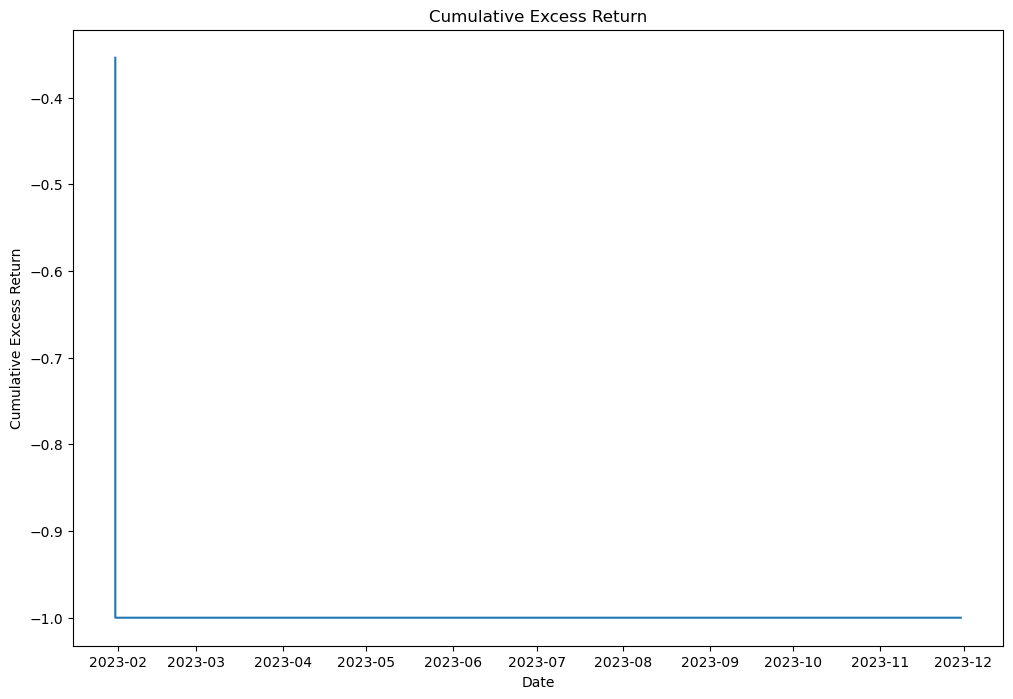

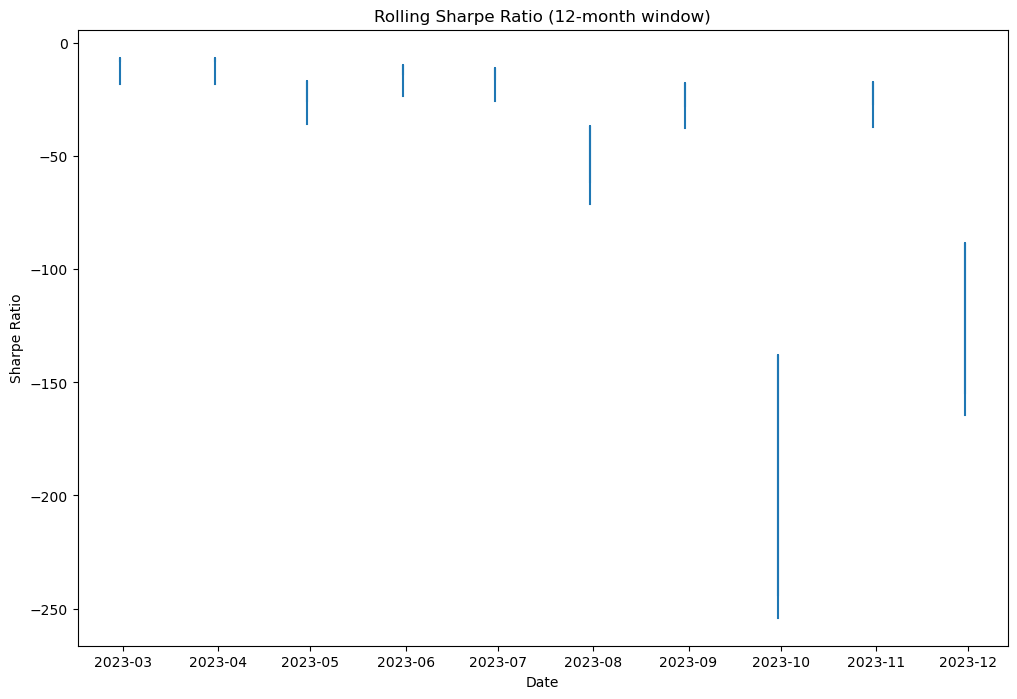

In [274]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 8))
# plt.plot(portfolio_data.index, portfolio_data['cumulative_excess_return'])
# plt.title('Cumulative Excess Return')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Excess Return')
# plt.show()

# plt.figure(figsize=(12, 8))
# plt.plot(portfolio_data.index, portfolio_data['rolling_sharpe'])
# plt.title('Rolling Sharpe Ratio (12-month window)')
# plt.xlabel('Date')
# plt.ylabel('Sharpe Ratio')
# plt.show()

In [151]:
# class TimeBasedCV:
#     def __init__(self, train_period, val_period, test_period, freq='M'):
#         self.train_period = train_period  # Number of periods for the training set
#         self.val_period = val_period      # Number of periods for the validation set
#         self.test_period = test_period    # Number of periods for the test set
#         self.freq = freq                  # Frequency of the periods

#     def split(self, data, first_split_date):
#         # Generate dates from the start date to the end date with the given frequency
#         end_date = data.index.max()
#         start_date = first_split_date - pd.DateOffset(months=self.train_period)

#         dates = pd.date_range(start=start_date, end=end_date, freq=self.freq)
        
#         # Loop through the dates ensuring no index out of bounds error
#         for i in range(len(dates) - self.train_period - self.val_period - self.test_period + 1):
#             train_start = dates[i]
#             train_end = dates[i + self.train_period]
#             val_start = train_end
#             val_end = train_end + pd.DateOffset(months=self.val_period)
#             test_start = val_end
#             test_end = val_end + pd.DateOffset(months=self.test_period)

#             if test_end > end_date:
#                 break  # Break the loop if the calculated test end date exceeds the data range

#             train_mask = (data.index >= train_start) & (data.index < train_end)
#             val_mask = (data.index >= val_start) & (data.index < val_end)
#             test_mask = (data.index >= test_start) & (data.index < test_end)

#             yield data.index[train_mask], data.index[val_mask], data.index[test_mask]


In [155]:
# print("Data date range:", X.index.min(), "to", X.index.max())


Data date range: 2014-02-28 00:00:00 to 2023-11-30 00:00:00


In [162]:
# from sklearn.model_selection import ParameterGrid
# # Initialize TimeBasedCV with the scheme you want to use
# tscv = TimeBasedCV(train_period=60, val_period=24, test_period=24, freq='M')  # 'M' for monthly frequency

# # Containers for results
# predictions = []
# y_test_list = []
# dates = []
# dic_r2_all = {}
# dic_max_depth_all = {}

# # Hyperparameters grid
# param_grid = {
#     'max_depth': [1,2,3,4,5,6],
#     'max_features': [3, 6, 12, 24, 46, 49]
# }
# grid = list(ParameterGrid(param_grid))
# mse = np.full((len(grid),1), np.nan, dtype=float)

# # Perform rolling window cross-validation
# for train_index, val_index, test_index in tscv.split(X, first_split_date=pd.Timestamp('2020-01-31')):
#     if len(train_index) == 0 or len(val_index) == 0 or len(test_index) == 0:
#         print("Empty split found. Check date alignment and range coverage.")
#         continue  # Skip this iteration if any split is empty
#     X_train = X.iloc[train_index]
#     y_train = y.iloc[train_index]
#     X_val = X.iloc[val_index]
#     y_val = y.iloc[val_index]
#     X_test = X.iloc[test_index]
#     y_test = y.iloc[test_index]

#     # Iterate over each combination of hyperparameters
#     for i in range(len(grid)):
#         rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
#                                          max_depth=grid[i]["max_depth"],
#                                          max_features=grid[i]["max_features"])
#         rf_model.fit(X_train, y_train)
#         y_val_pred = rf_model.predict(X_val)
#         mse[i, 0] = mean_squared_error(y_val, y_val_pred)

#     # Optimal hyperparameters
#     optim_param = grid[np.argmin(mse)]
#     rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1,
#                                      max_depth=optim_param["max_depth"],
#                                      max_features=optim_param["max_features"])
#     rf_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
#     preds = rf_model.predict(X_test)

#     # Store results
#     predictions.append(preds)
#     dates.append(y_test.index)
#     y_test_list.append(y_test)

#     # Calculate and store R^2 and model depth
#     r2 = 1 - sum((y_test - preds) ** 2) / sum((y_test - np.mean(y_test)) ** 2)
#     dic_r2_all["r2." + str(y_test.index[0])] = r2
#     dic_max_depth_all["depth." + str(y_test.index[0])] = optim_param["max_depth"]

# # Aggregate results for overall performance
# predictions_all = np.concatenate(predictions)
# y_test_list_all = np.concatenate(y_test_list)
# dates_all = np.concatenate(dates)

# R2OOS_RF = 1 - sum((y_test_list_all - predictions_all) ** 2) / sum((y_test_list_all - np.mean(y_test_list_all)) ** 2)
# print("R2OOS random forest: ", R2OOS_RF)

ValueError: need at least one array to concatenate

## 3.5 Portfolio Optimization

In [163]:
# #Generate a results dataframe containing the model predictions (yhat) and the true values (y_true) 
# #of the dependent variable for each stock in each month

# yhat = y_prep.tolist()
# y_true = y_test_list_all.tolist()
# i = dates_all.tolist()

# results = pd.DataFrame(
#     {'identifier': i,
#      'yhat': yhat,
#      'y_true': y_true
#     })

# results["identifier"]= results["identifier"].astype("str")
# results["date"] = results["identifier"].str[12:22]
# results["id"] = results["identifier"].str[36:51]
# results.drop(["identifier"],axis = 1, inplace=True)
# results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
# results['MonthYear'] = results['date'].dt.to_period('M')
# results = results.sort_values(by = ['date', 'id'], ascending = True)
# results = results.set_index(['MonthYear','id'])
# results

NameError: name 'predictions_all' is not defined

## 4. Assessment 